# ARC Specific-AI Model Performance!

In [3]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import warnings
import json
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
try:
  from rich import print
except:
  pass

file_path = '../../output/test_results.json' # Change filepath to your test_results.json

COLORS = [
  '#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
  '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'
]

In [7]:
def plot_single_image(matrix, ax, title, cmap, norm):
    ax.imshow(matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth = 0.5)
    
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x-0.5 for x in range(1 + len(matrix[0]))])     
    ax.set_yticks([x-0.5 for x in range(1 + len(matrix))])
    
    ax.set_title(title, fontweight='bold')


def plot_xyt(*images, task_id, titles=('Input', 'Predicted', 'Answer', 'Correct')):
    """Plots the input, predicted, and answer pairs of a specified task, using the ARC color scheme."""
    num_img = len(images)
    
    if num_img > 2:
        images = images[:1] + (images[2], images[1]) + (images[3:] if len(images) > 3 else tuple())
        titles = titles[:1] + (titles[2], titles[1]) + (titles[3:] if len(titles) > 3 else tuple())
    
    fig, axs = plt.subplots(1, num_img, figsize=(len(images)*3, 3))
    plt.suptitle(f'Task {task_id}', fontsize=20, fontweight='bold', y=0.96)
    
    cmap = colors.ListedColormap(COLORS)
    norm = colors.Normalize(vmin=0, vmax=9)
    
    images = [image.detach().cpu().squeeze(0).long() if isinstance(image, torch.Tensor) else torch.tensor(image) for image in images if image is not None]
    images = [torch.argmax(image, dim=0) if len(image.shape) > 2 else image for image in images]

    for i in range(num_img):
        plot_single_image(images[i], axs[i], titles[i], cmap, norm)
    
    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black')
    fig.patch.set_facecolor('#dddddd')

    fig.tight_layout()
    plt.show()

def plot_xyt_from_json(file_path='./output/test_results.json', titles=('Input', 'Output', 'Answer', 'Correct'), plot_only_correct=False, top_k=2, total=400, verbose=False):
    results = json.load(open(file_path, 'r'))

    exist_label_information = list(results.values())[0][0][0].get('target') is not None
    assert not plot_only_correct or exist_label_information, 'The results do not contain answer.'
    if len(list(results.values())[0][0]) < top_k:
        warnings.warn(f'Top-k is set to {top_k} but the number of trials is {len(list(results.values())[0][0])}, less than {top_k}.')

    if exist_label_information:
        task_ids_correct = [key for key, task_result in results.items() if \
            all(any(
                all(all(pixel == 3 for pixel in row) for row in trial['correct_pixels'])
                    for trial in trials[:top_k if len(trials) >= top_k else len(trials)]) for trials in task_result)
        ]
        print('N Submittable: {} | N Total: {} | N Correct: {} | Accuracy: {:.2f}%'. format(len(results), total, len(task_ids_correct), len(task_ids_correct)/total*100))
    else:
        print('N Submittable: {} | N Total: {}'.format(len(results), total))

    for task_id, task_result in results.items():
        if plot_only_correct and task_id not in task_ids_correct:
            continue

        for i, trials in enumerate(task_result):
            for j, trial in enumerate(trials):
                images = [trial[key] for key in ['input', 'output', 'target', 'correct_pixels'] if key in trial]
                hparams = trial['hparams']

                if j == top_k:
                    break
                
                if verbose:
                    print(f'Task {task_id} | Test {i+1}: {hparams}')
                plot_xyt(*images, task_id=task_id, titles=titles)

## Only Tasks got Correct

/var/folders/g5/j9f5zp8n5l31ydc2ywmk90l00000gn/T/ipykernel_2710/356582286.py:45: UserWarning: Top-k is set to 4 but the number of trials is 3, less than 4.
  warnings.warn(f'Top-k is set to {top_k} but the number of trials is {len(list(results.values())[0][0])}, less than {top_k}.')


N Submittable: 262 | N Total: 400 | N Correct: 28 | Accuracy: 7.00%

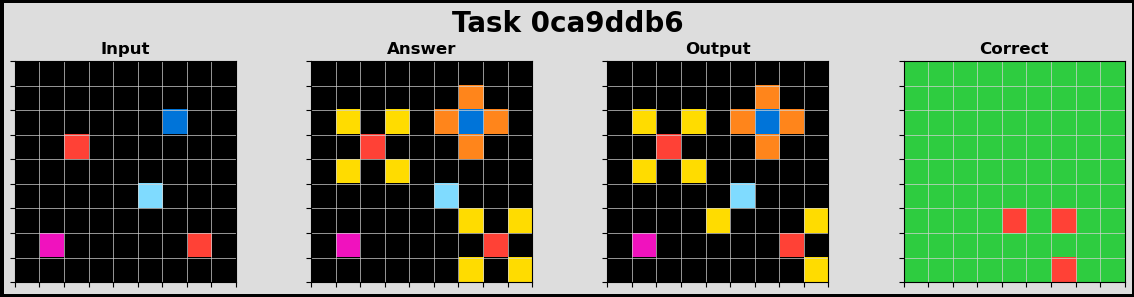

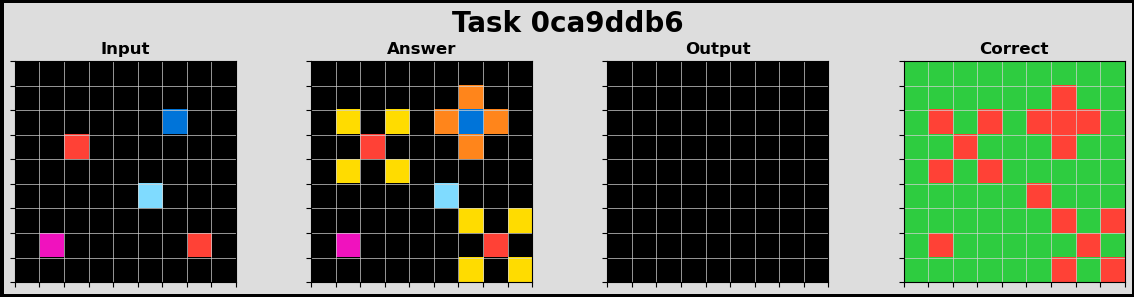

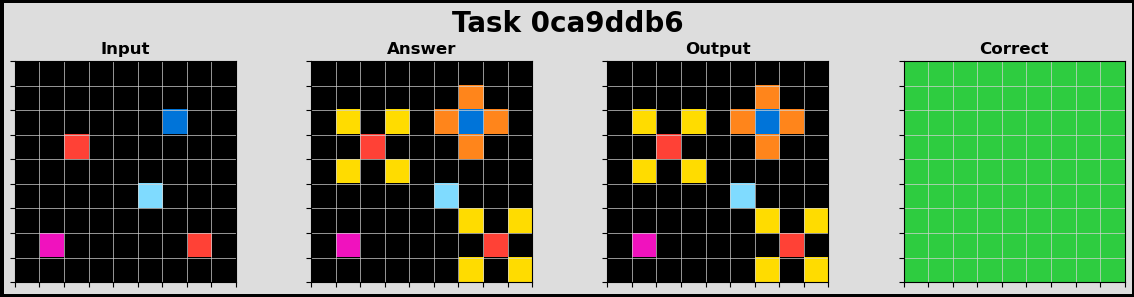

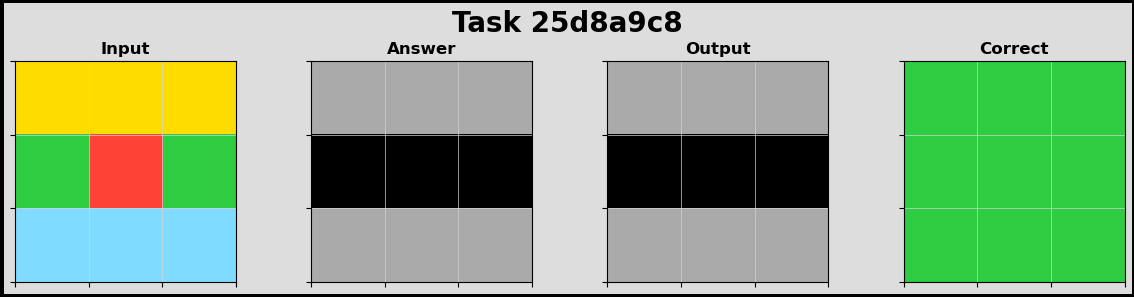

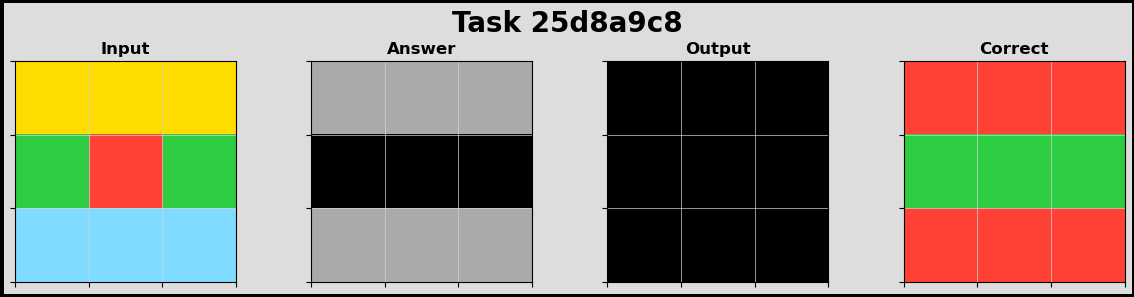

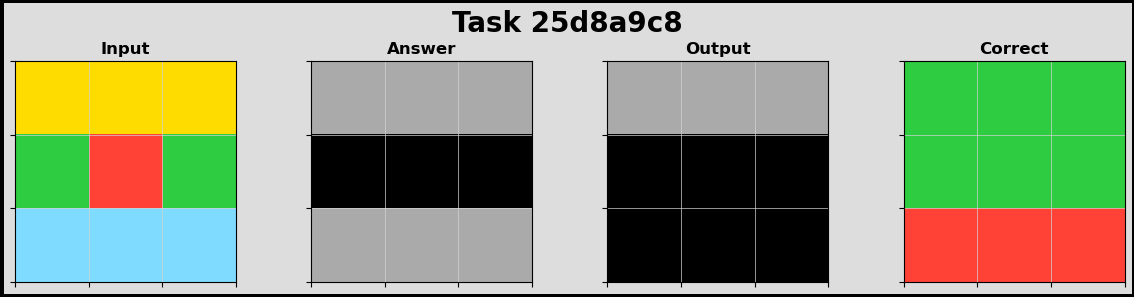

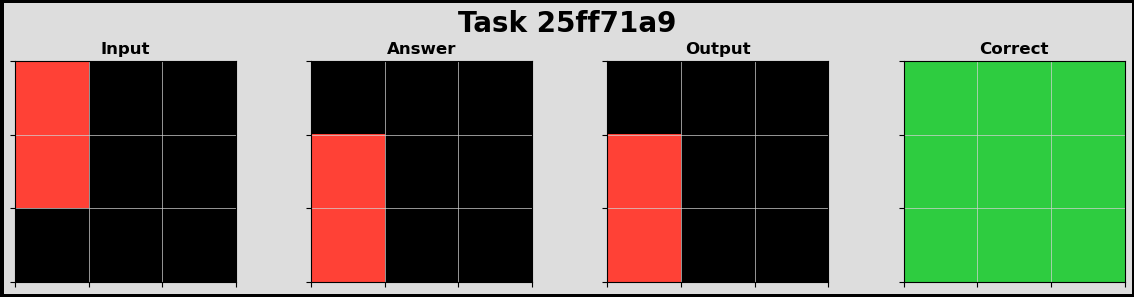

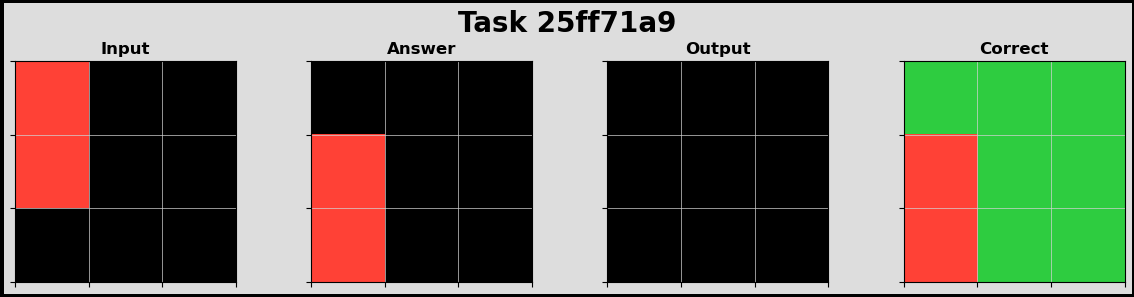

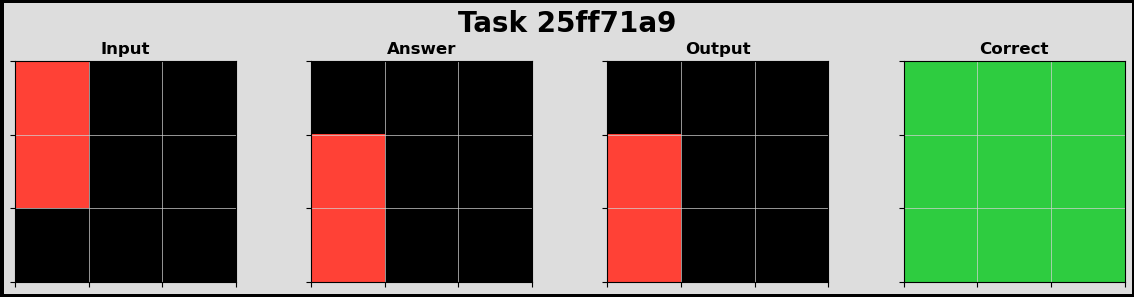

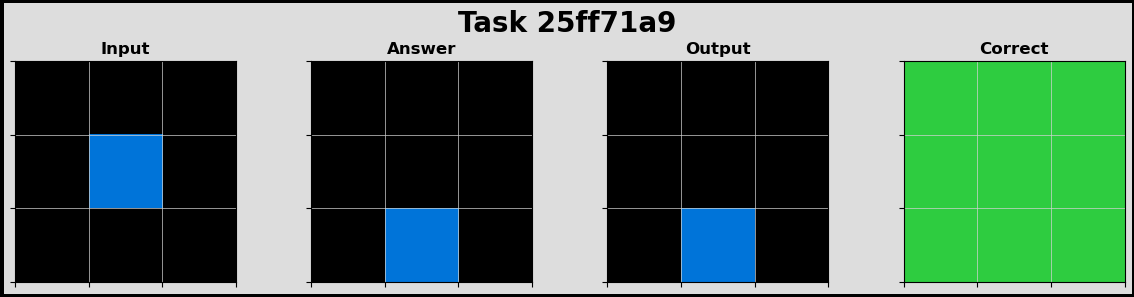

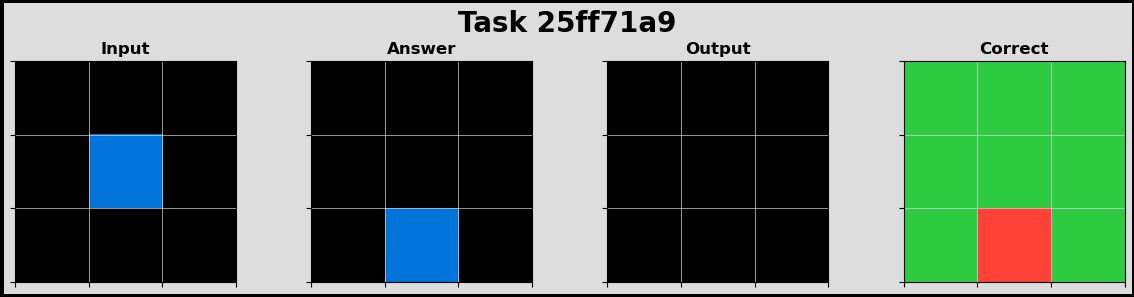

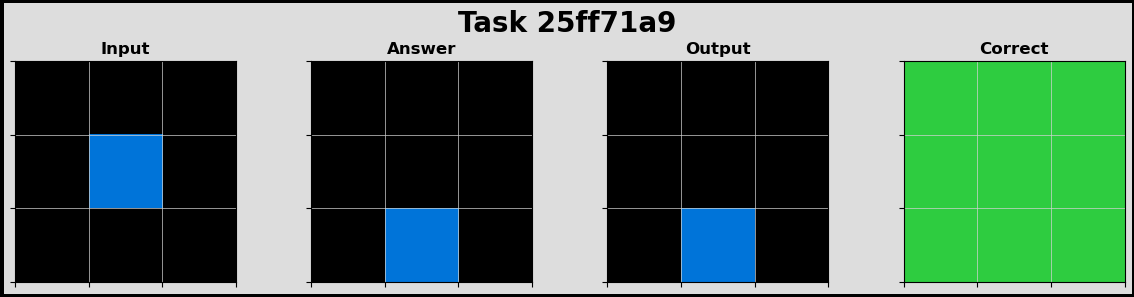

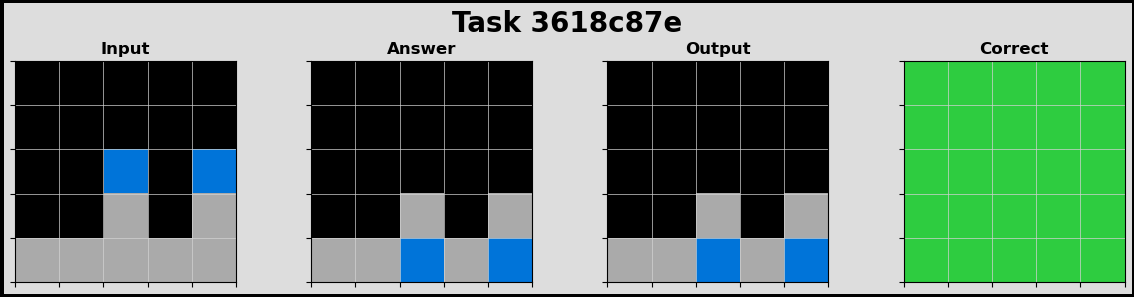

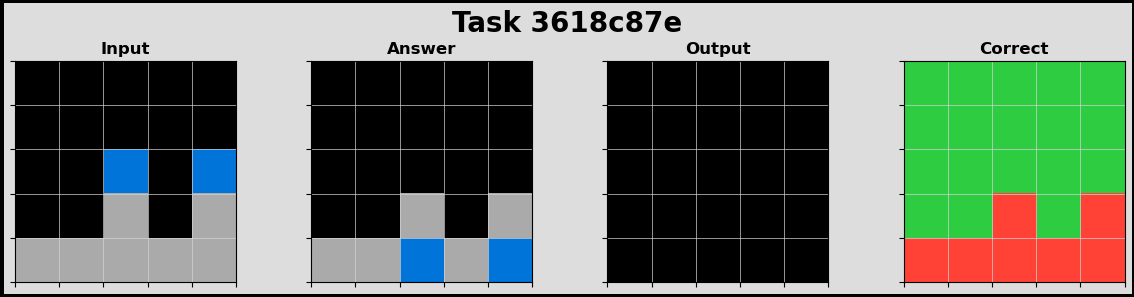

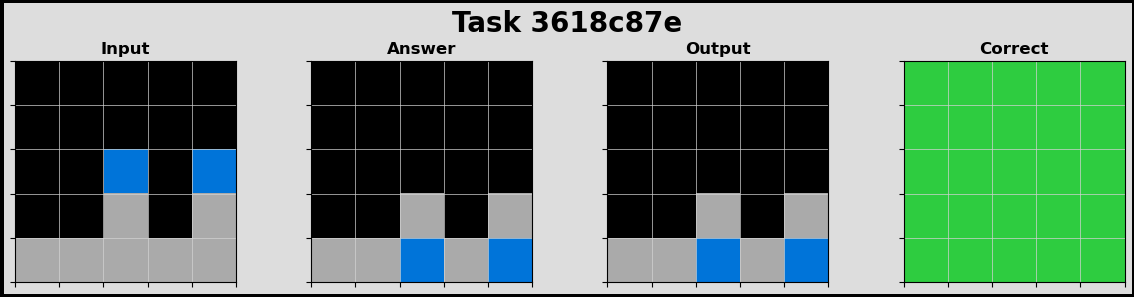

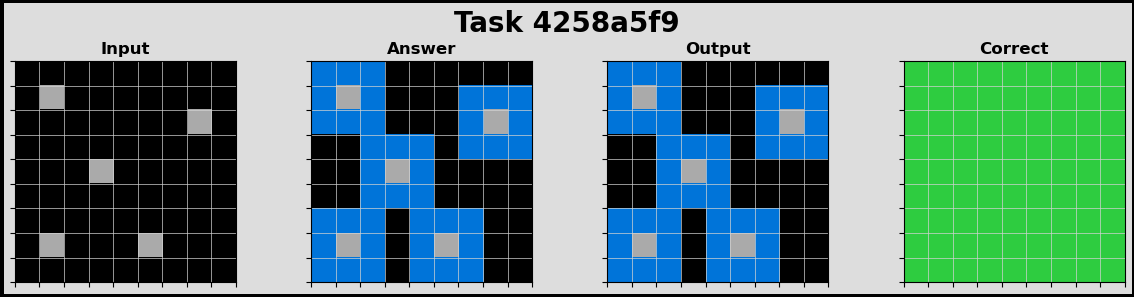

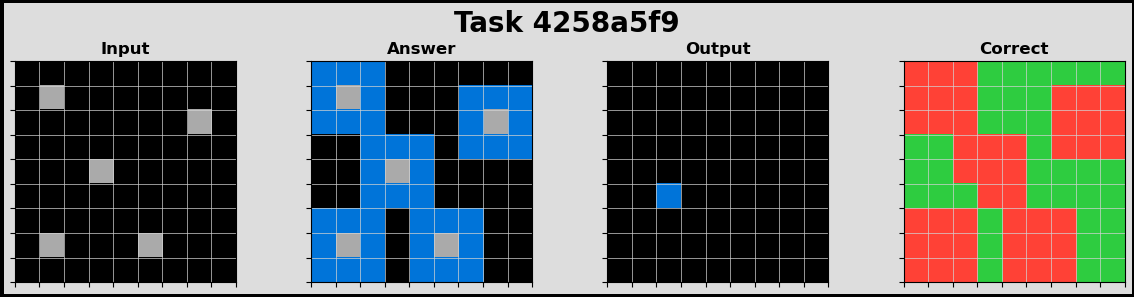

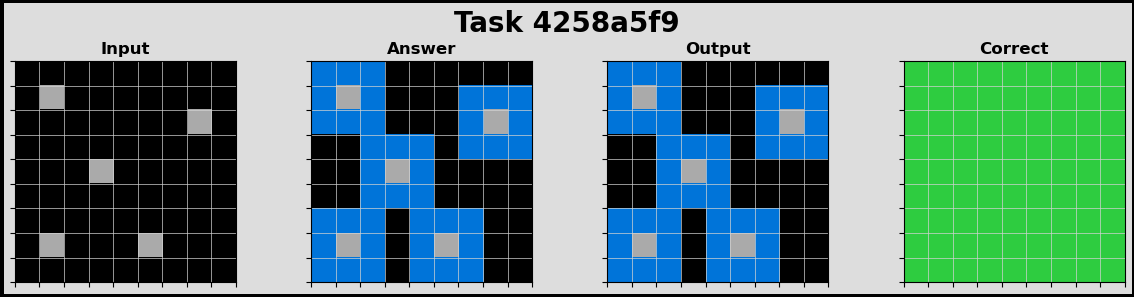

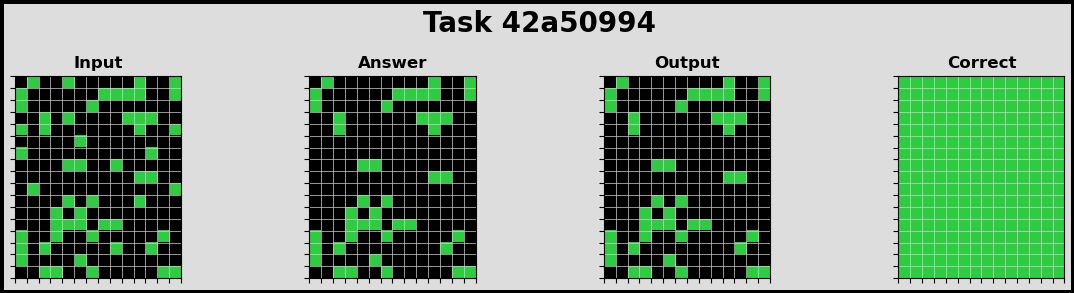

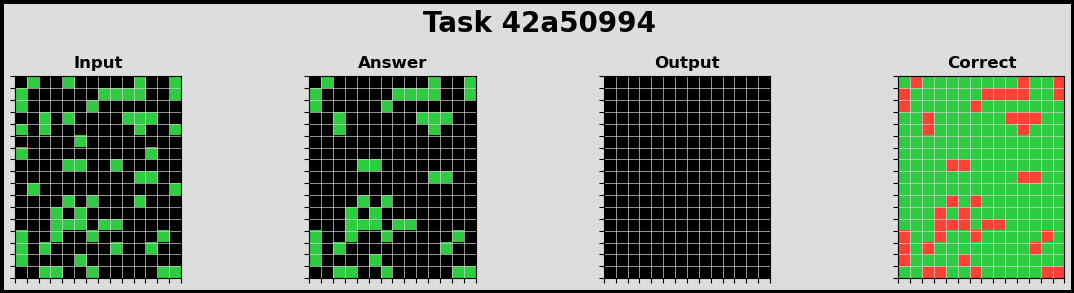

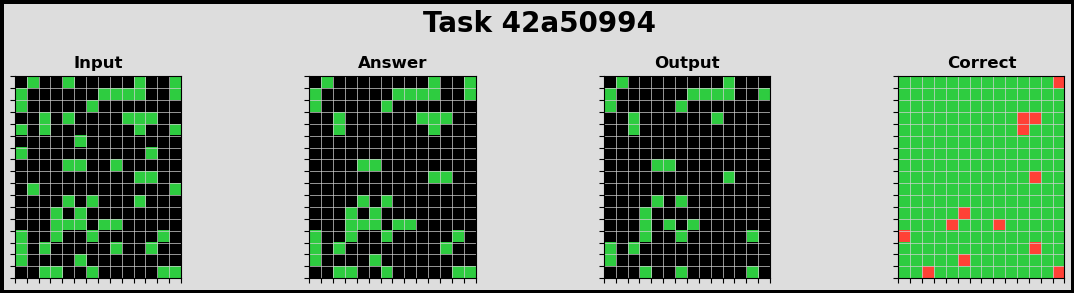

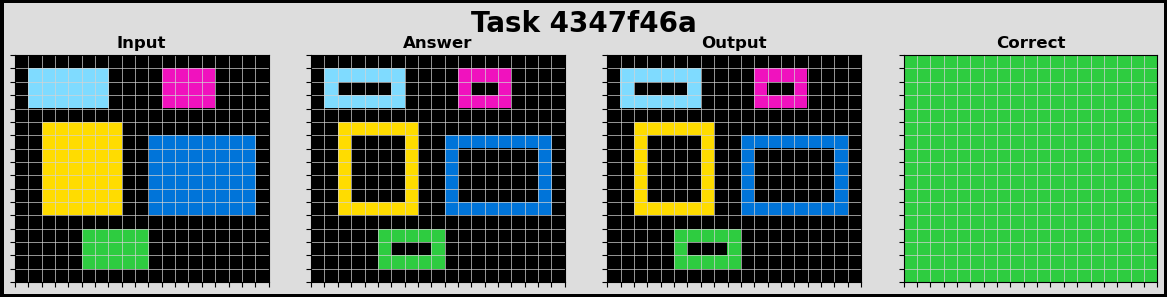

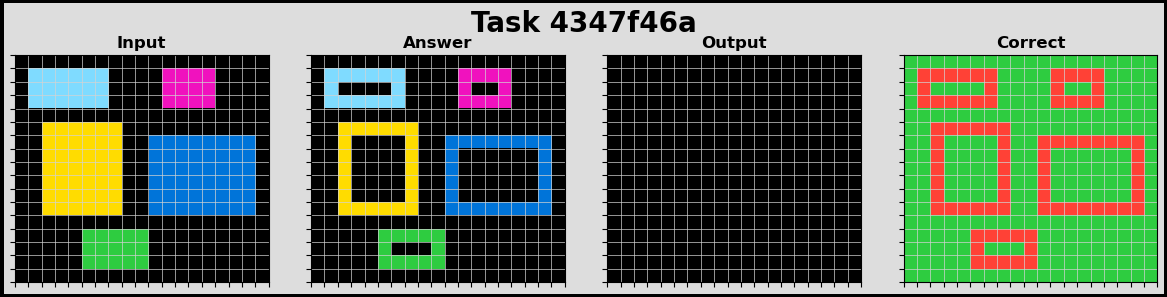

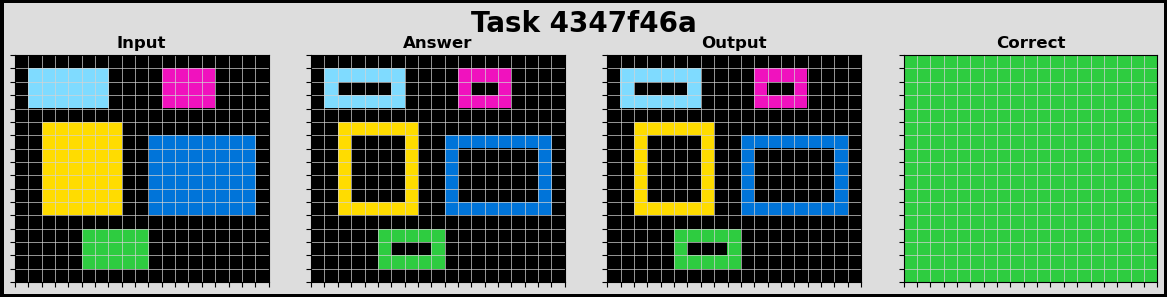

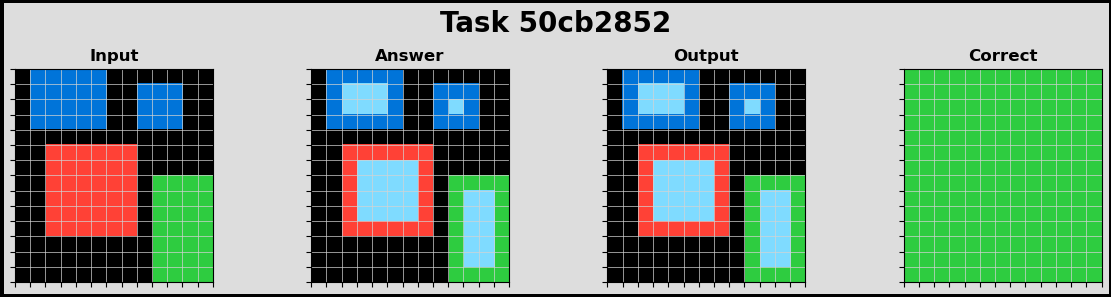

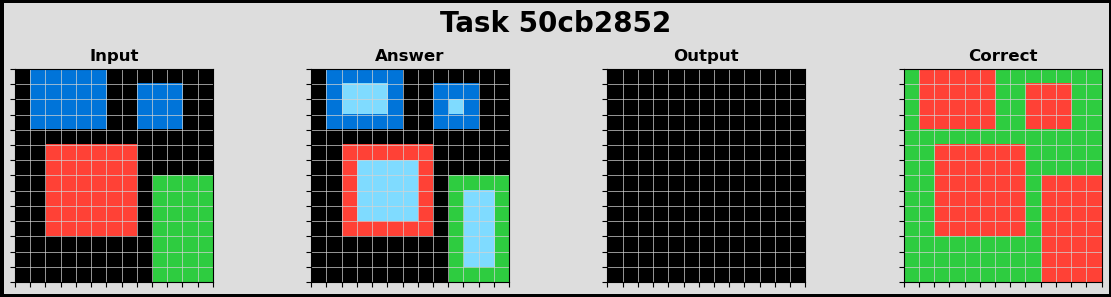

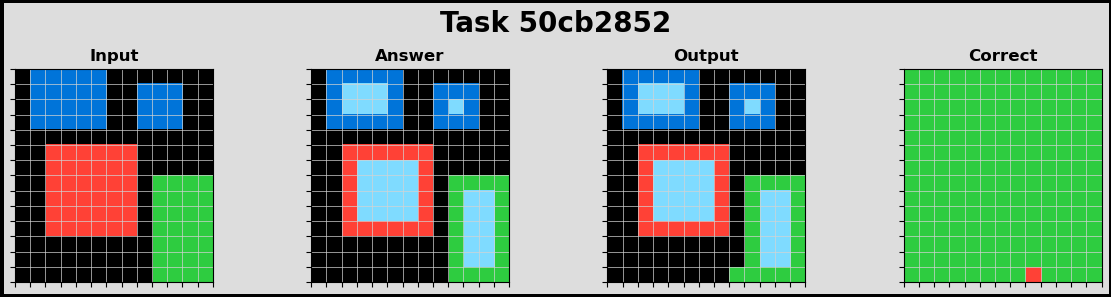

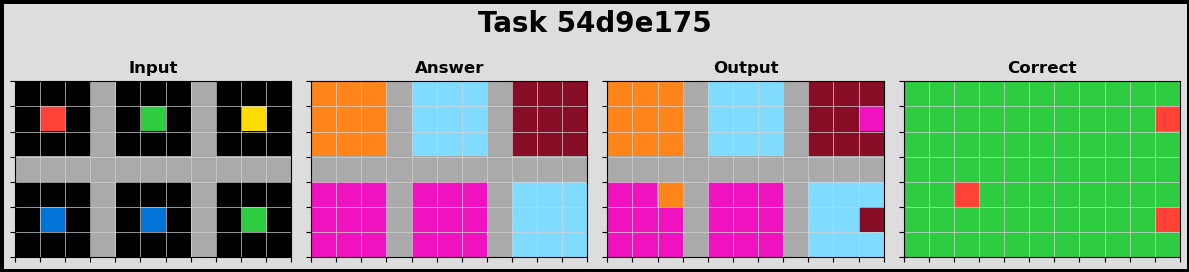

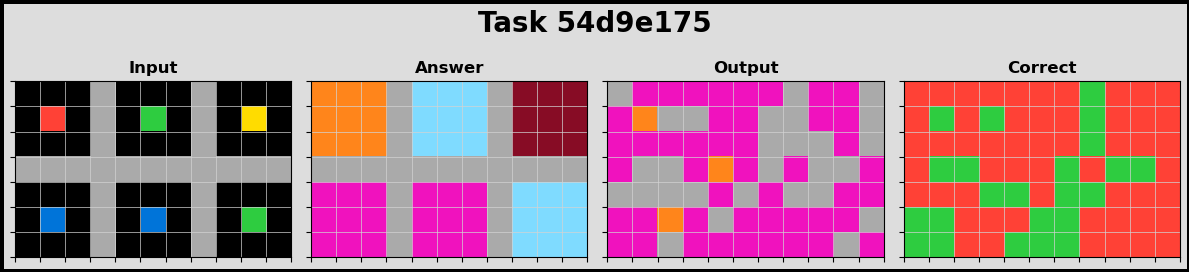

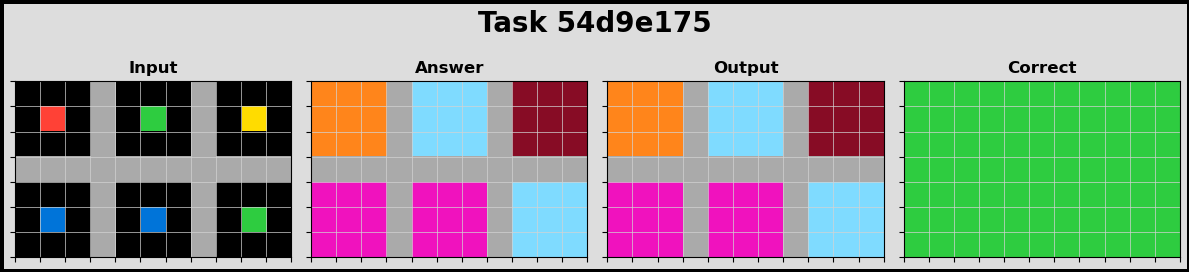

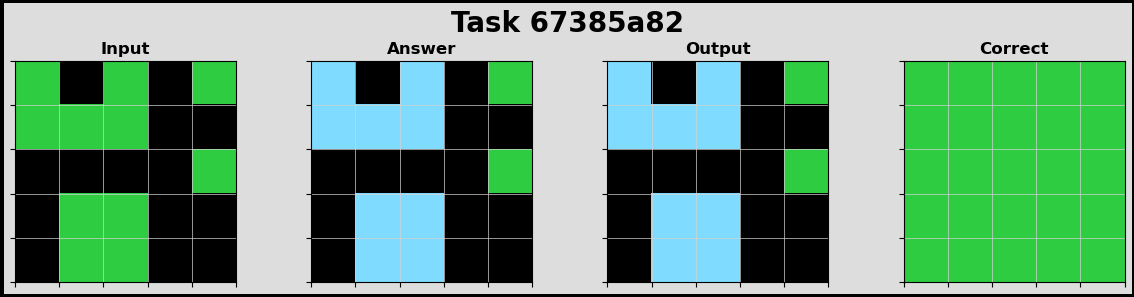

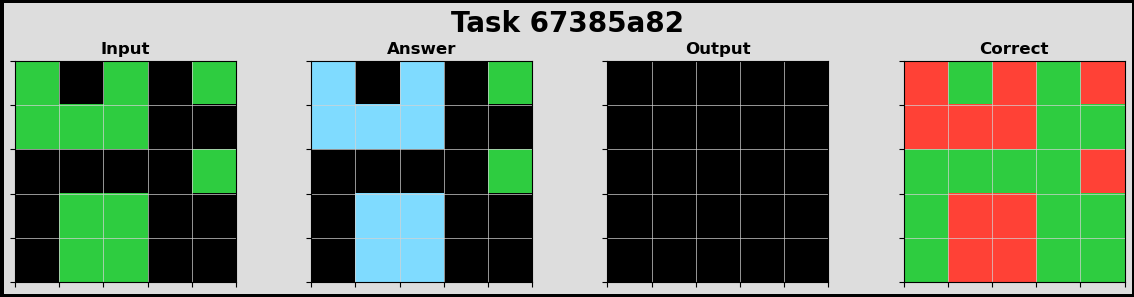

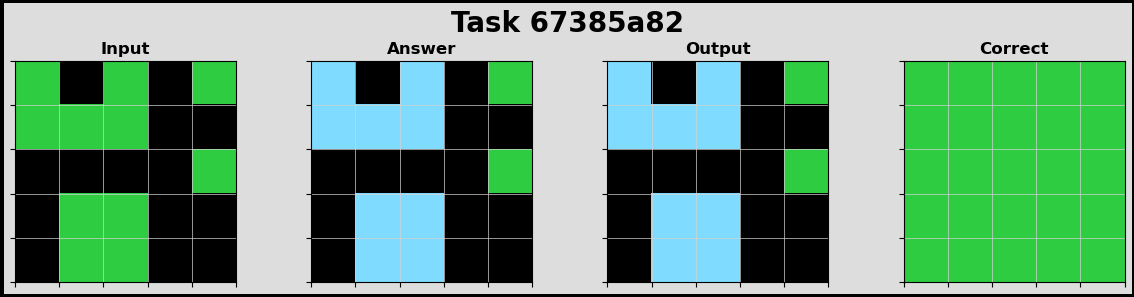

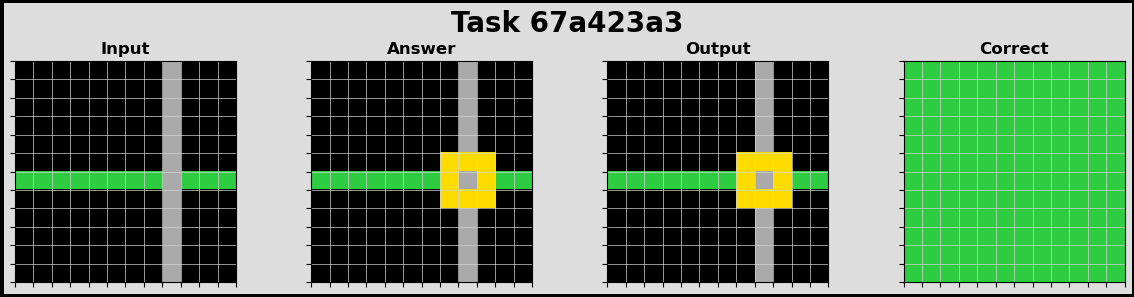

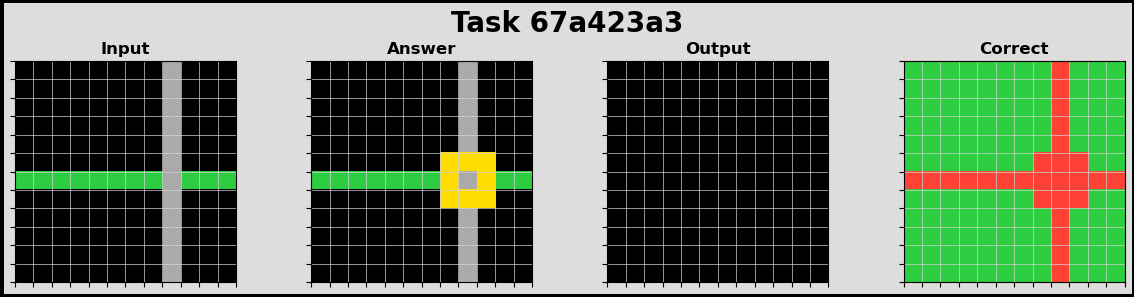

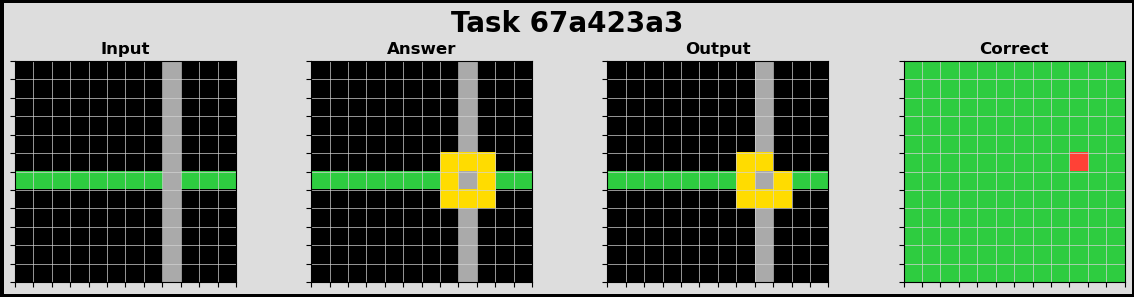

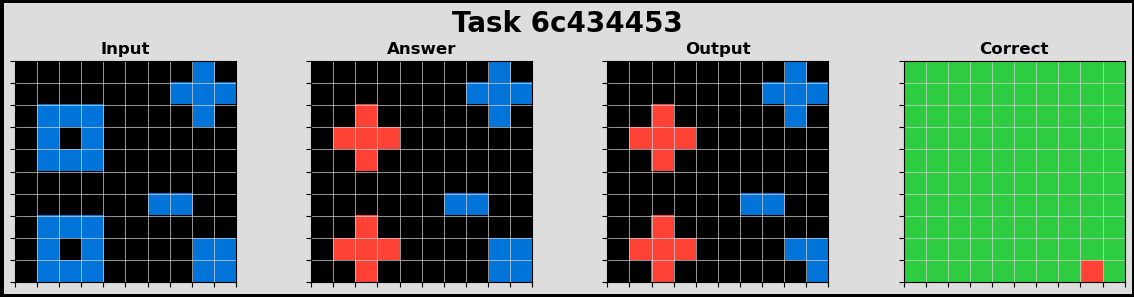

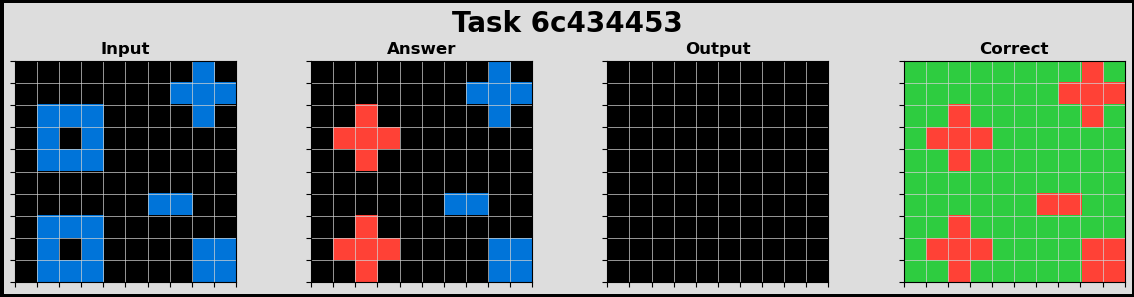

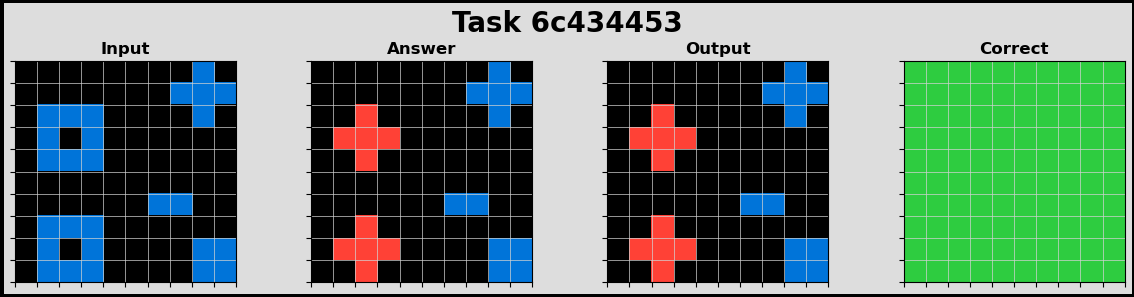

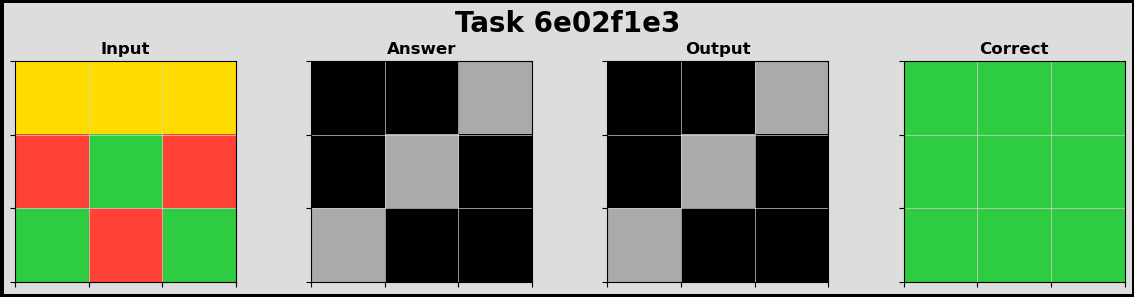

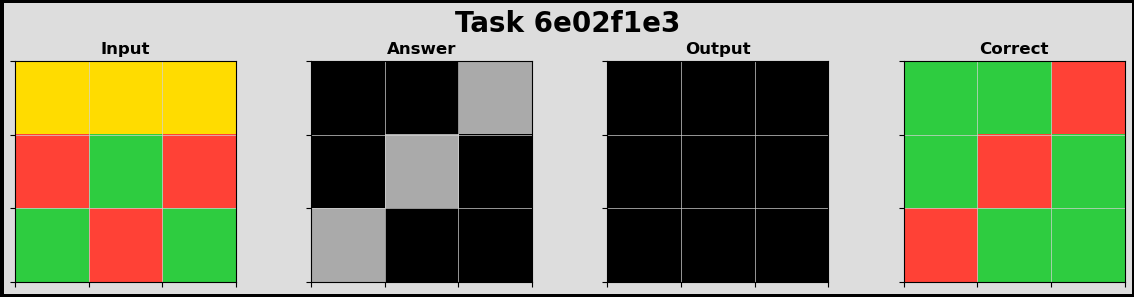

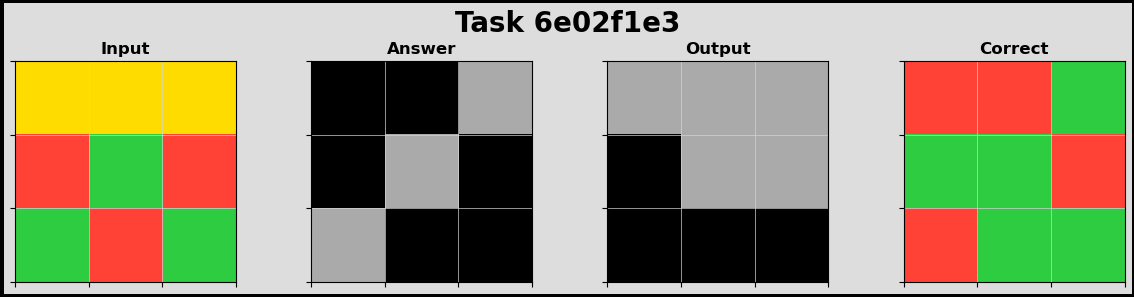

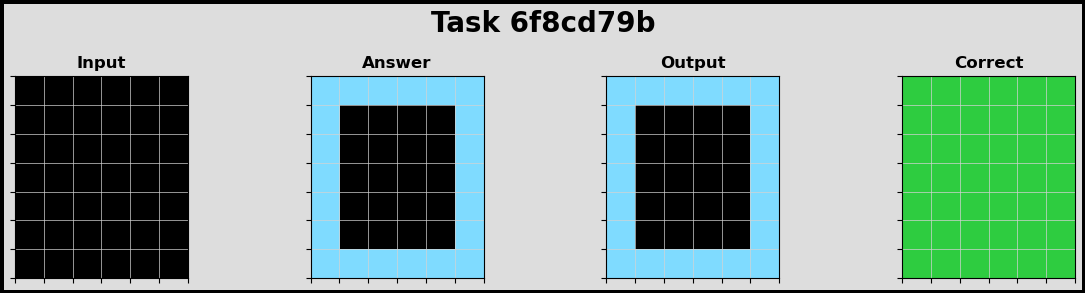

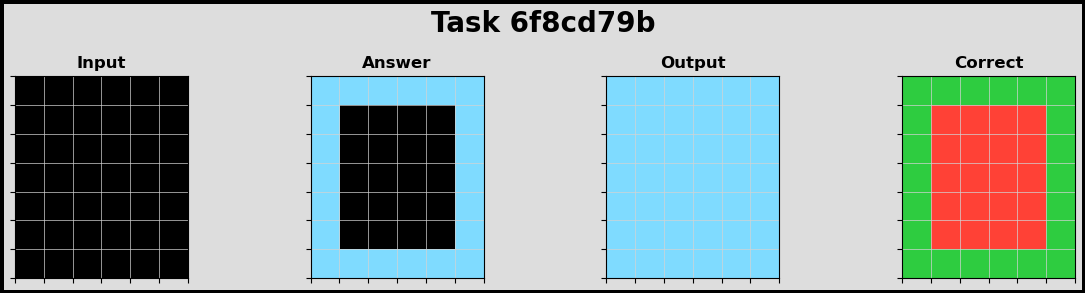

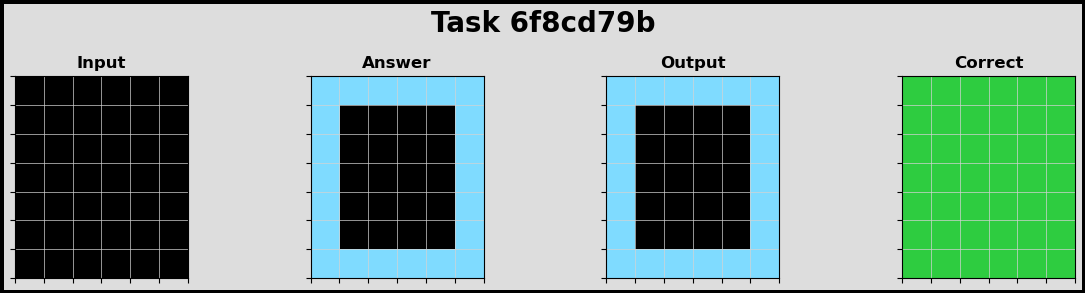

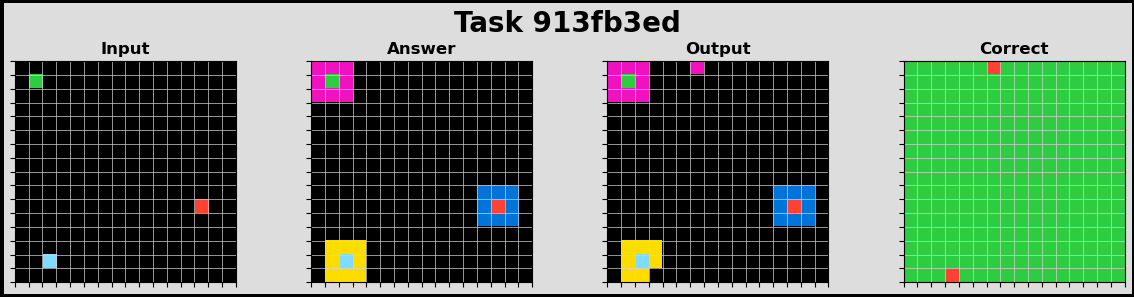

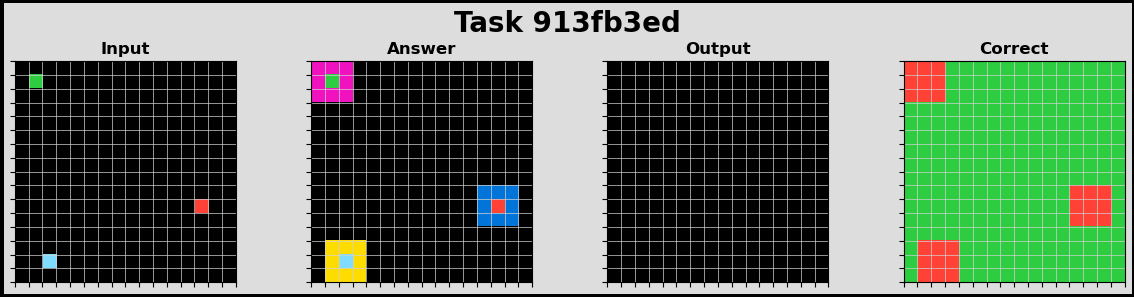

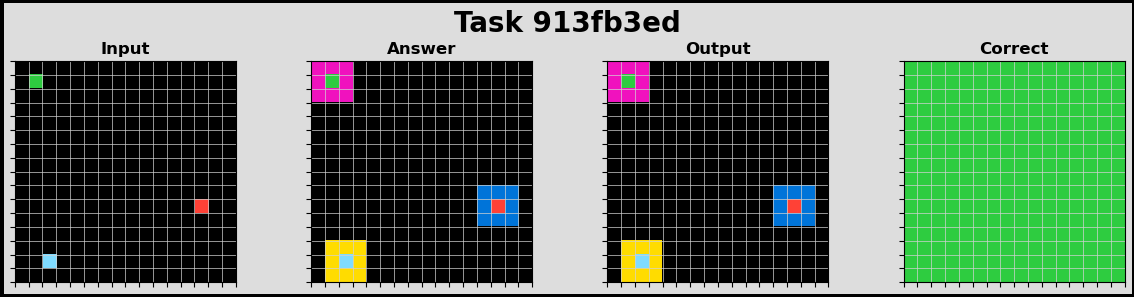

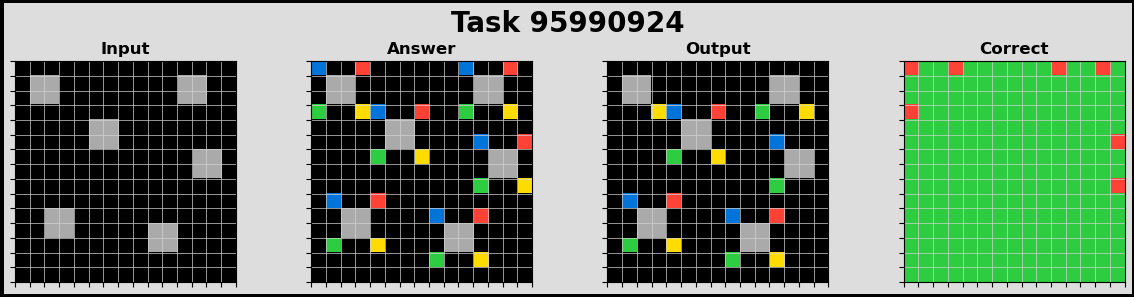

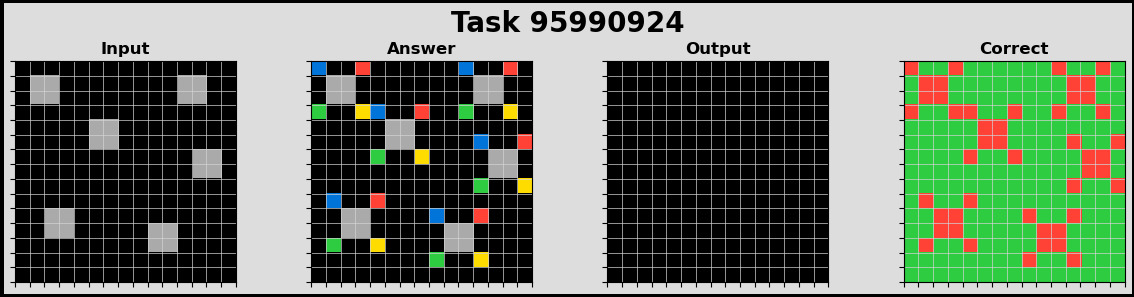

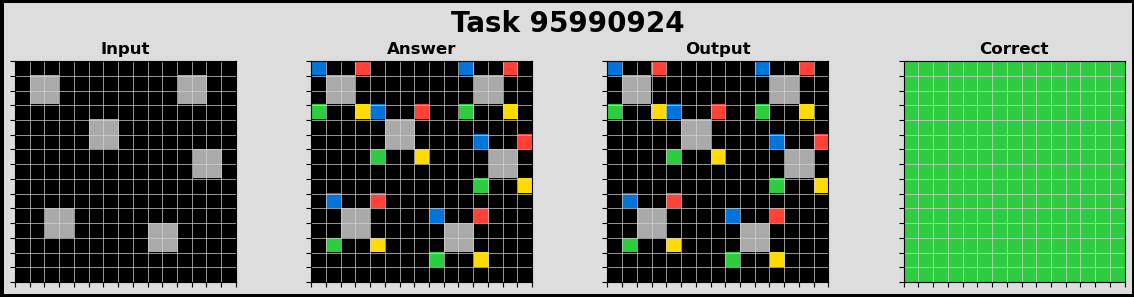

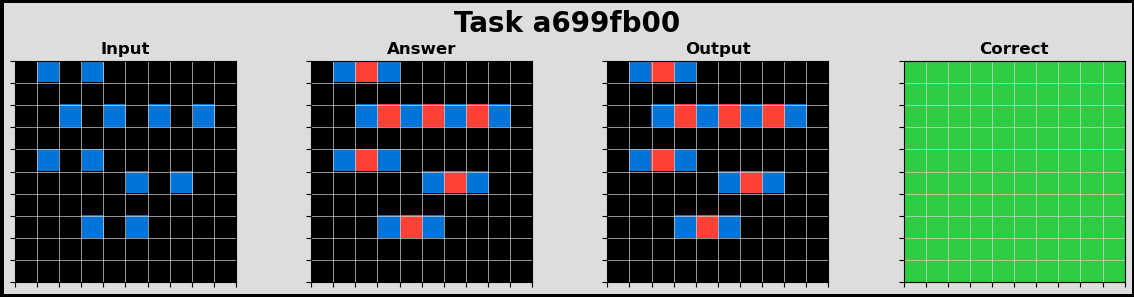

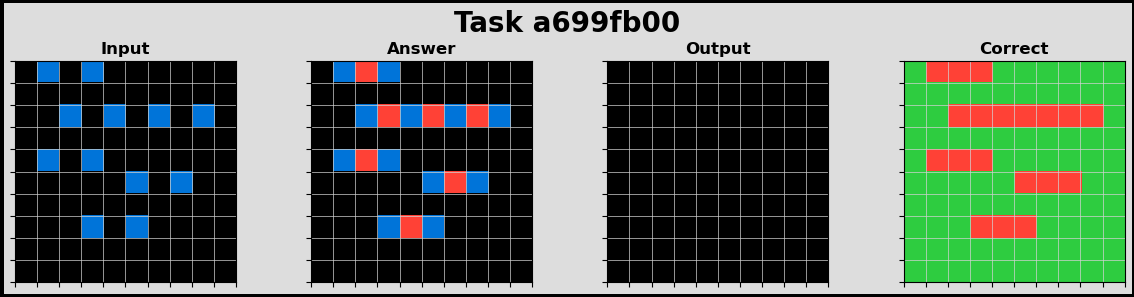

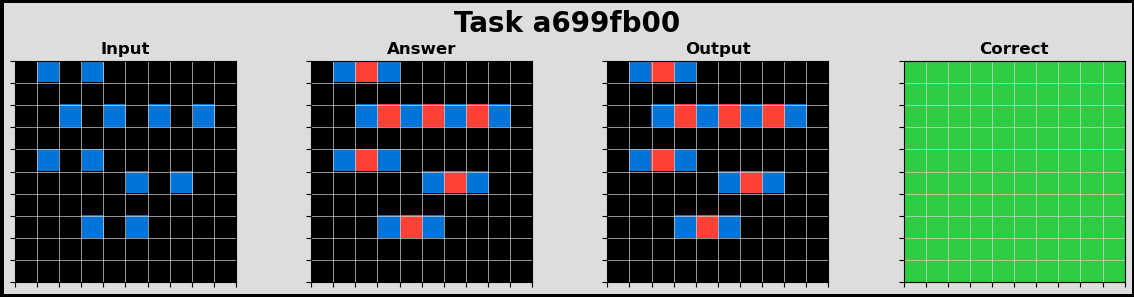

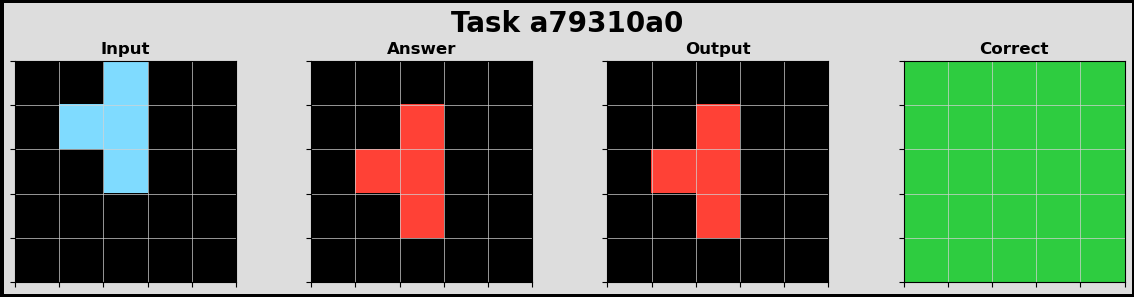

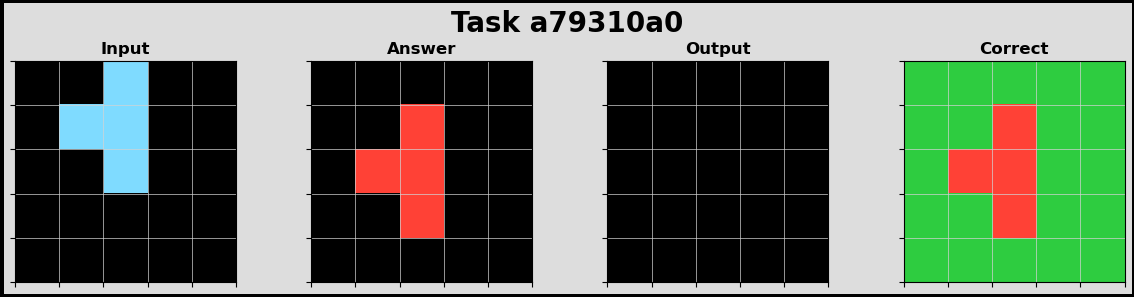

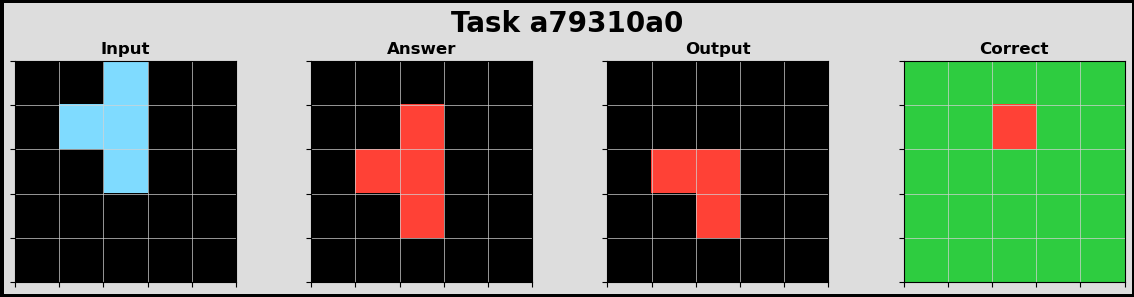

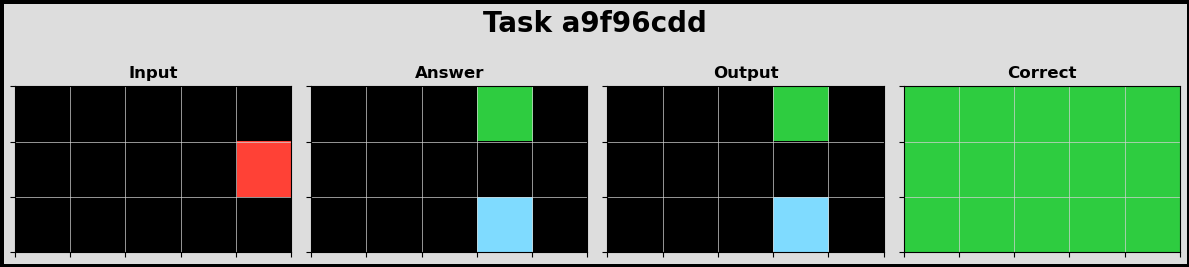

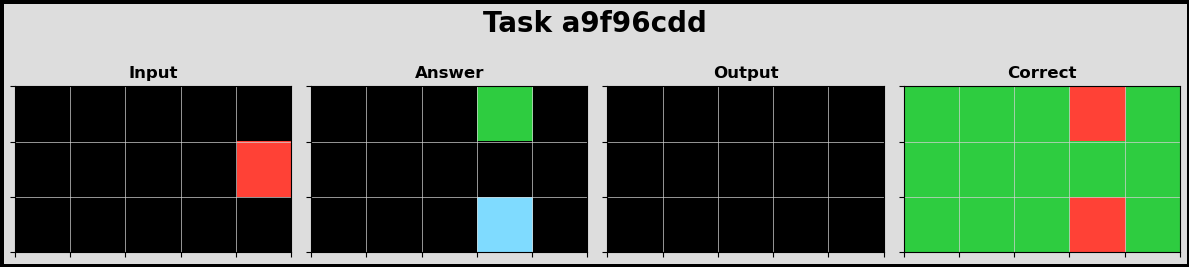

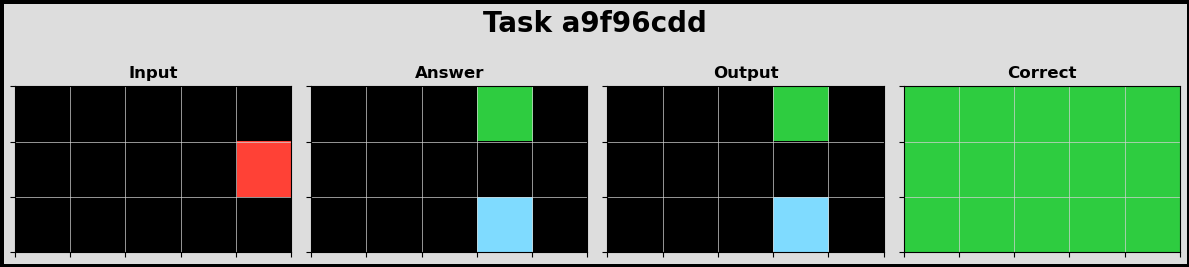

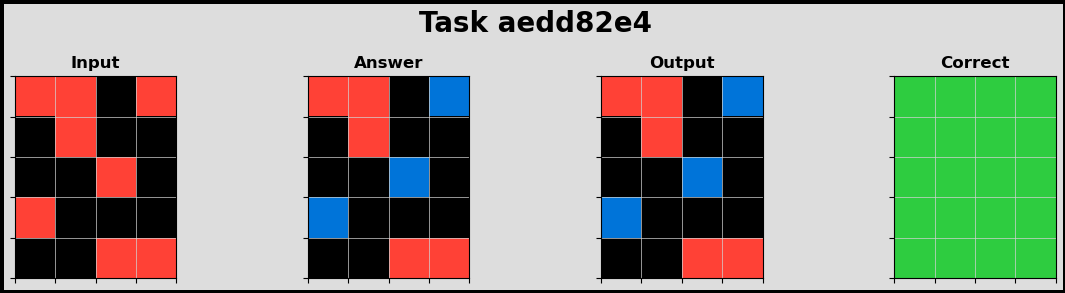

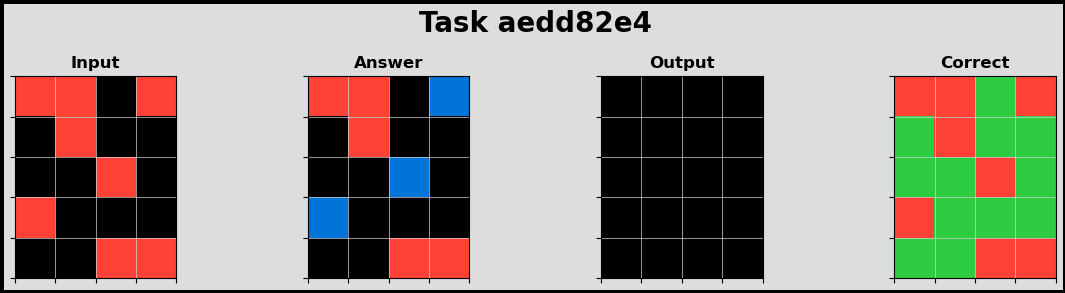

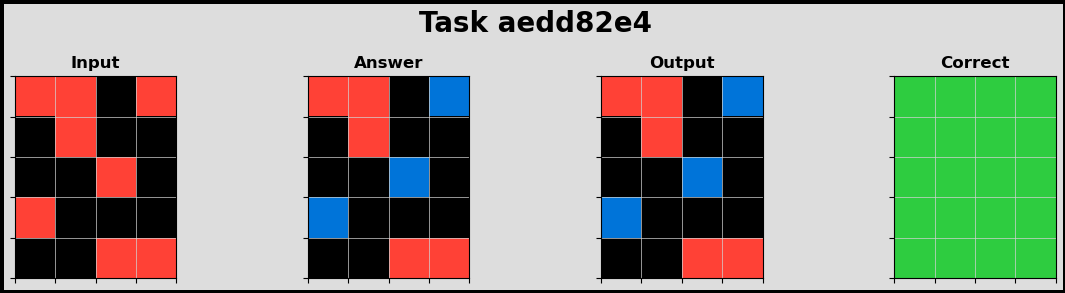

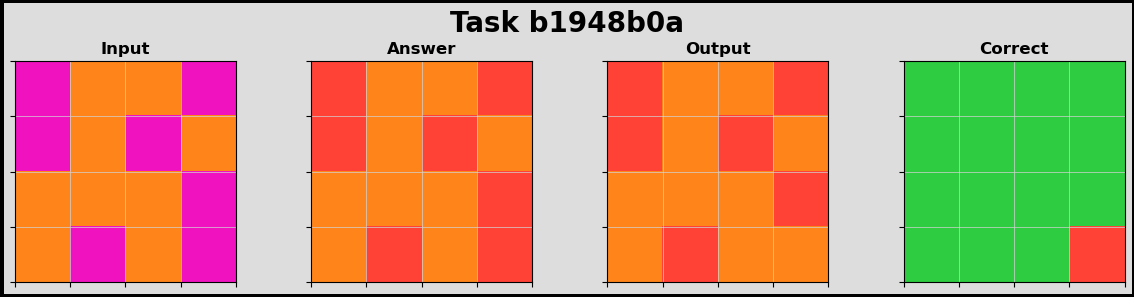

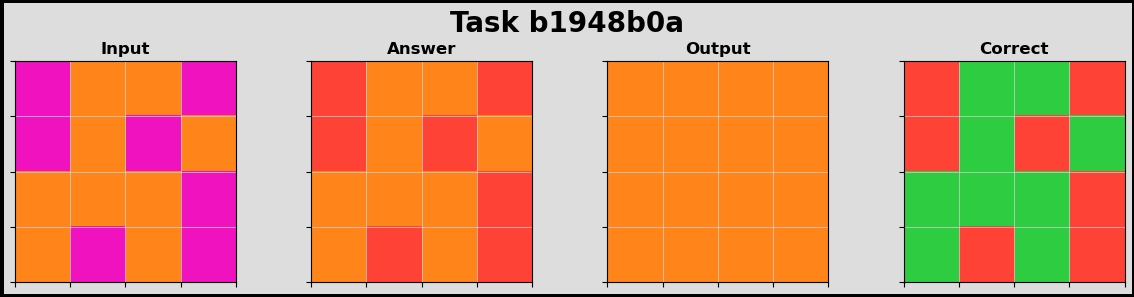

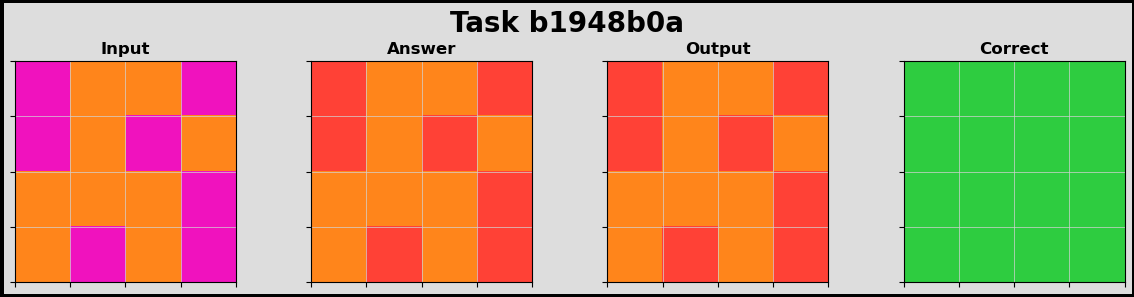

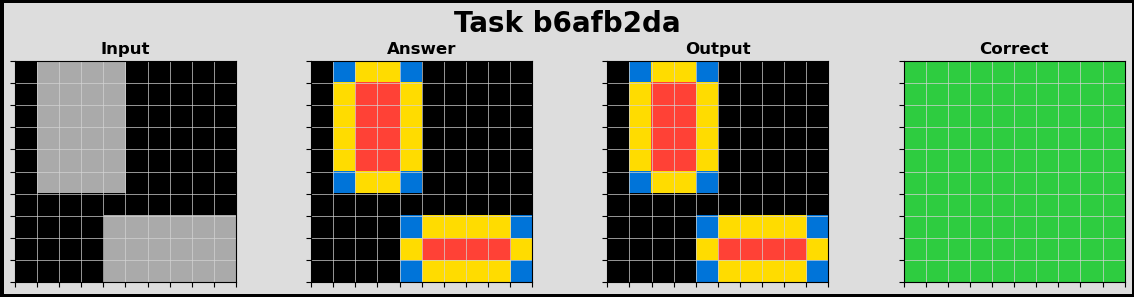

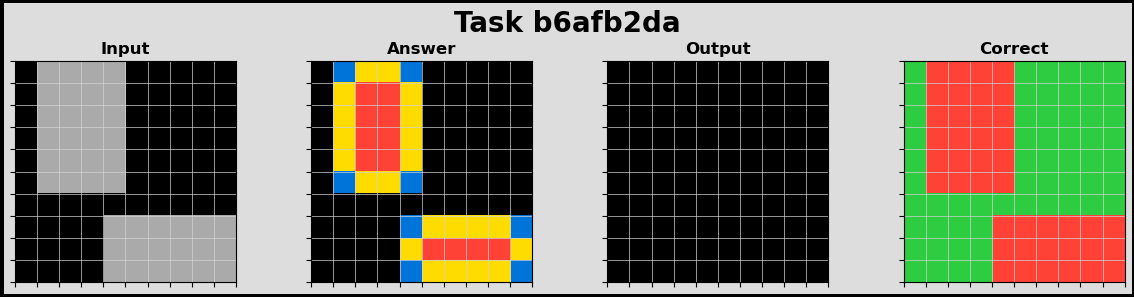

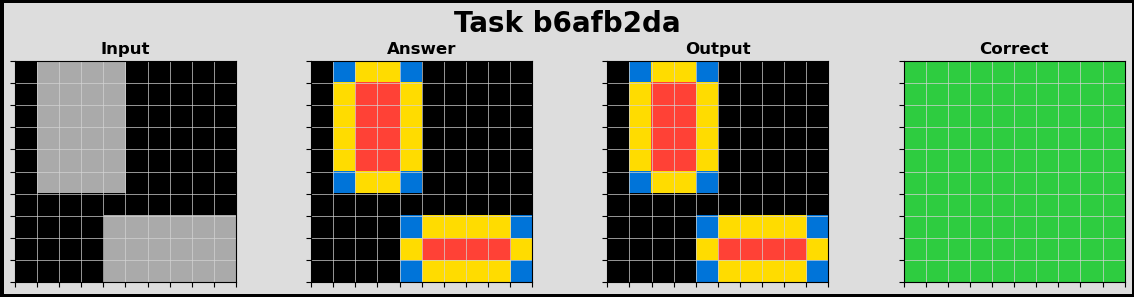

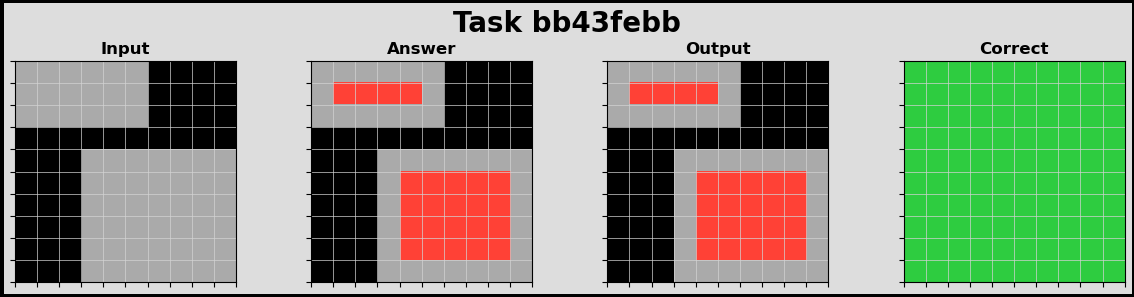

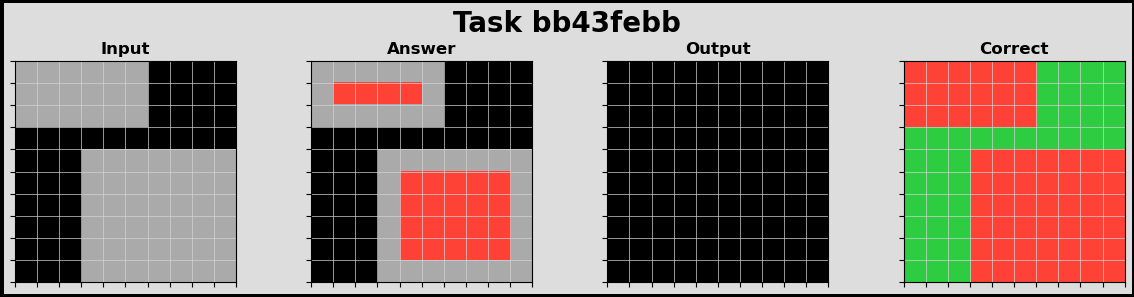

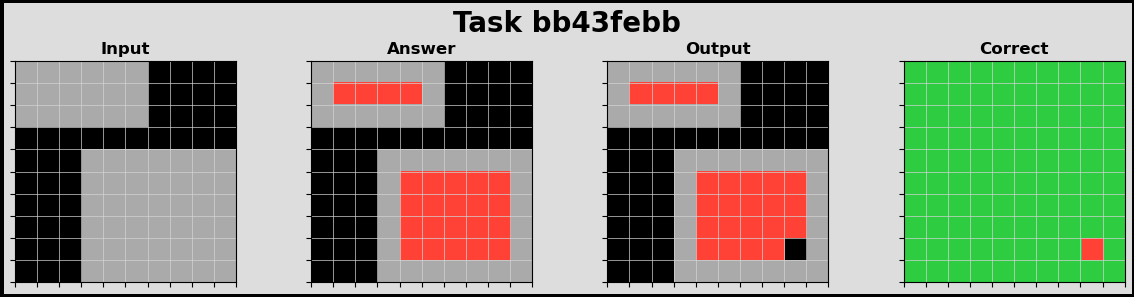

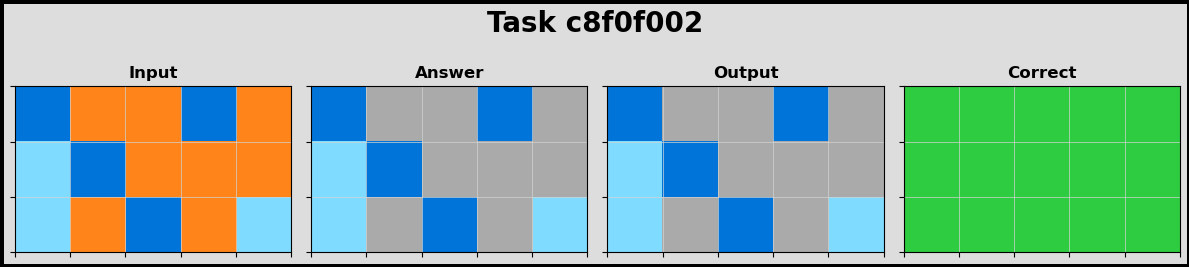

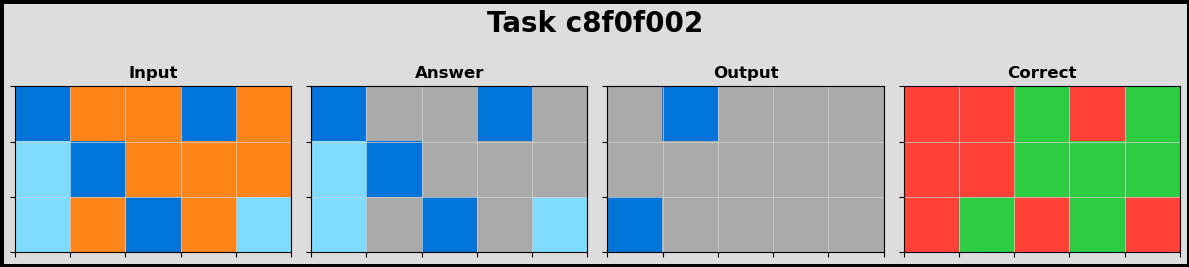

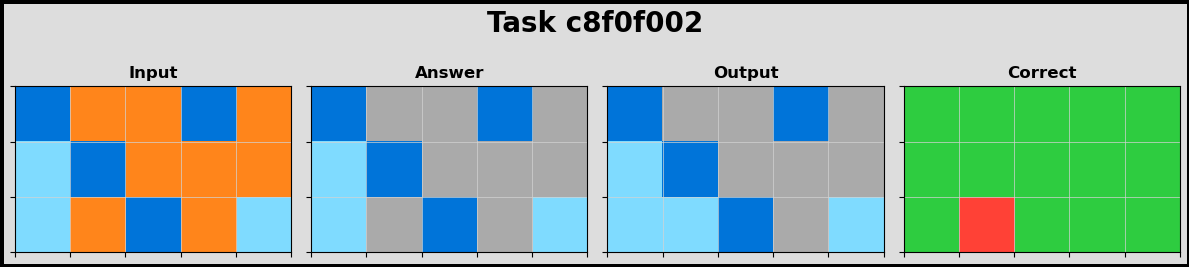

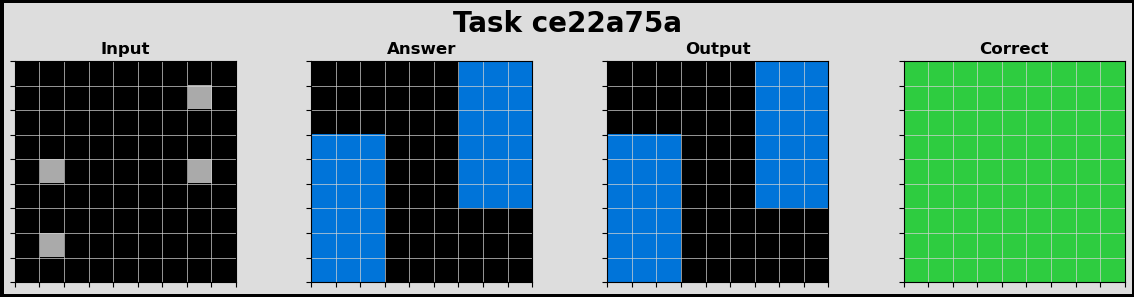

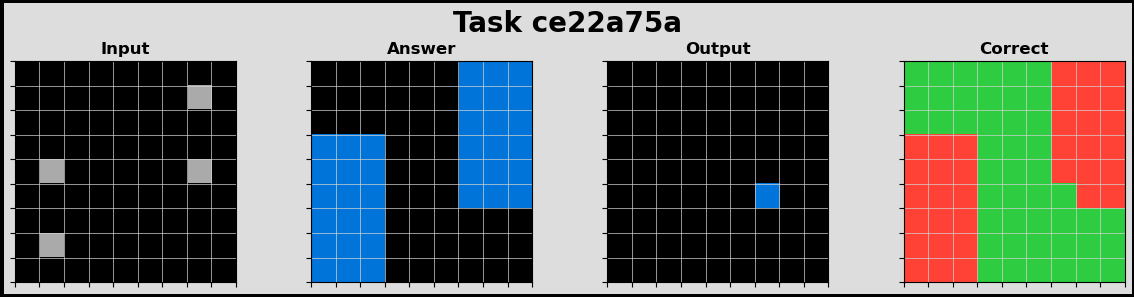

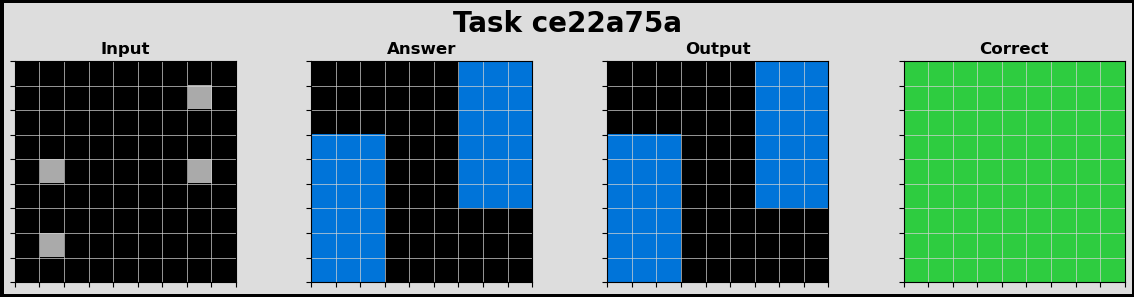

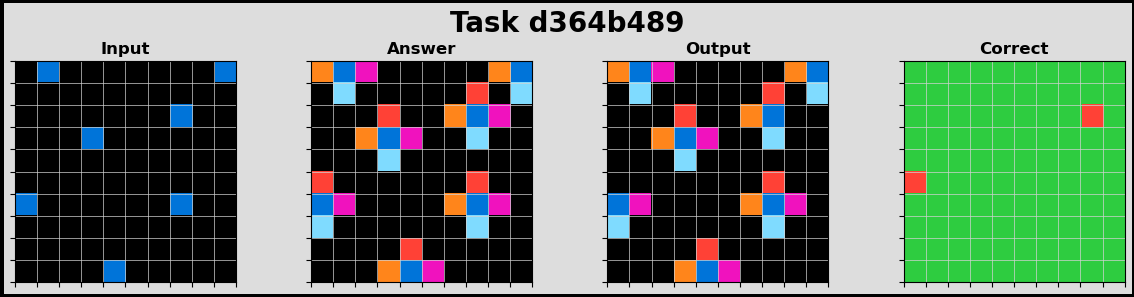

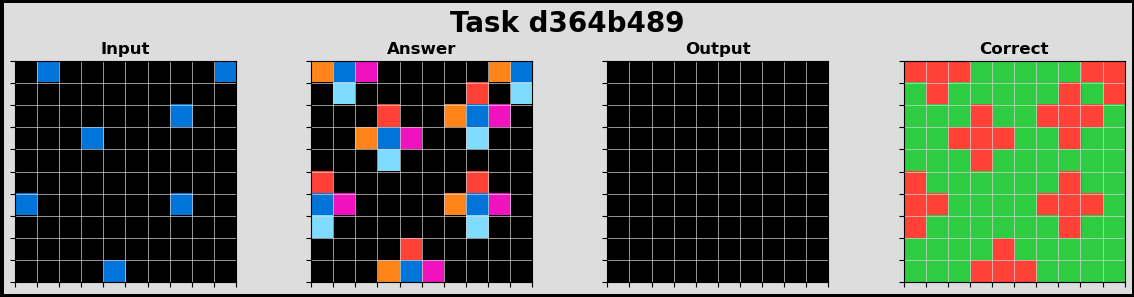

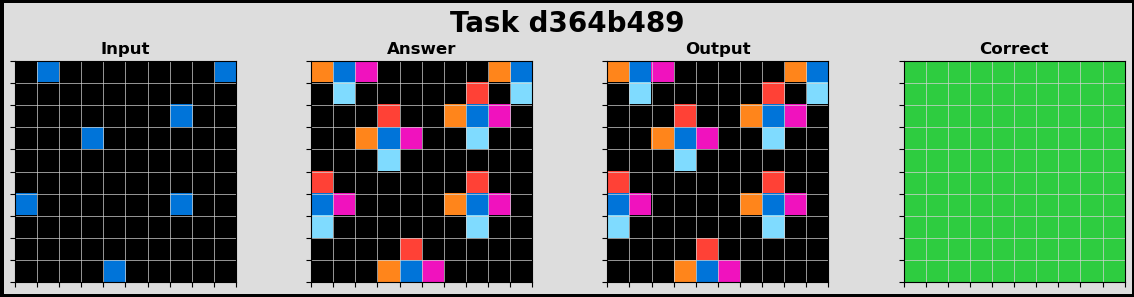

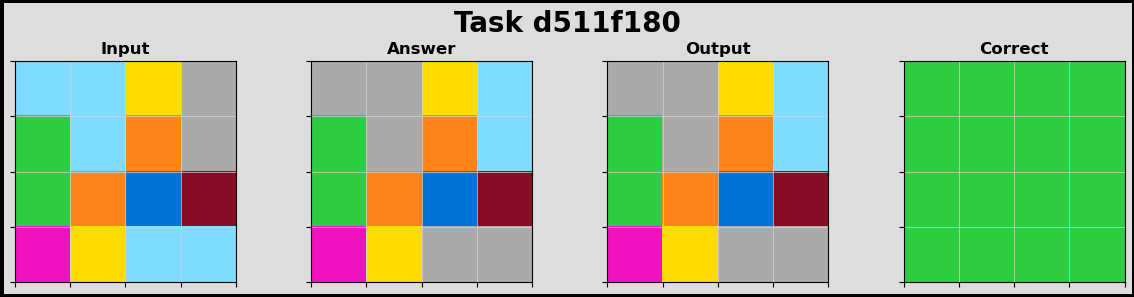

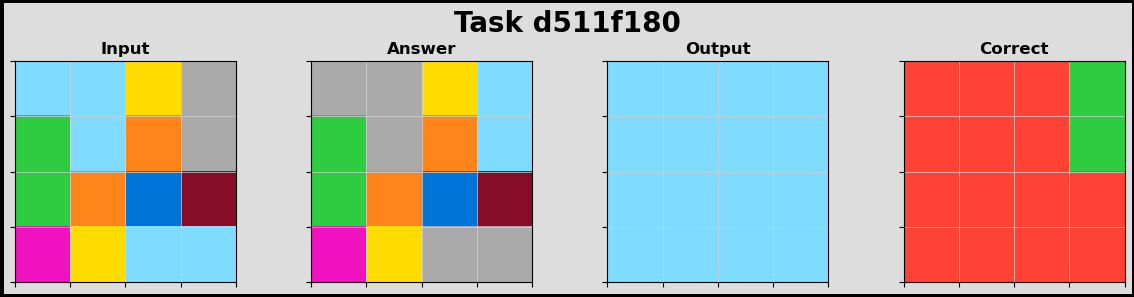

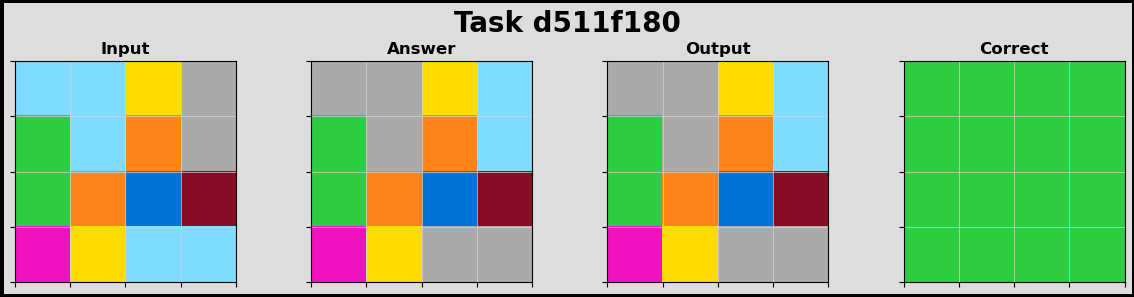

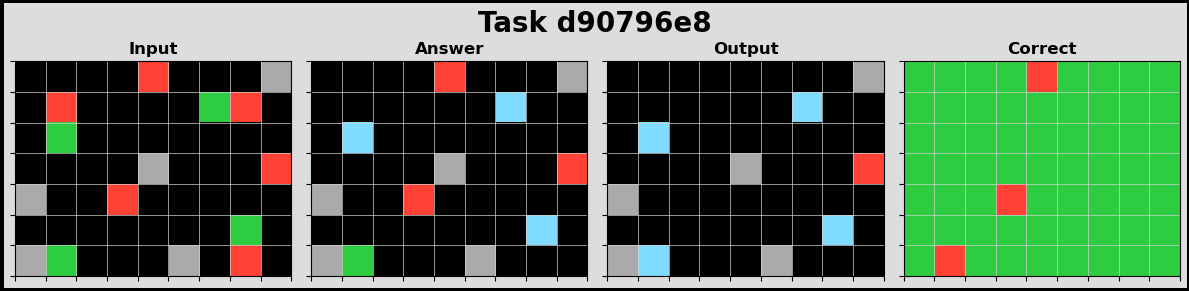

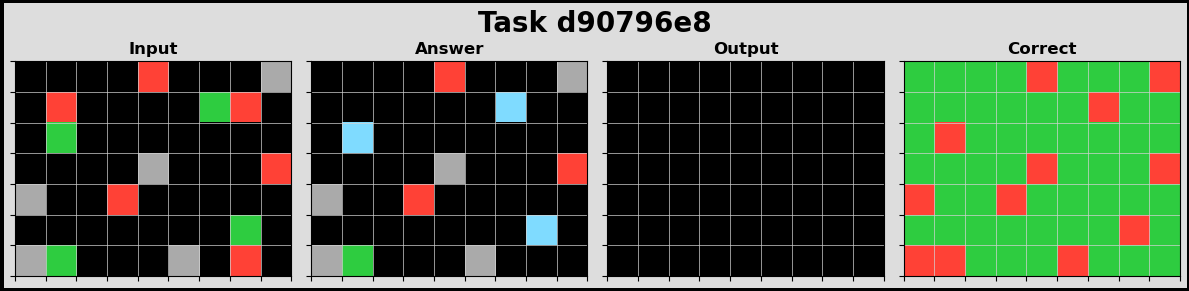

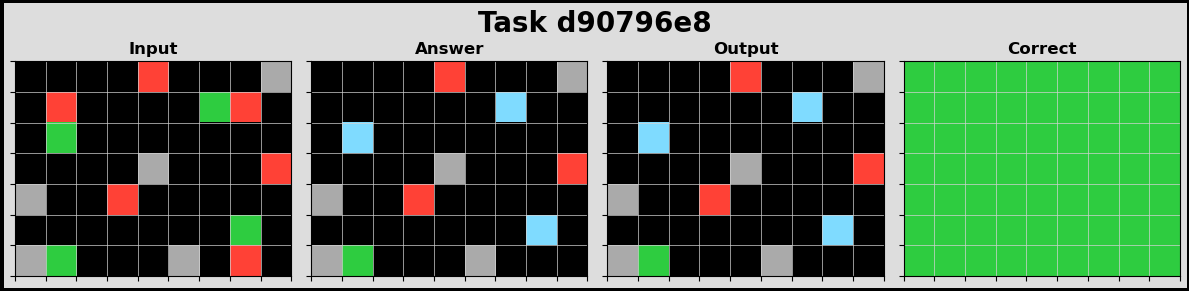

In [8]:
plot_xyt_from_json(file_path, plot_only_correct=True, top_k=4, total=400)

## All Tasks

N Submittable: 262 | N Total: 400 | N Correct: 20 | Accuracy: 5.00%

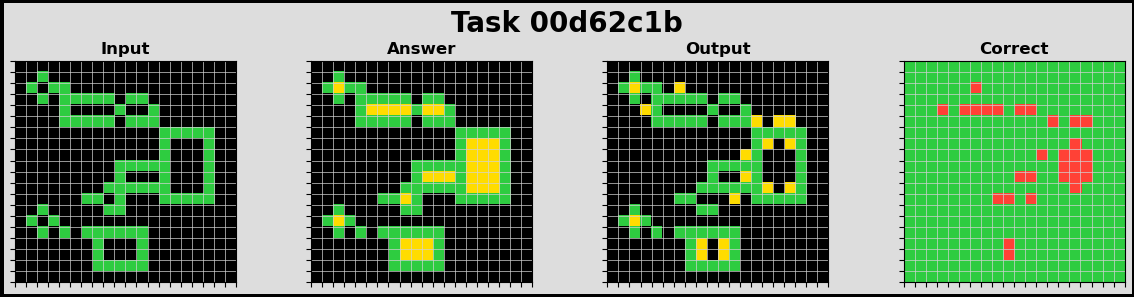

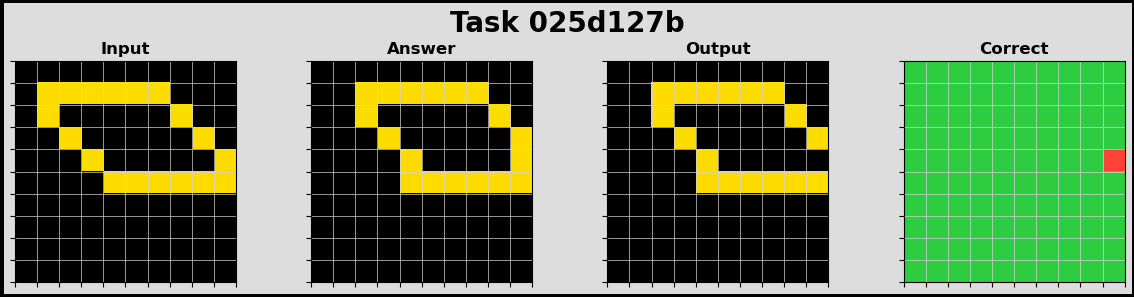

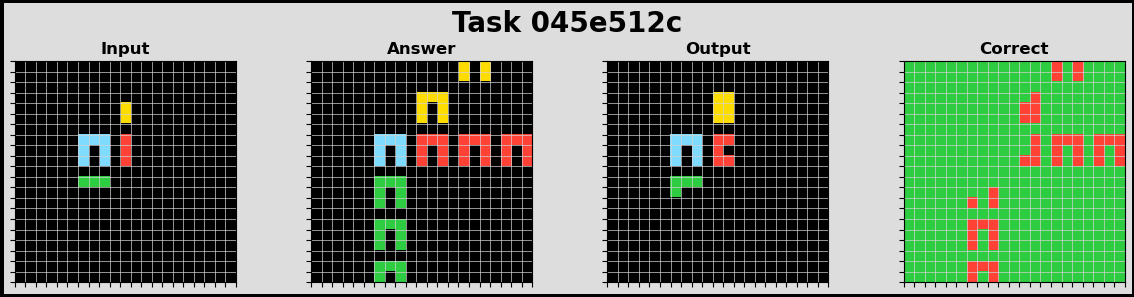

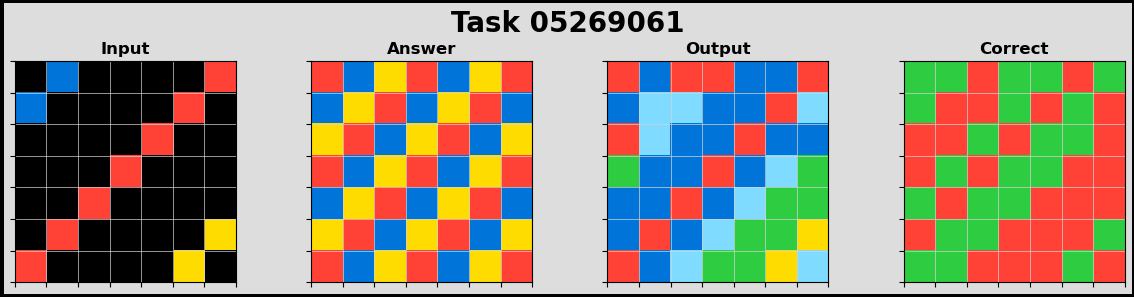

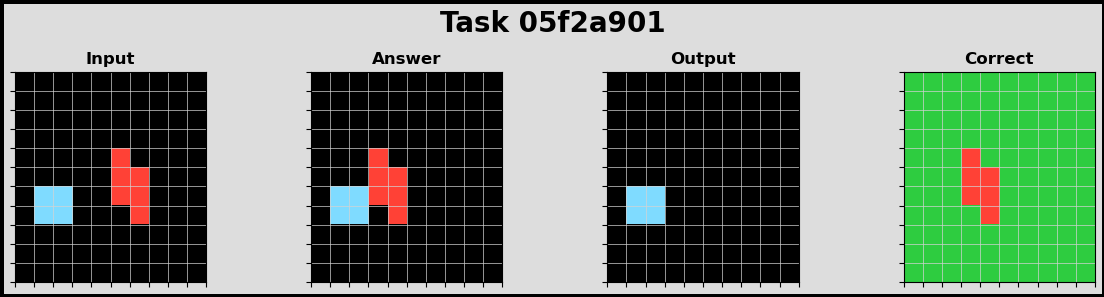

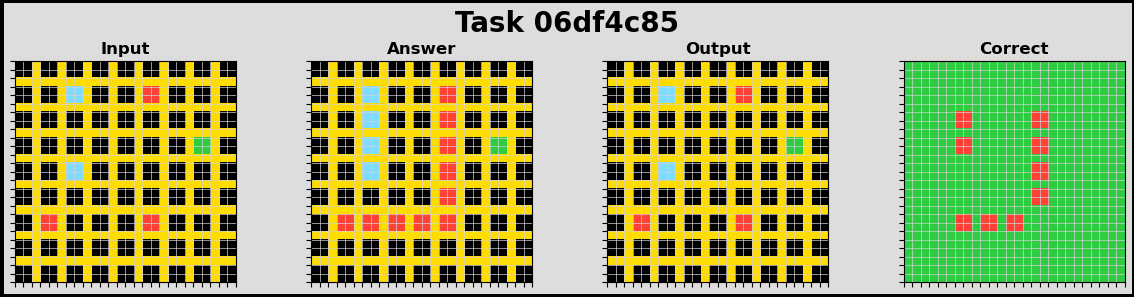

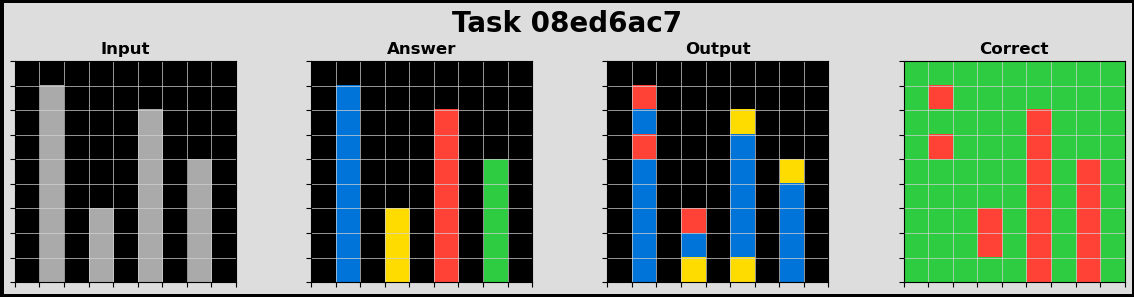

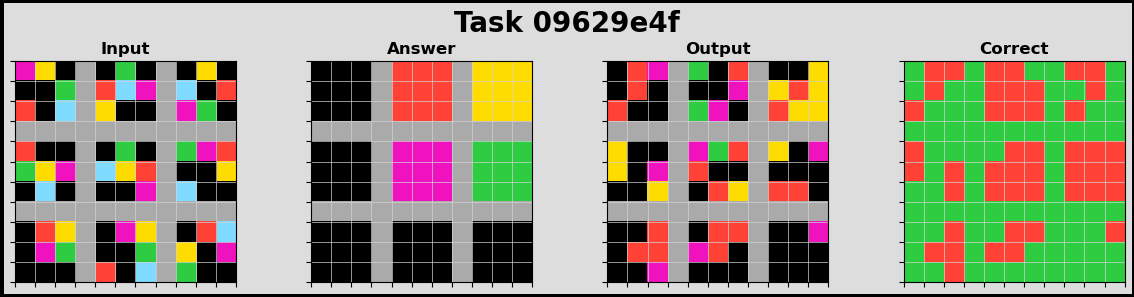

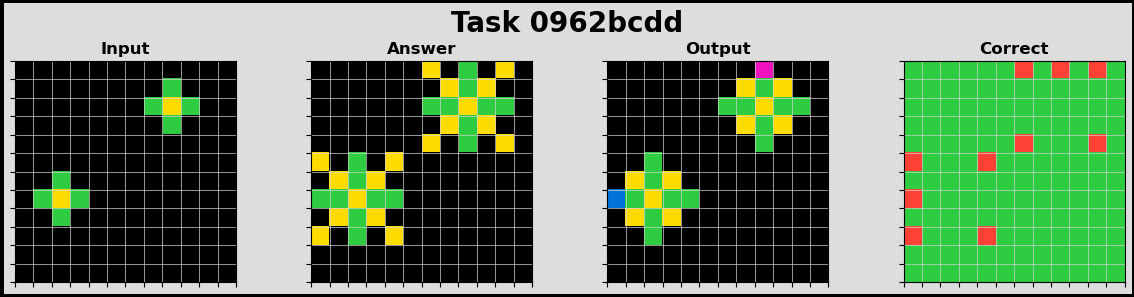

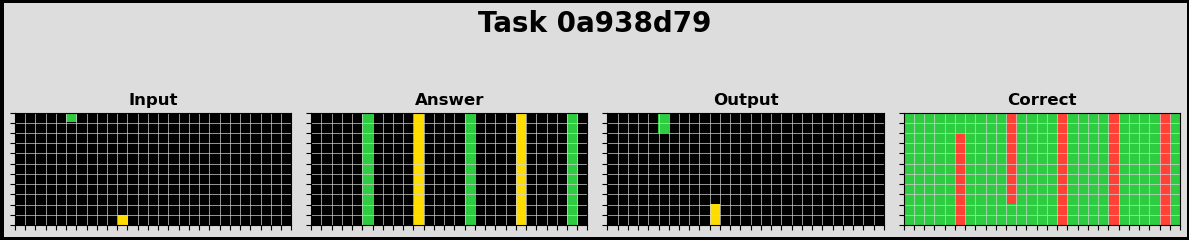

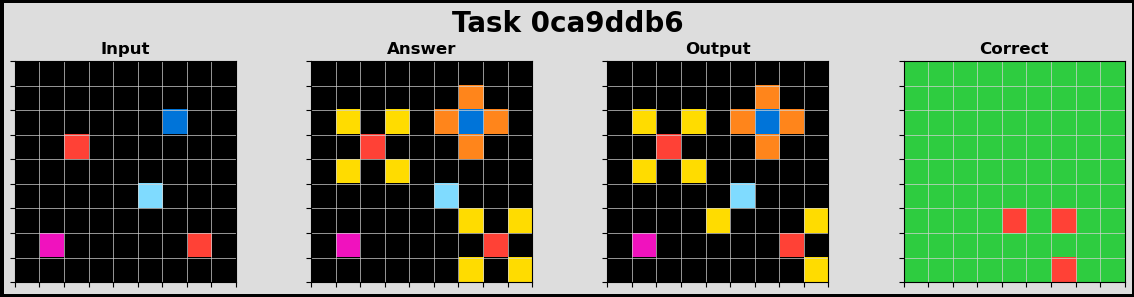

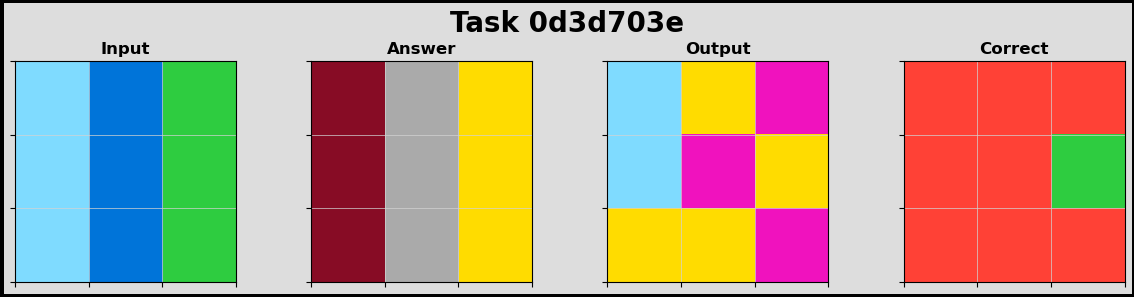

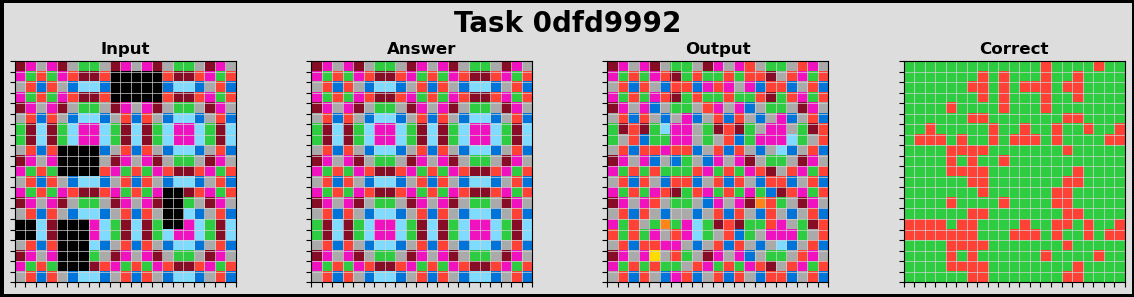

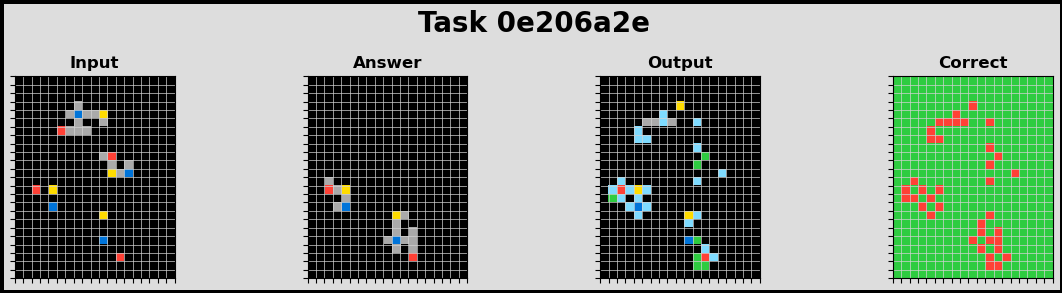

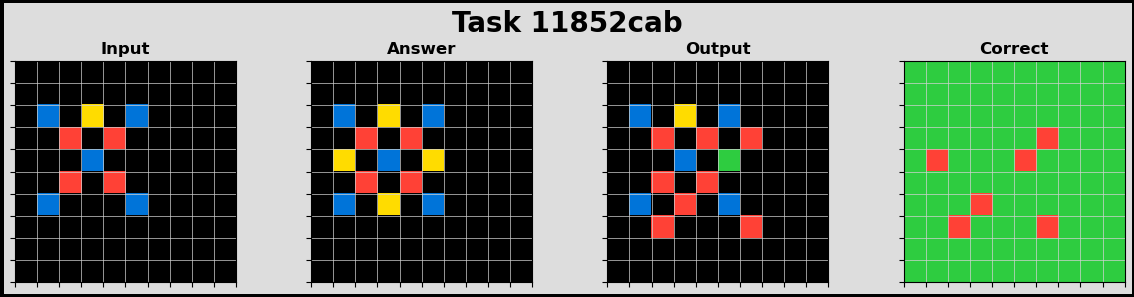

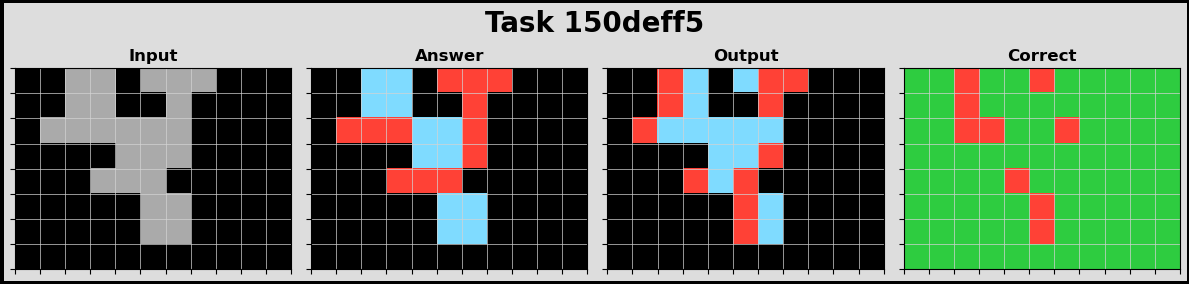

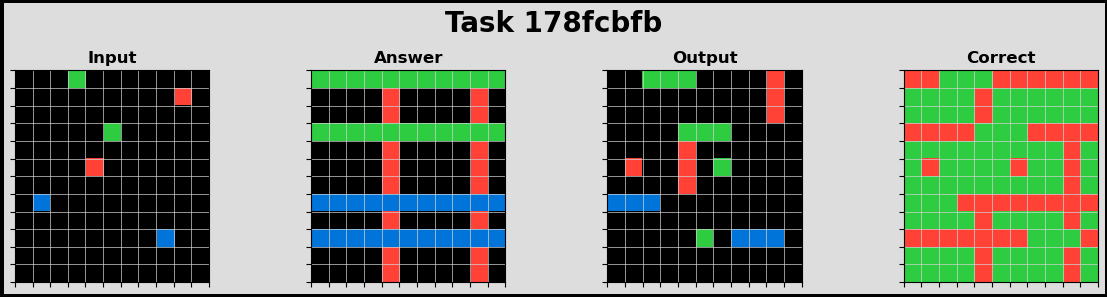

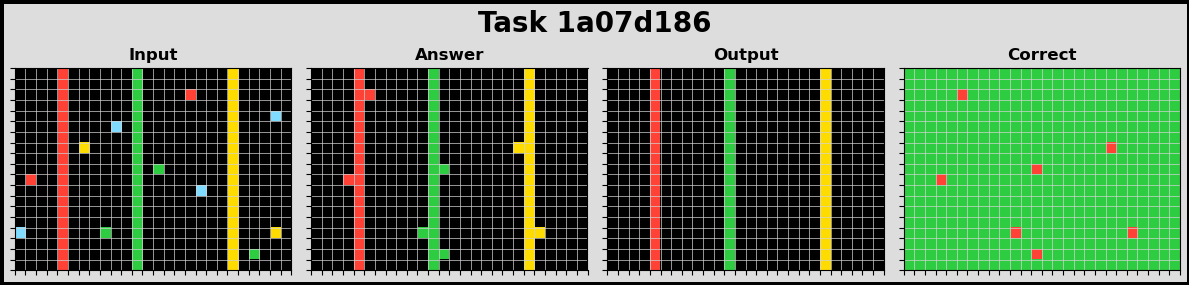

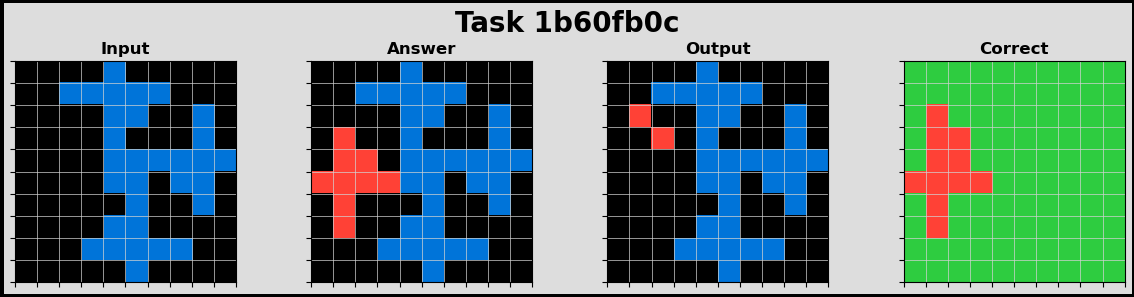

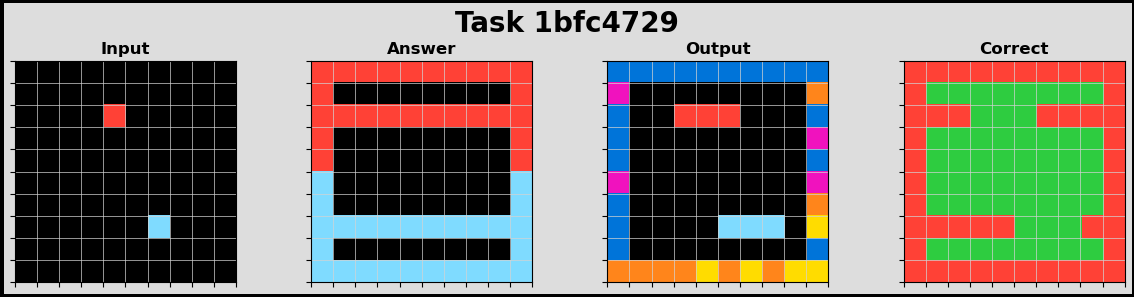

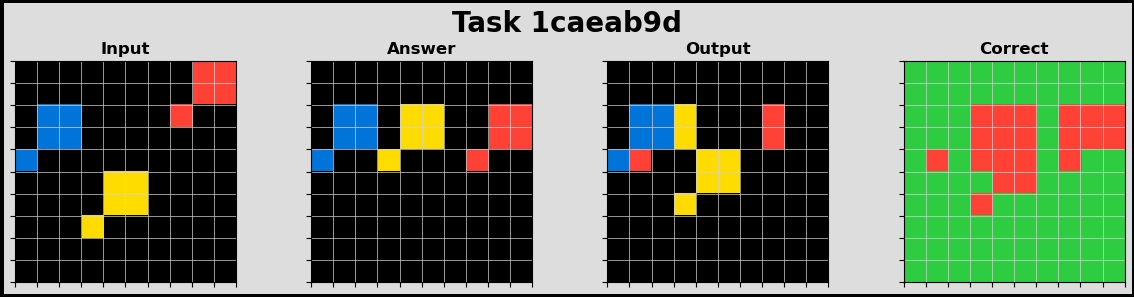

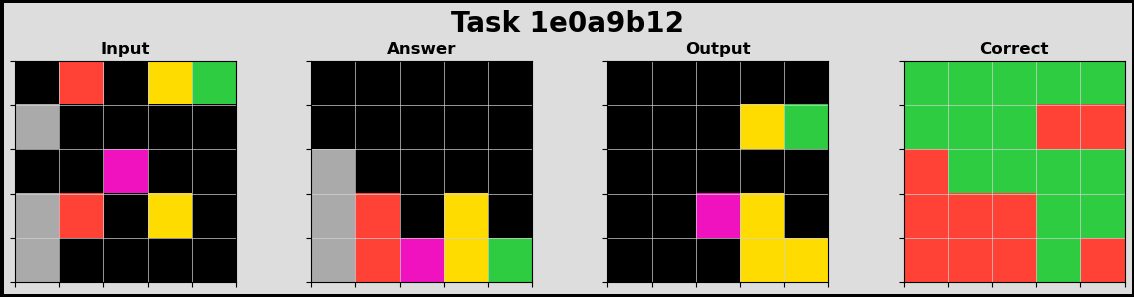

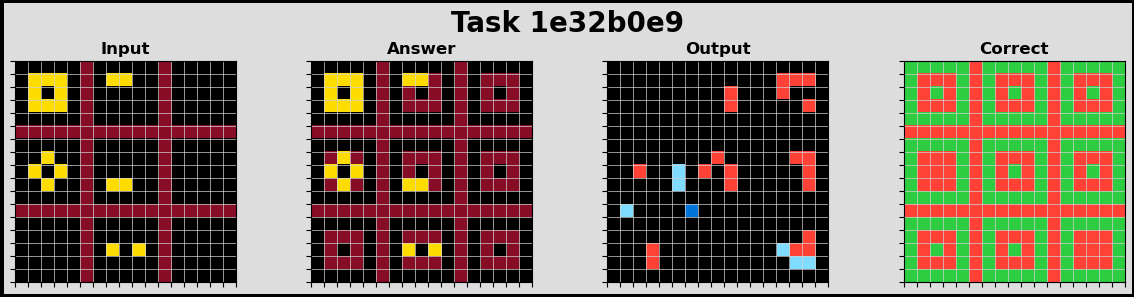

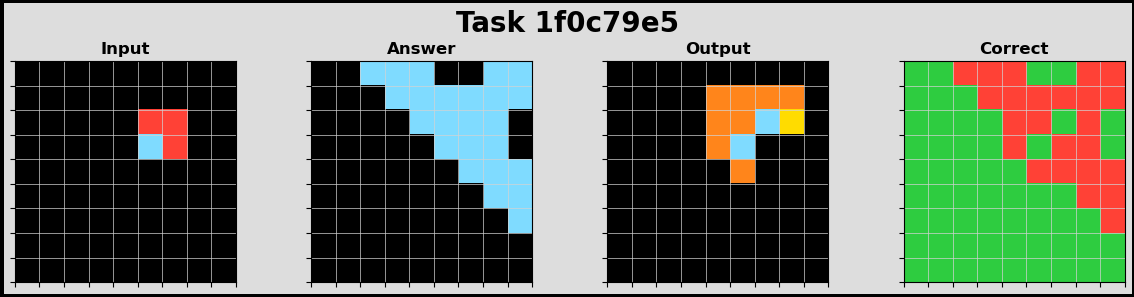

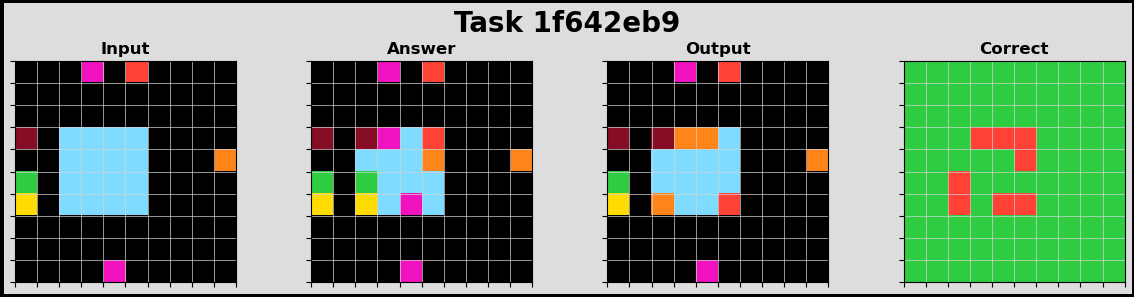

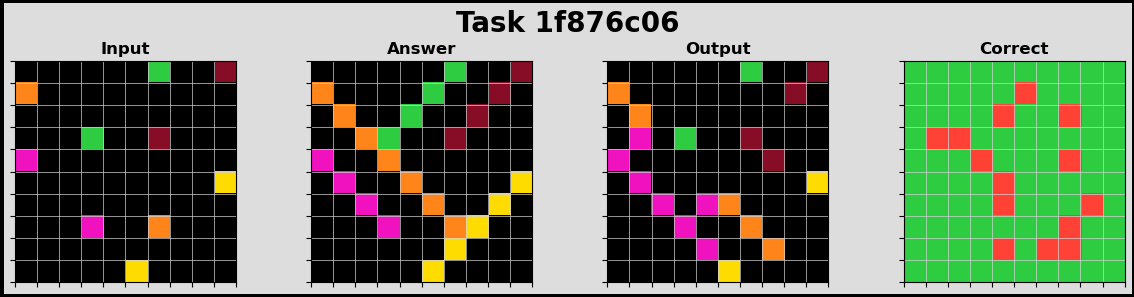

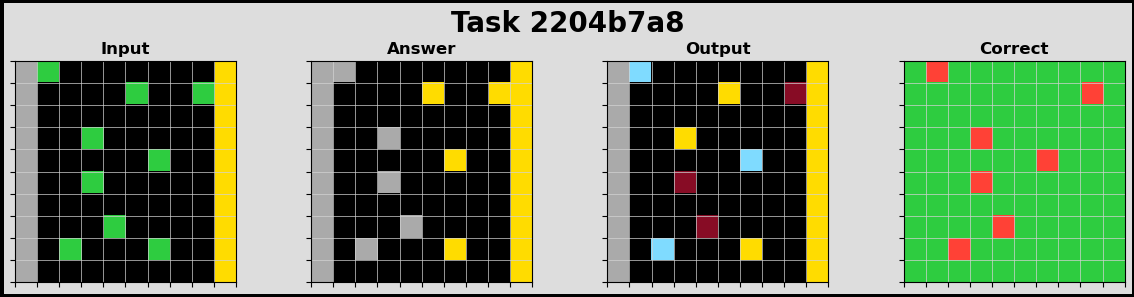

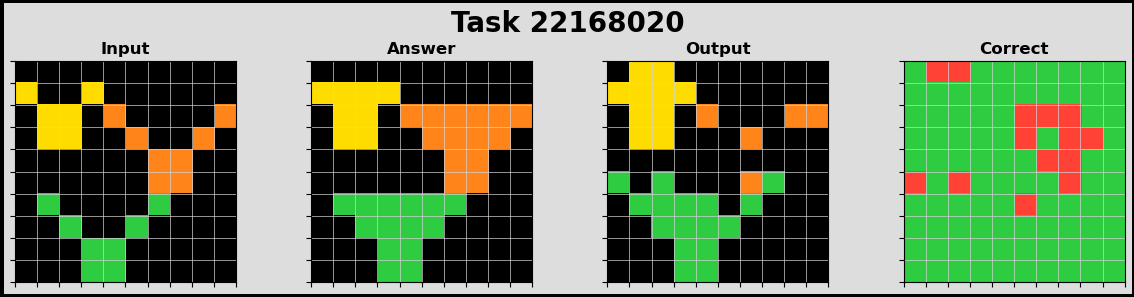

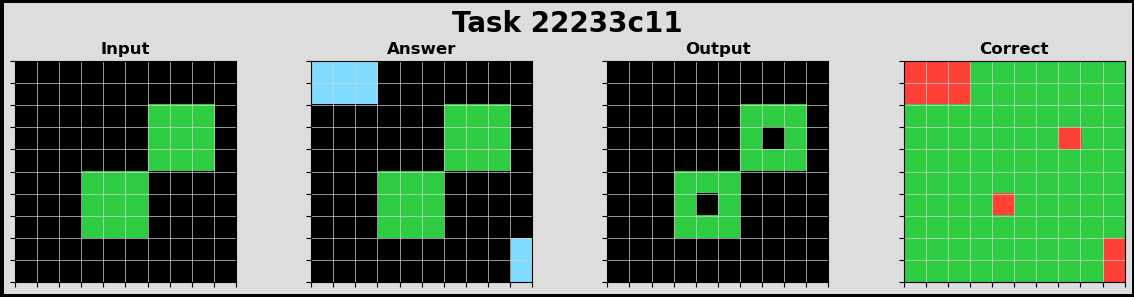

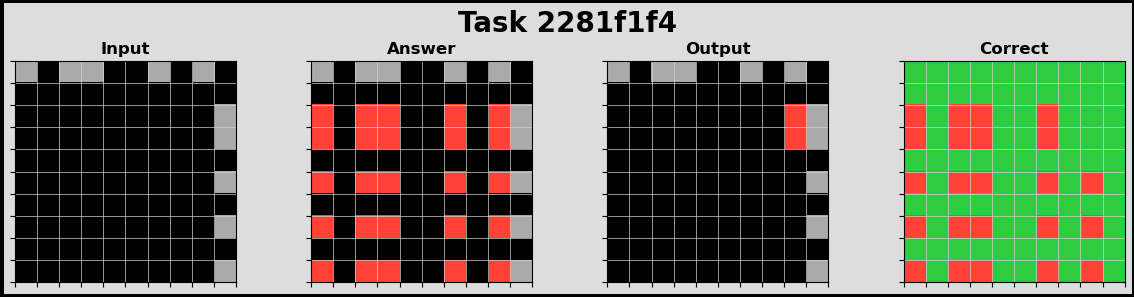

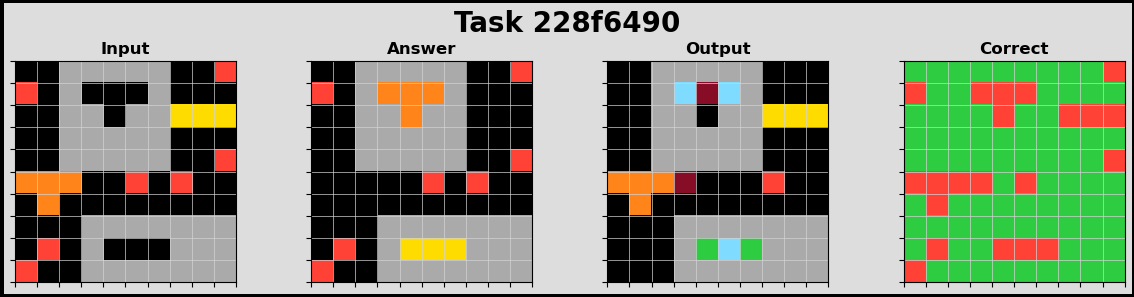

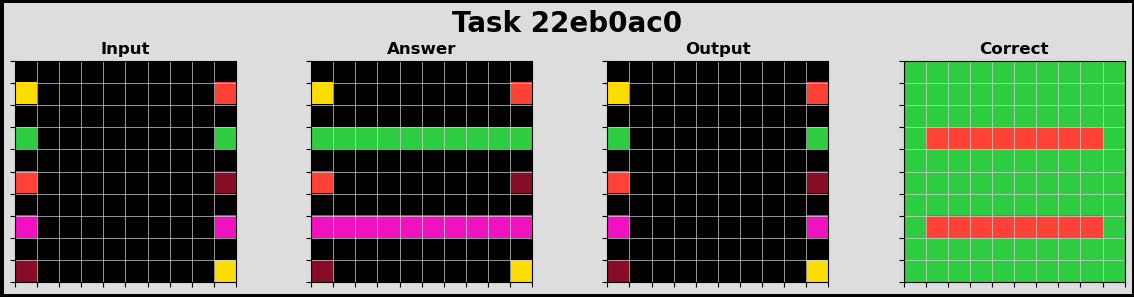

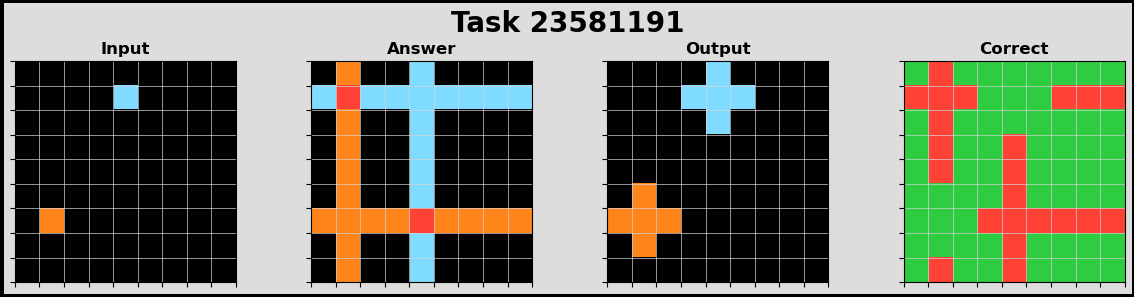

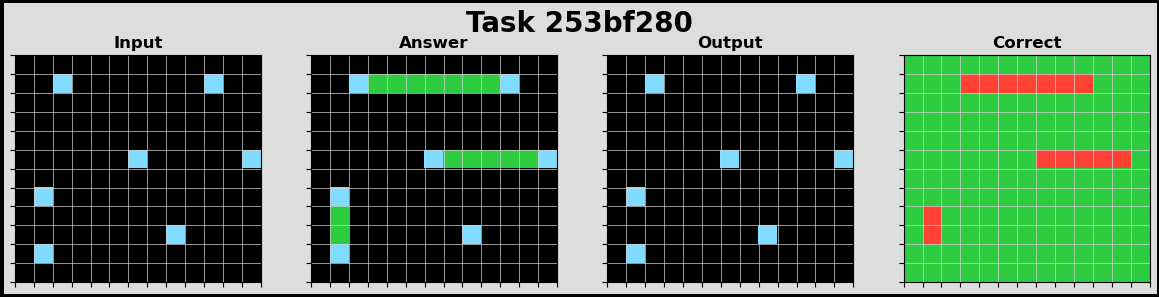

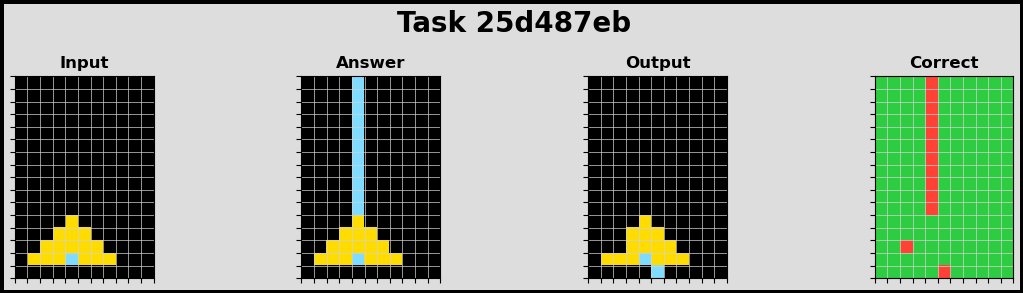

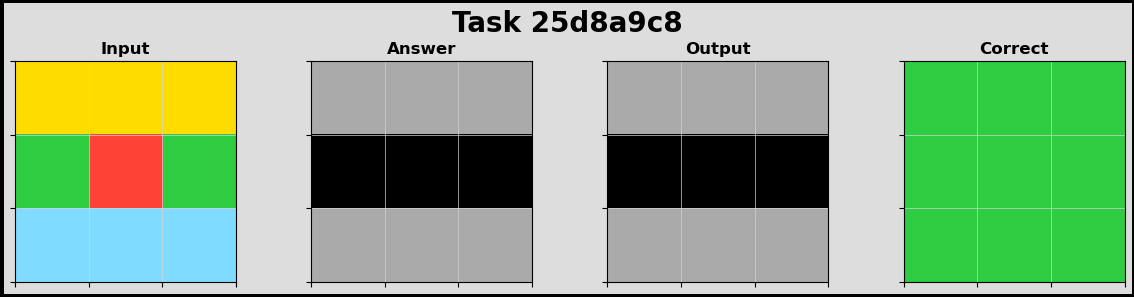

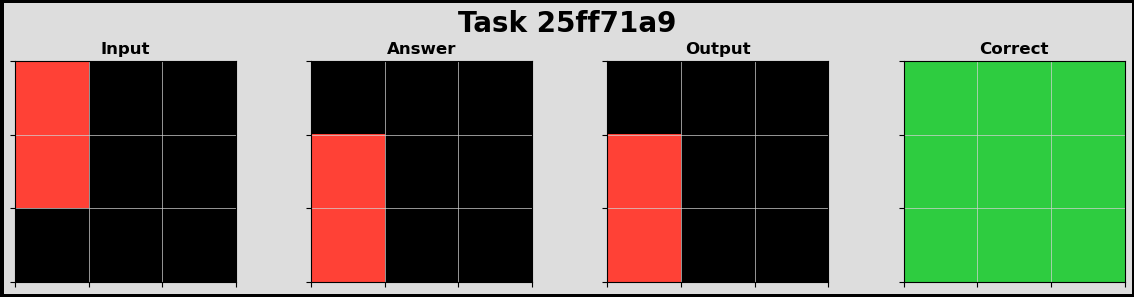

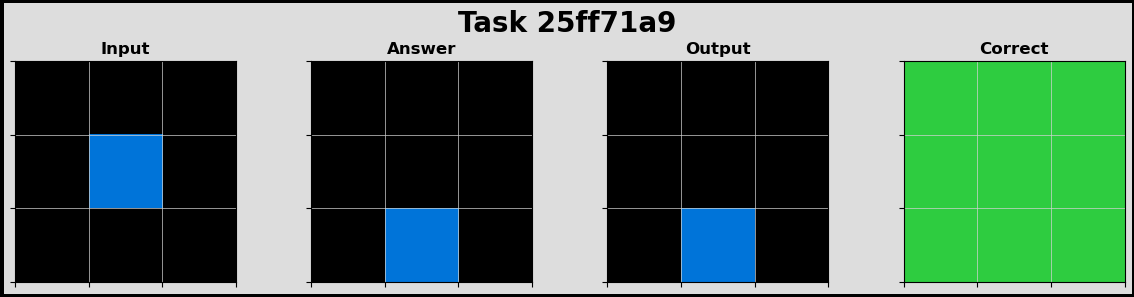

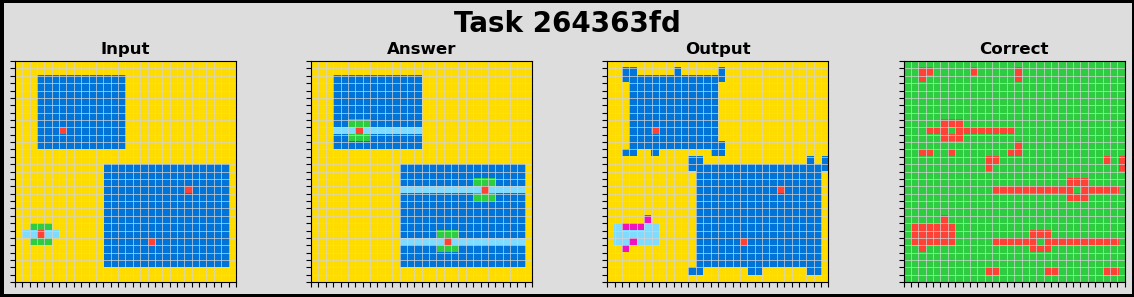

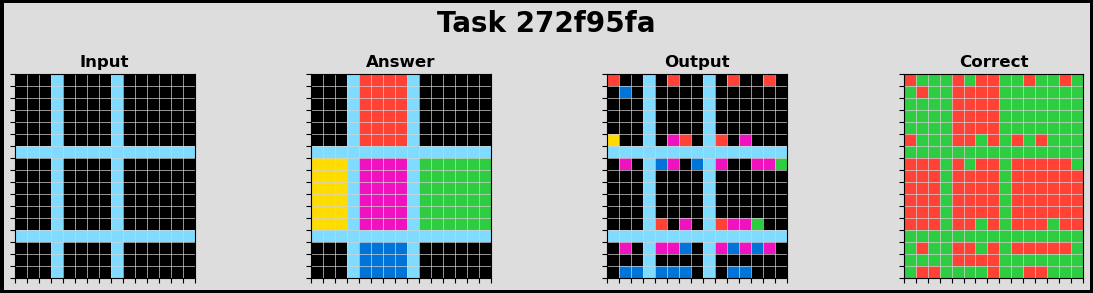

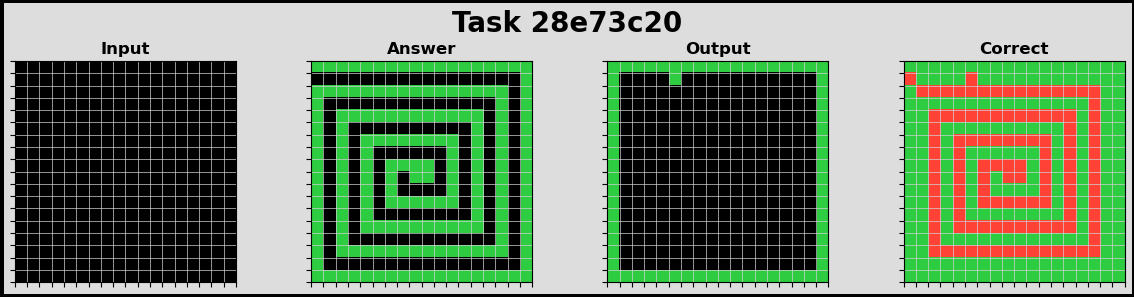

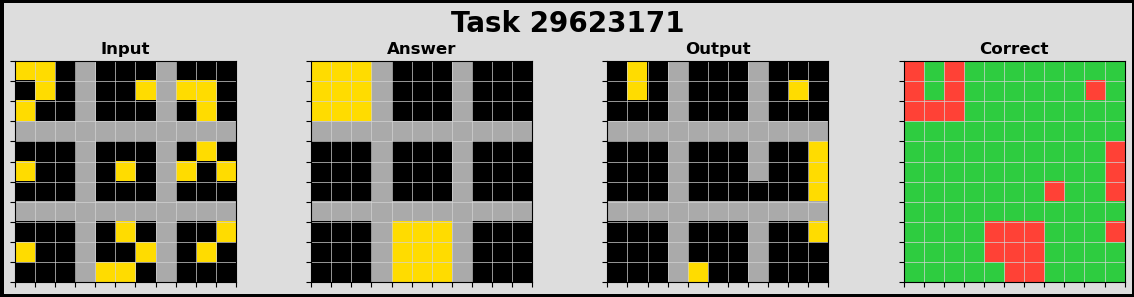

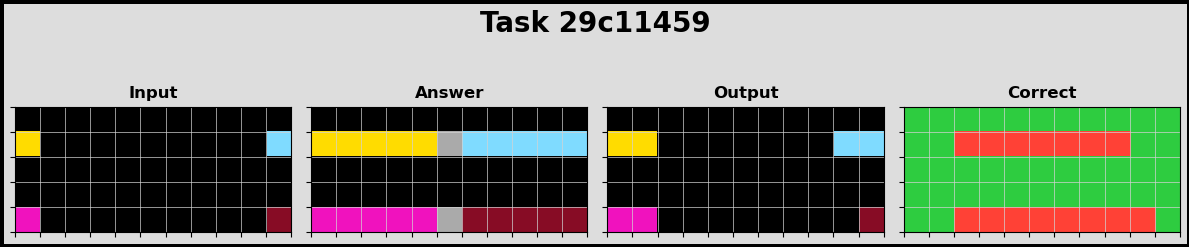

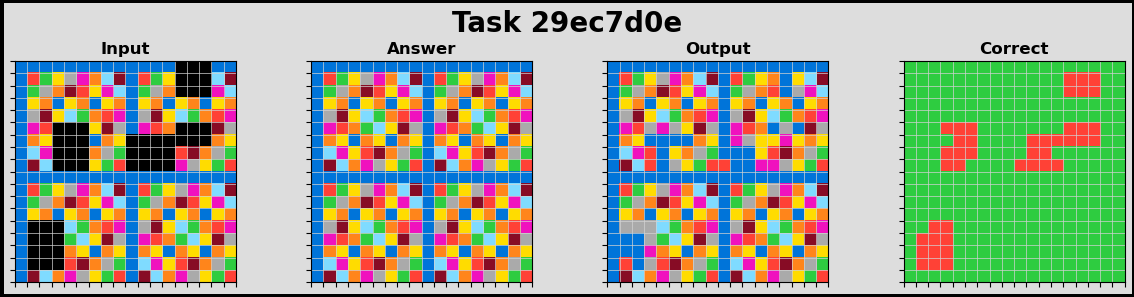

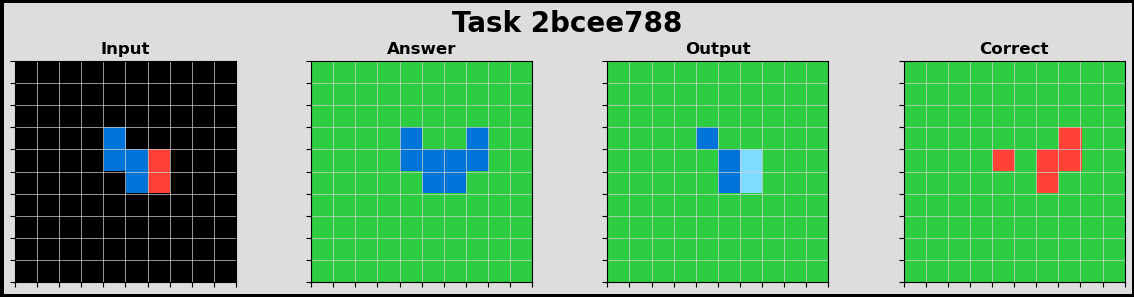

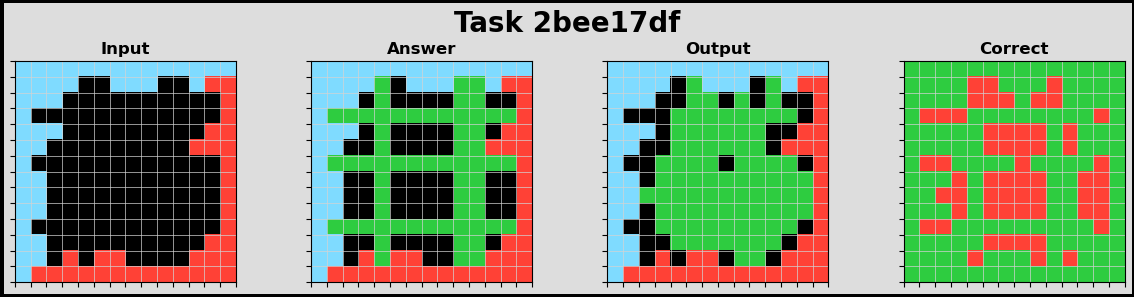

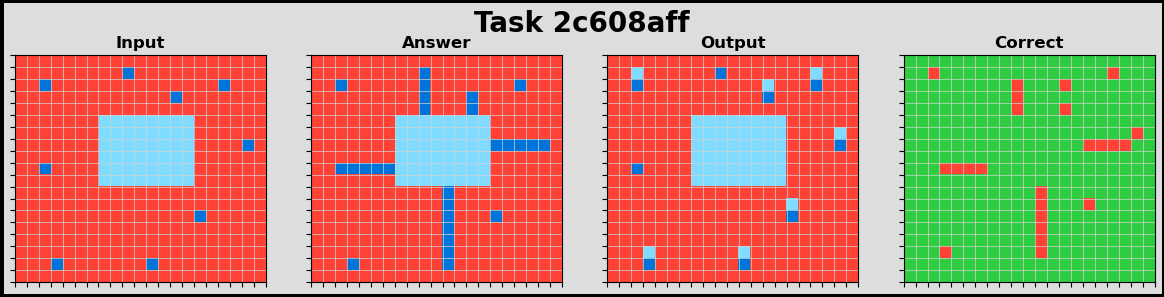

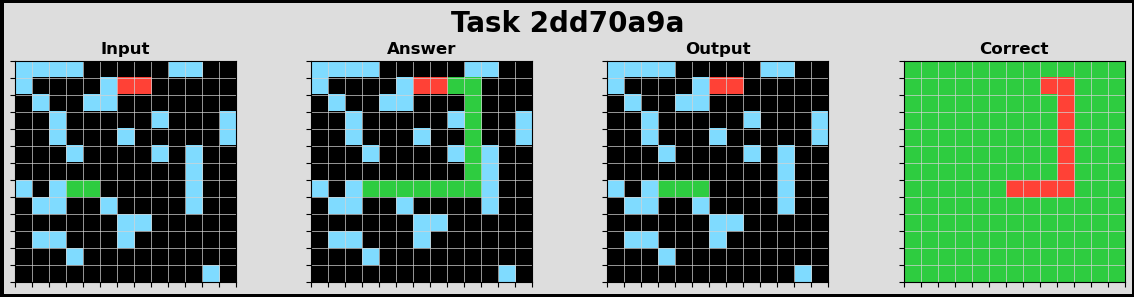

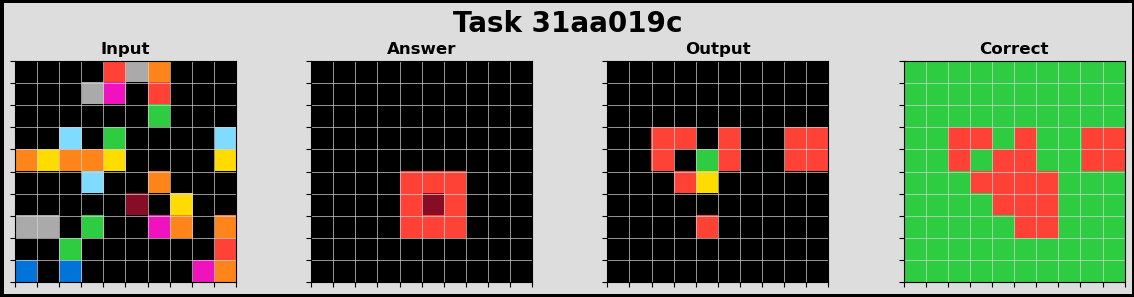

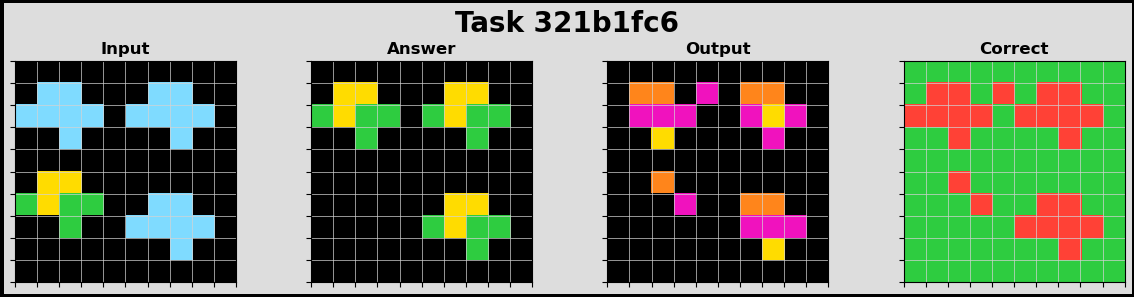

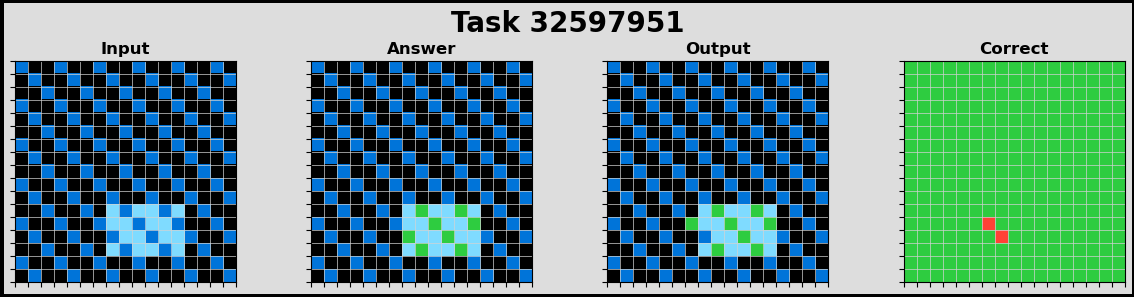

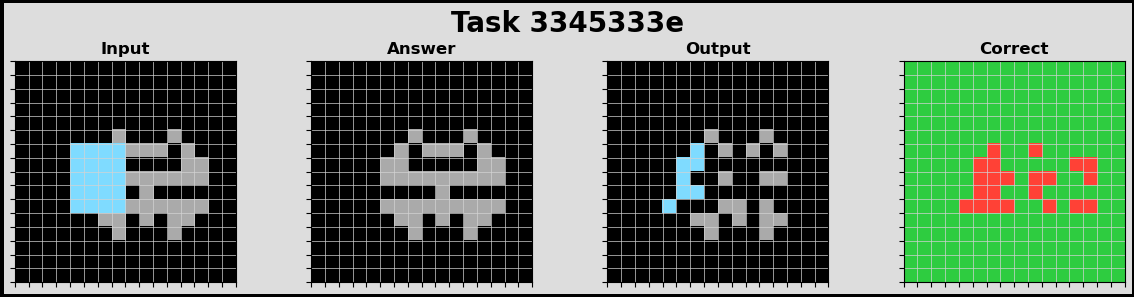

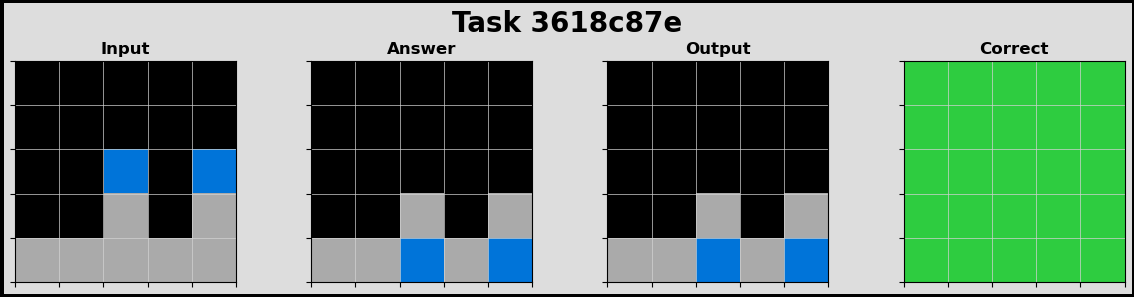

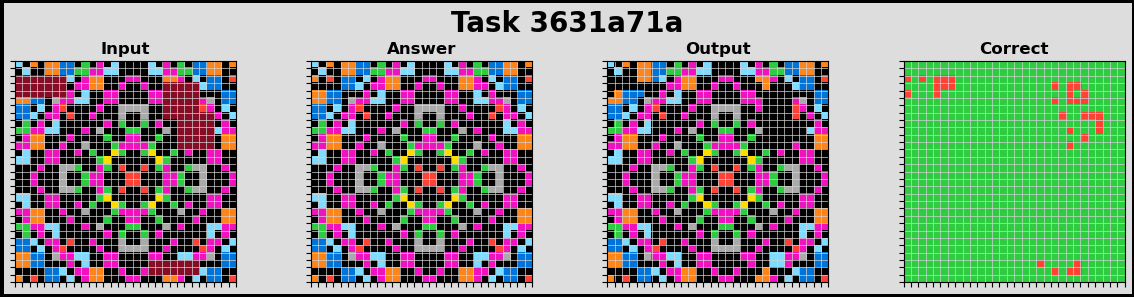

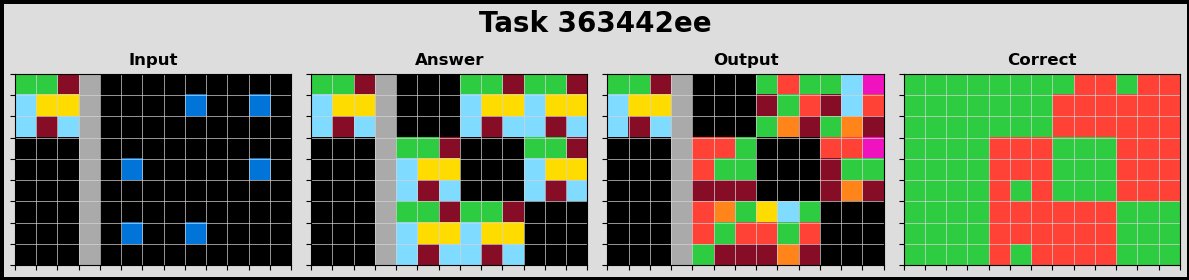

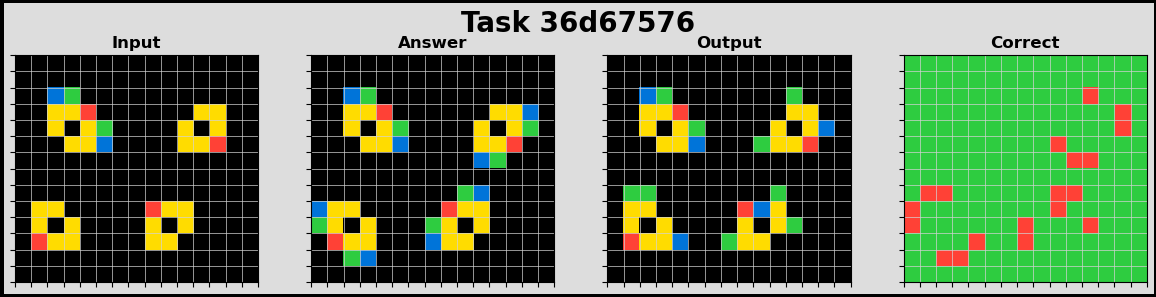

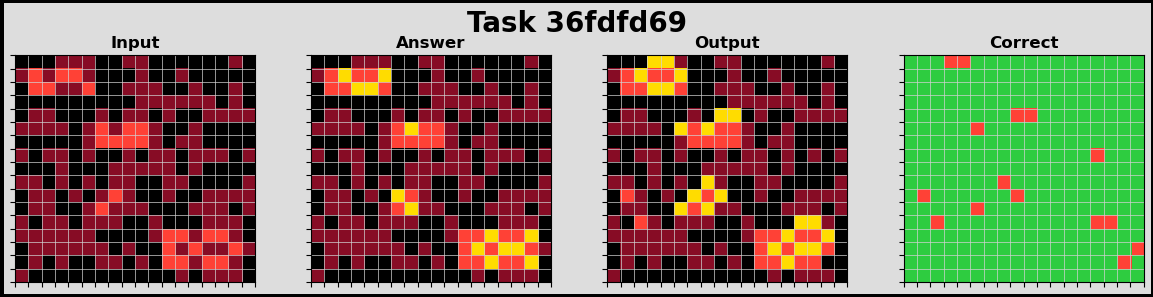

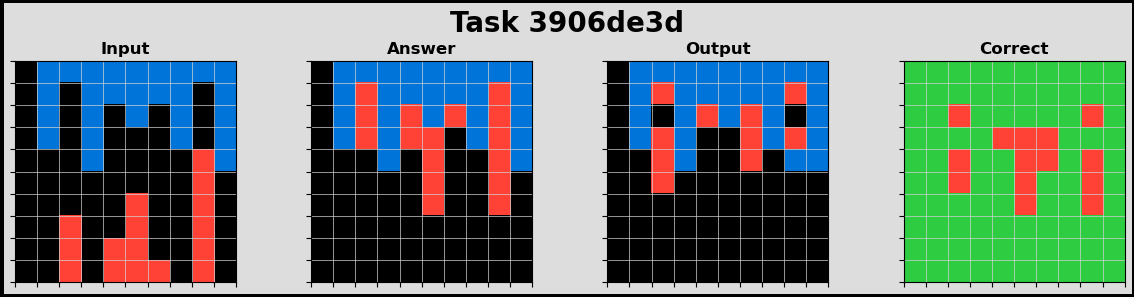

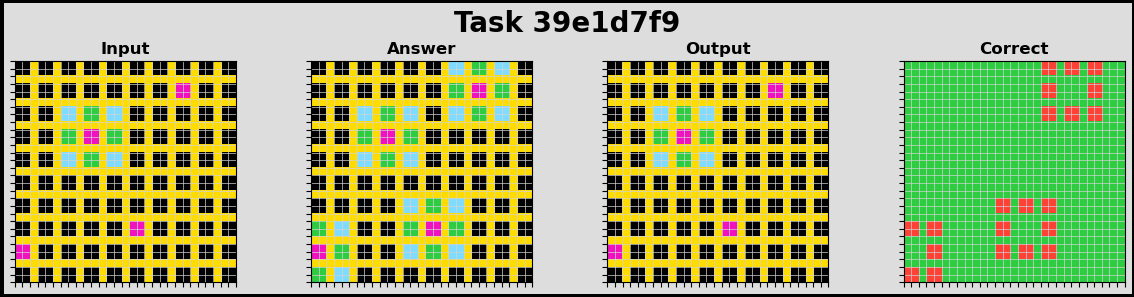

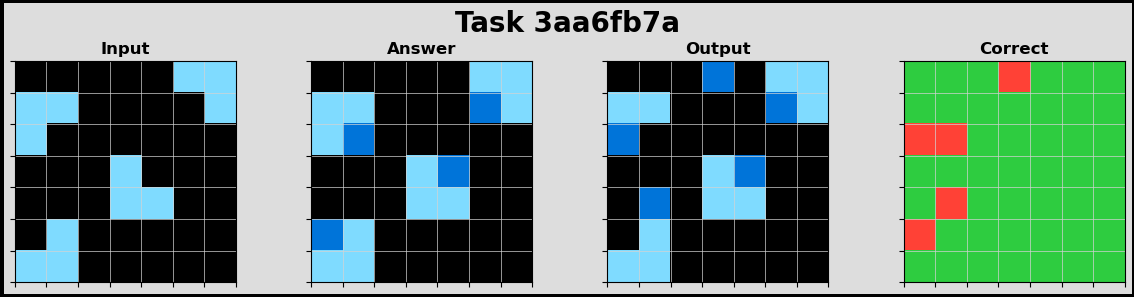

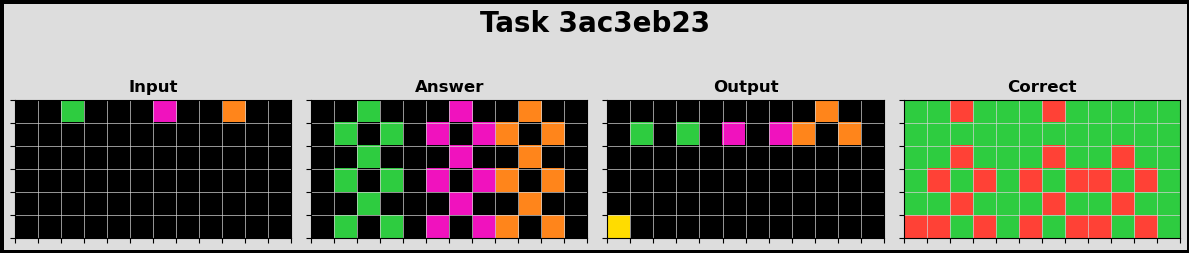

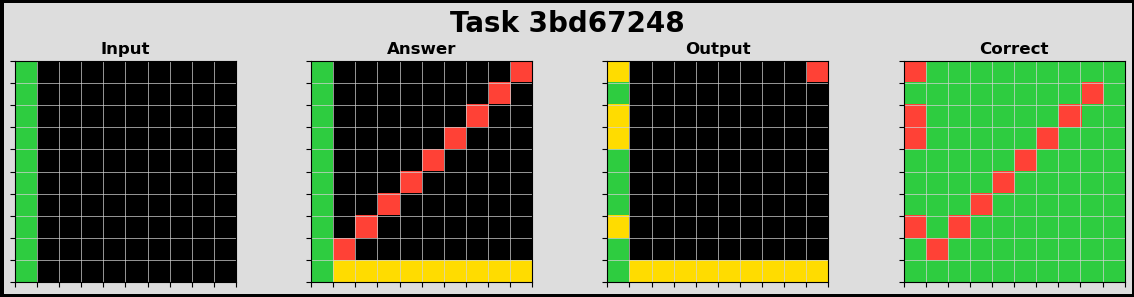

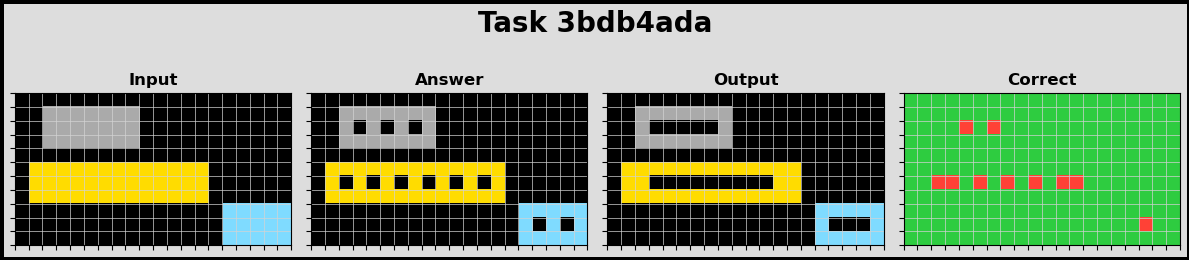

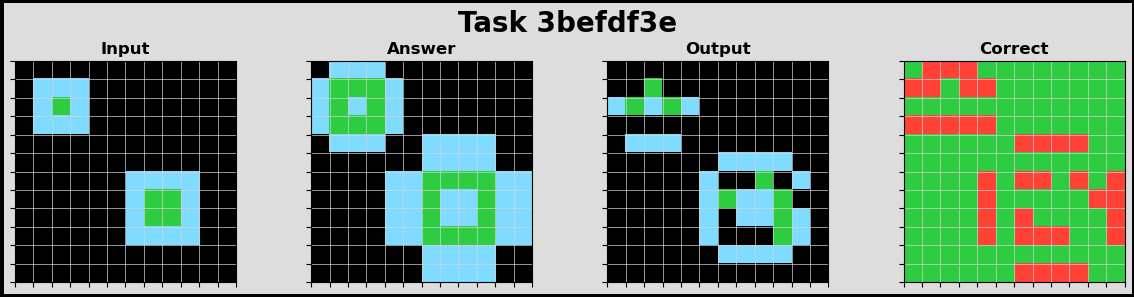

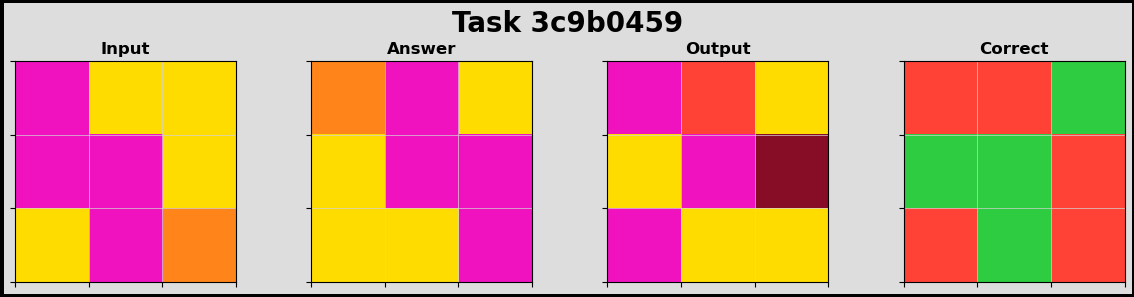

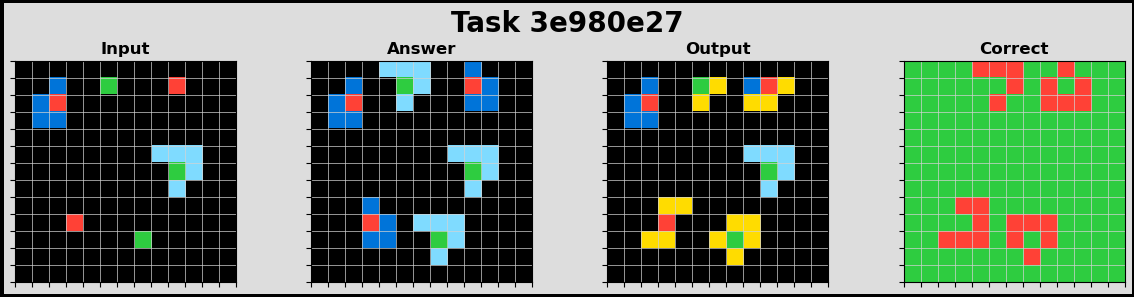

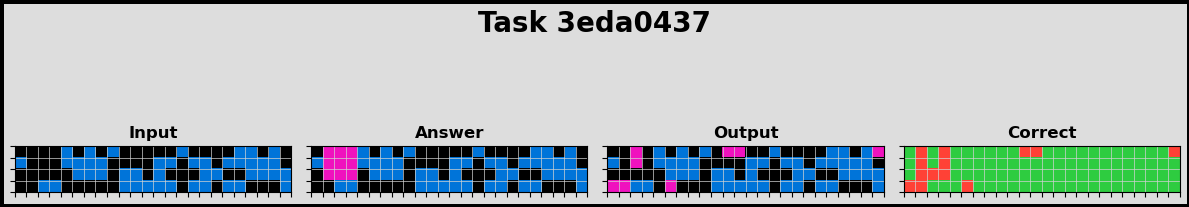

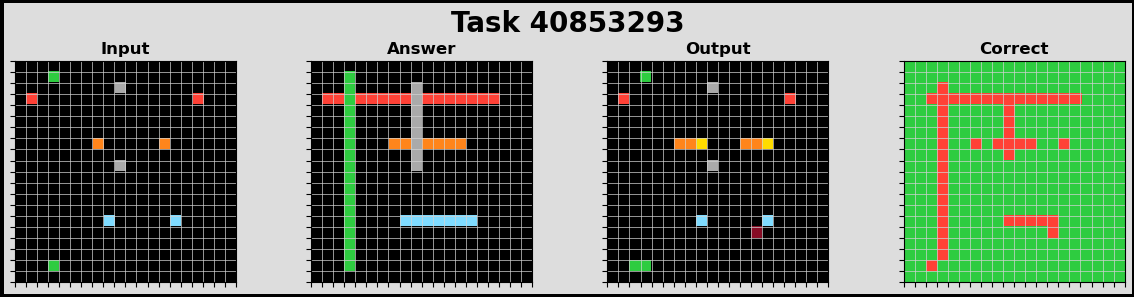

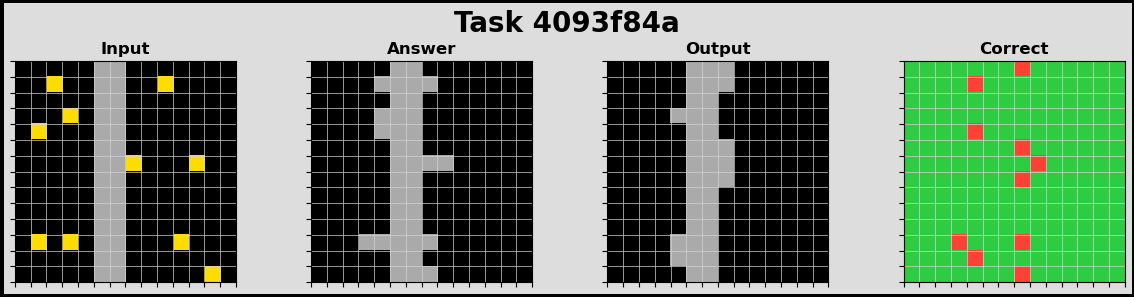

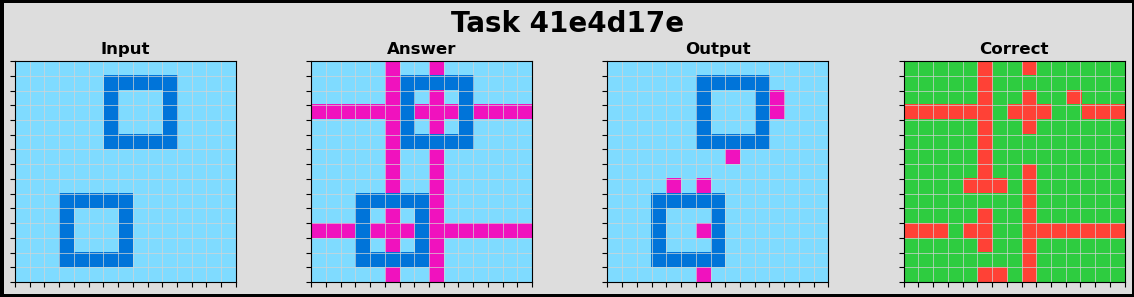

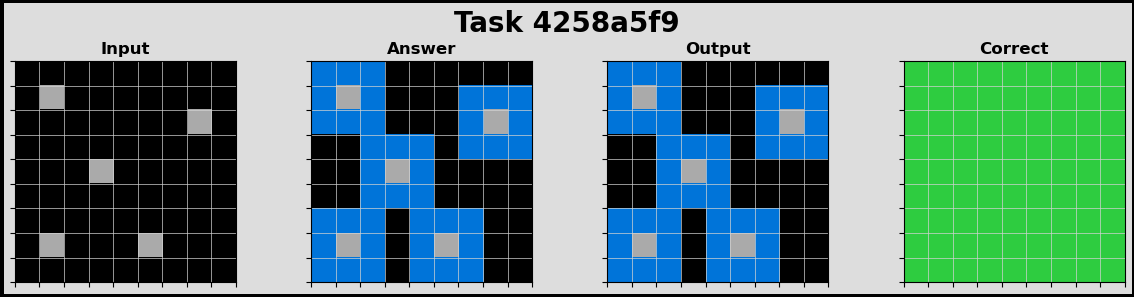

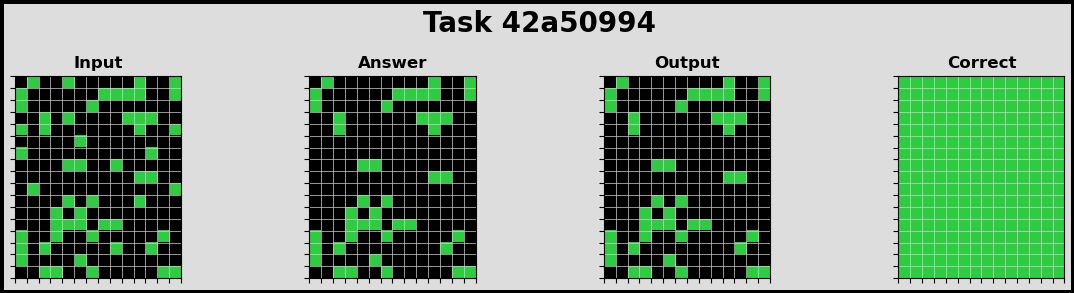

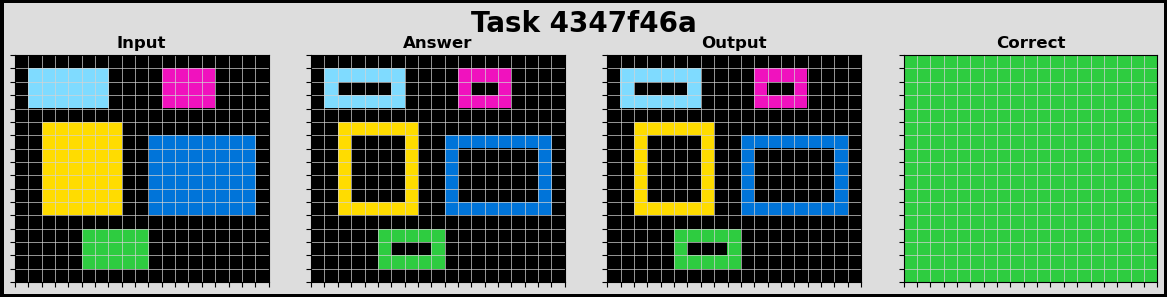

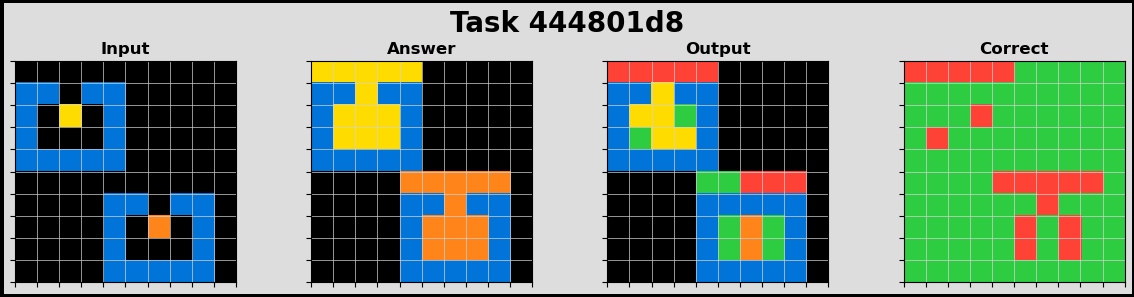

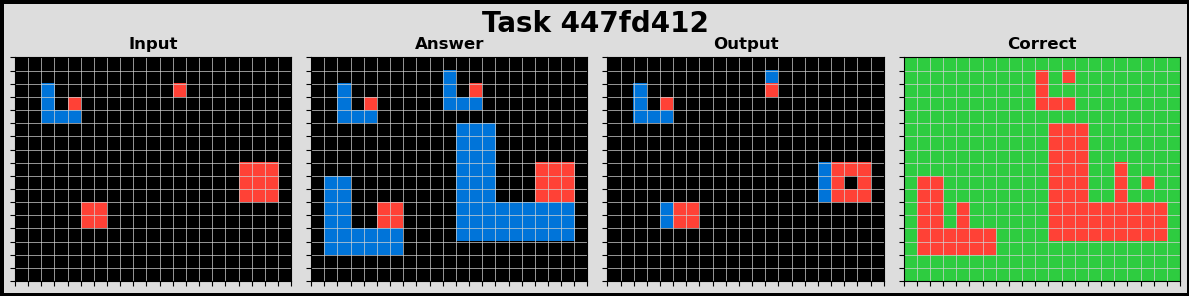

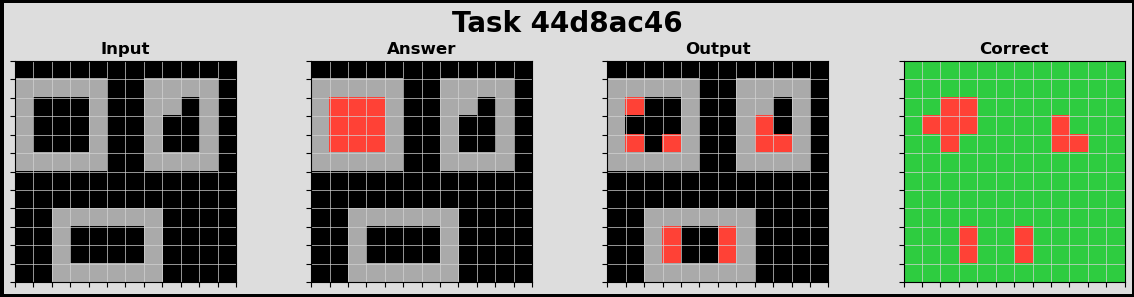

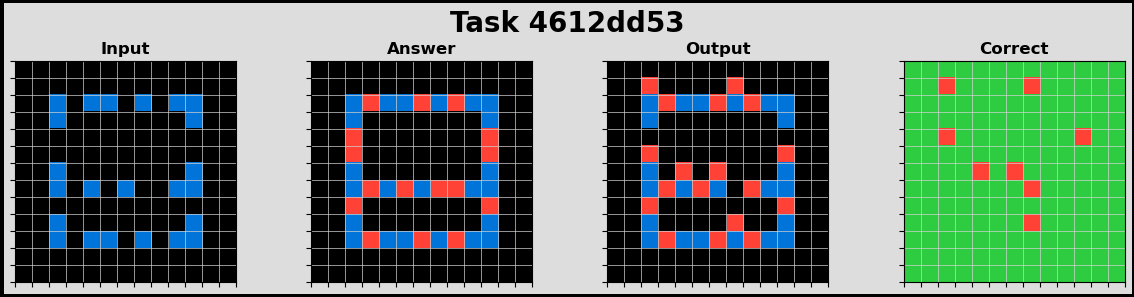

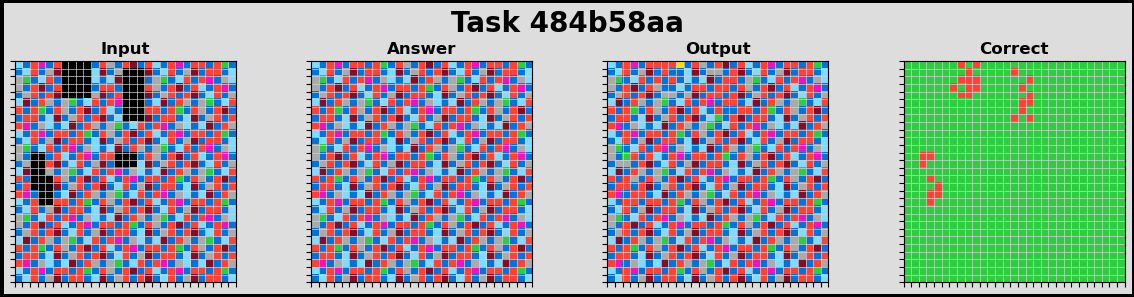

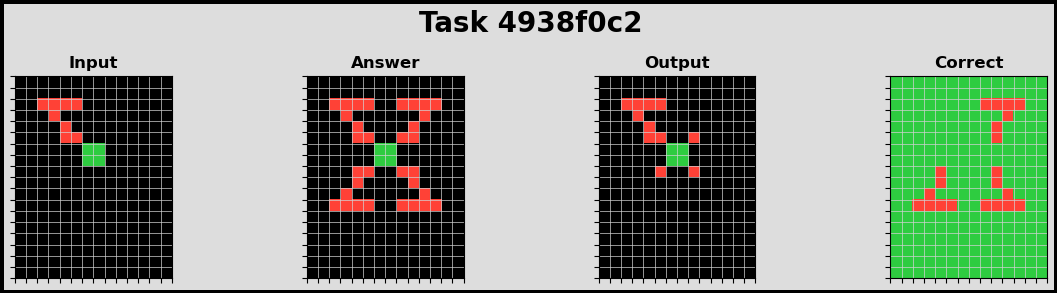

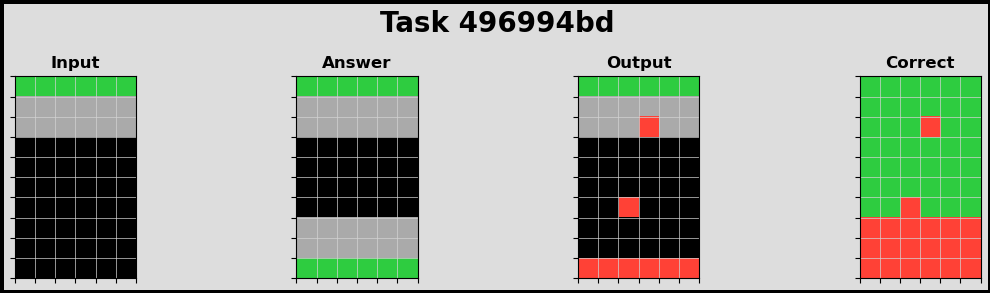

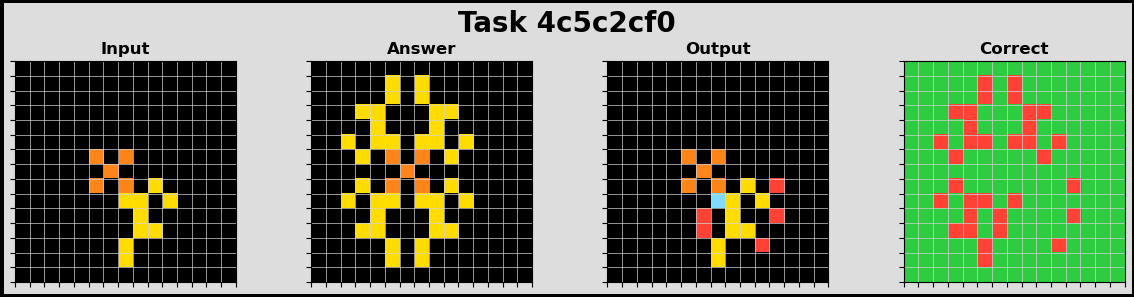

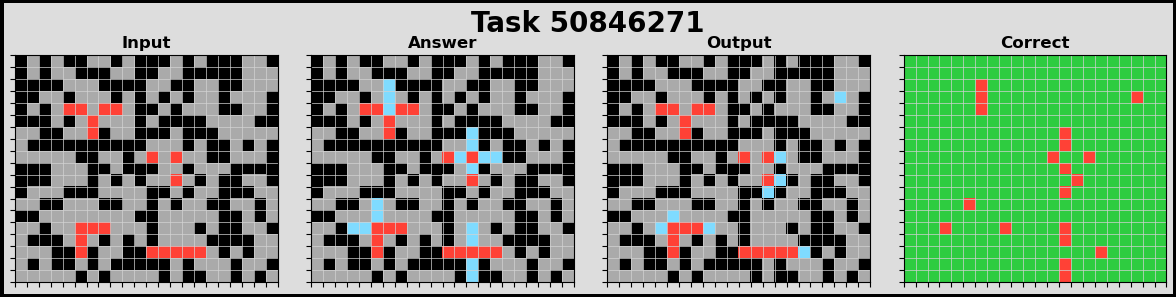

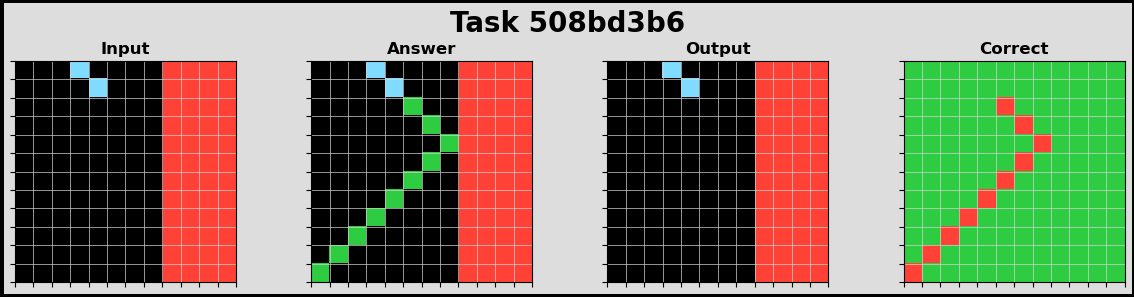

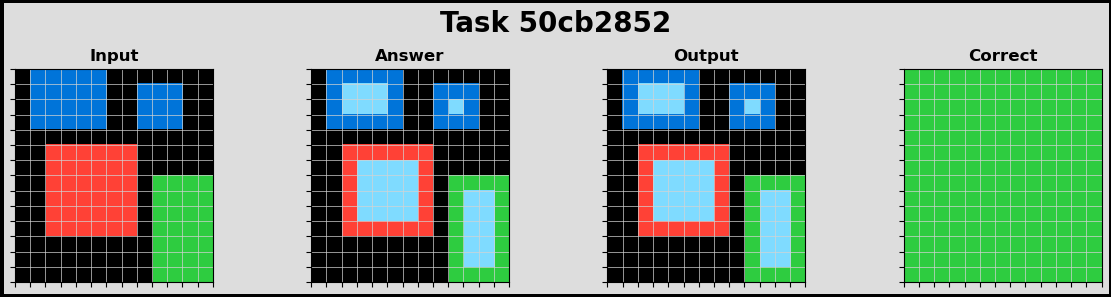

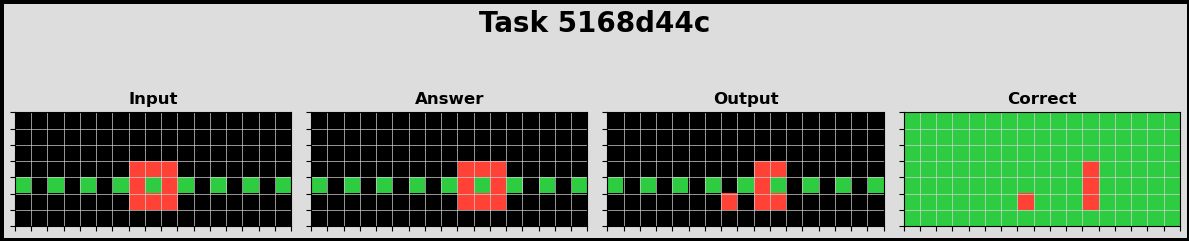

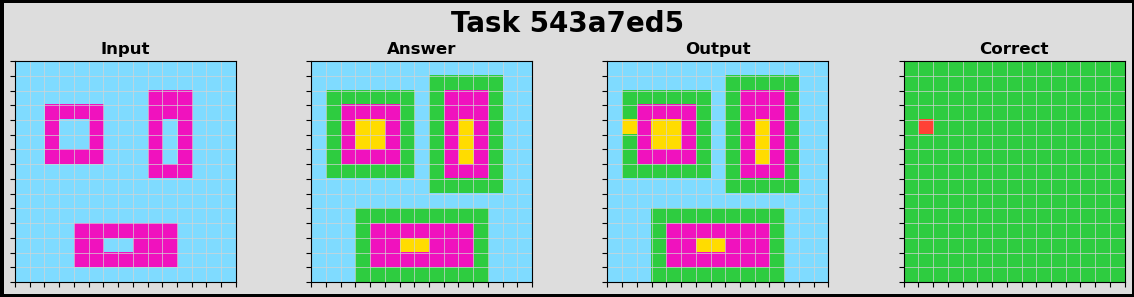

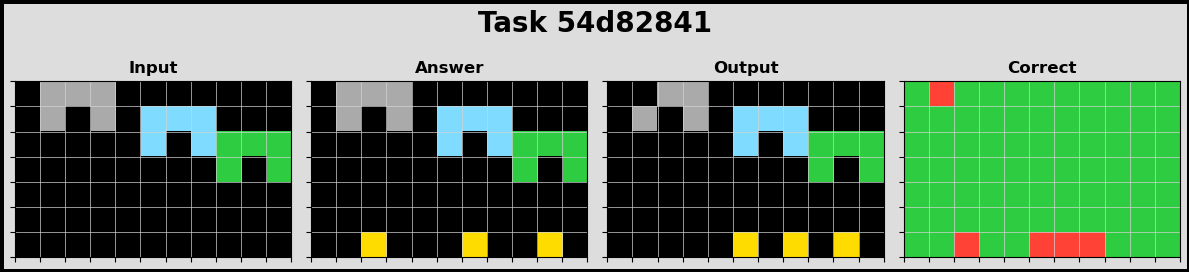

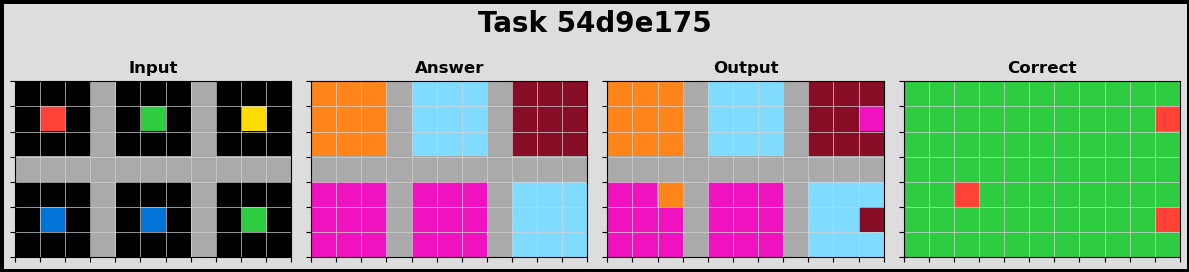

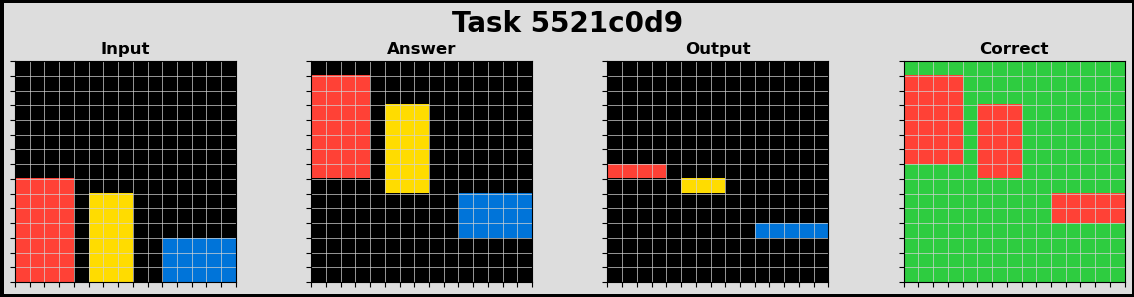

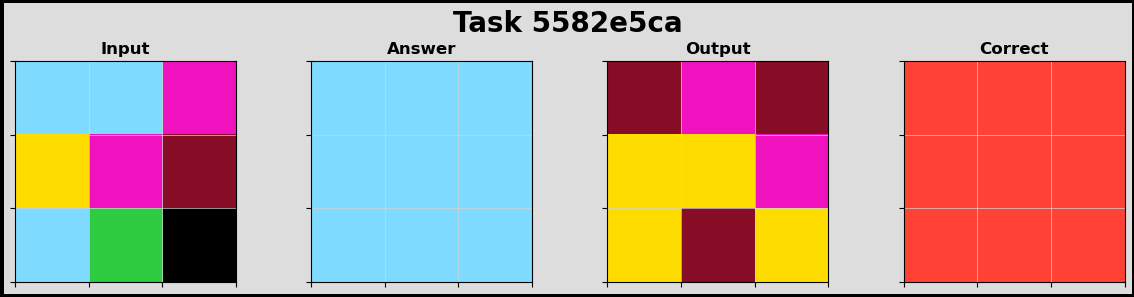

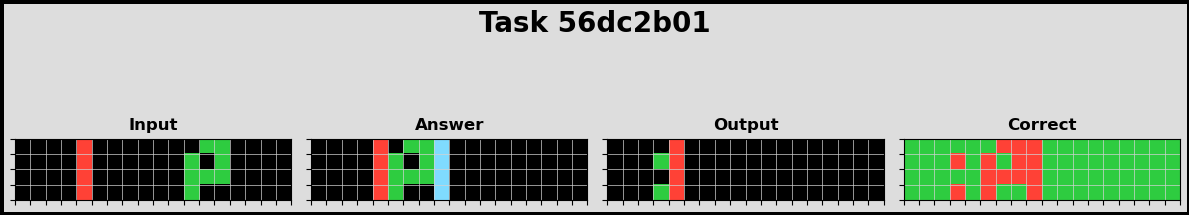

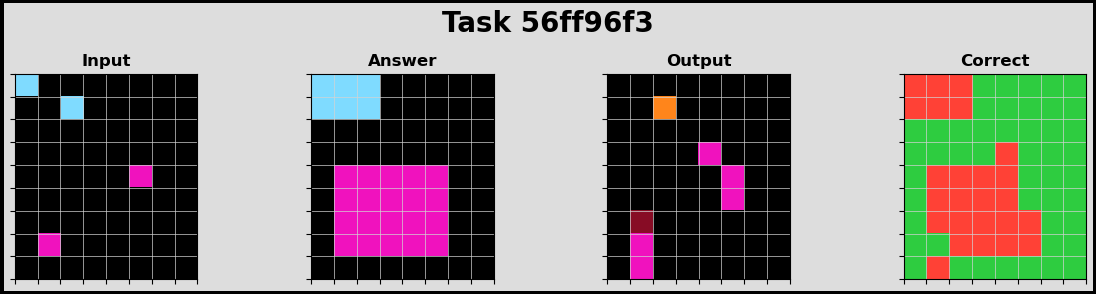

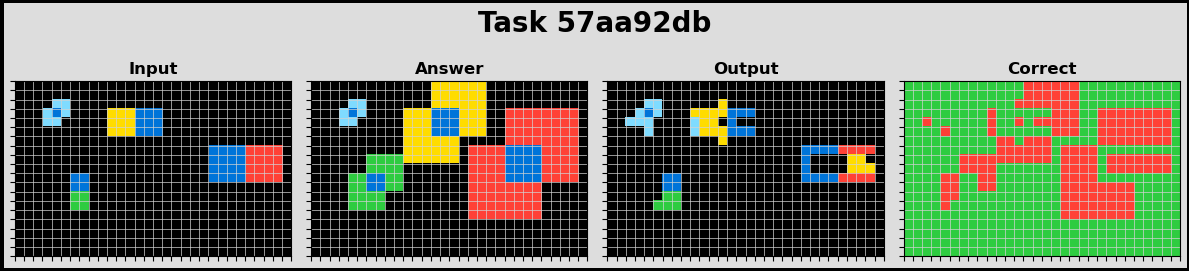

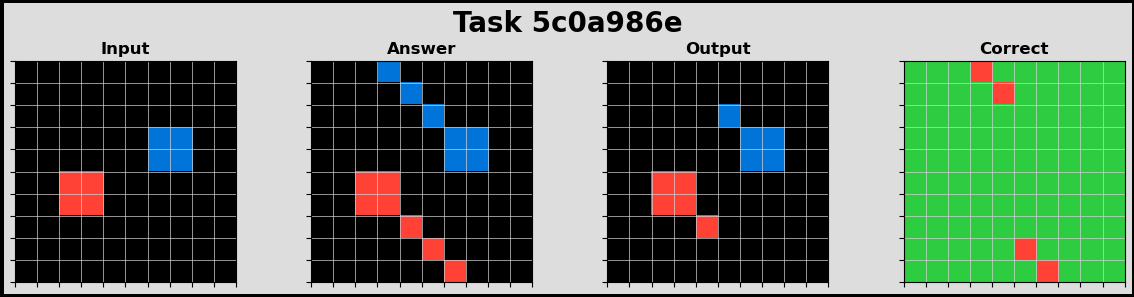

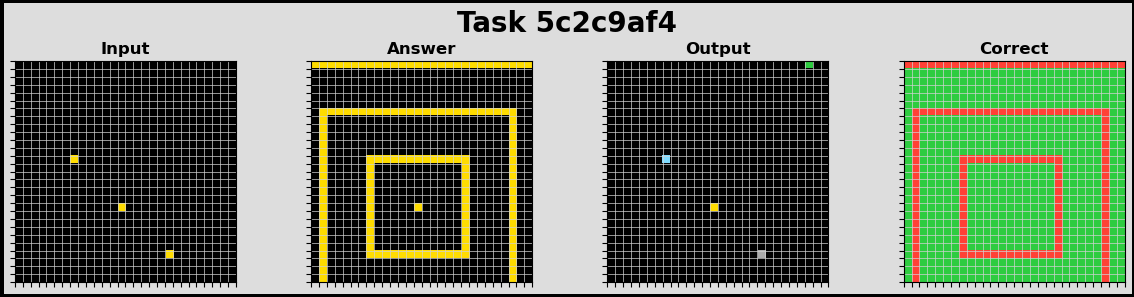

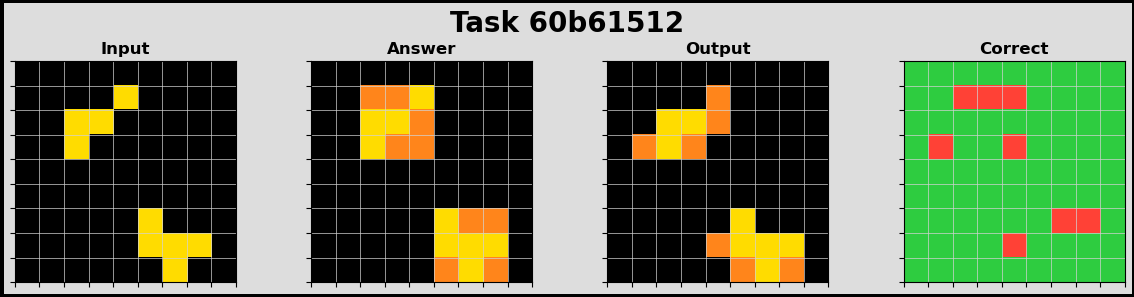

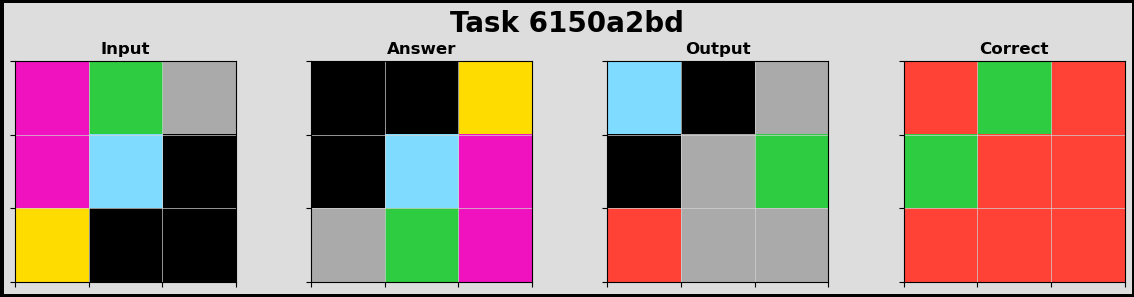

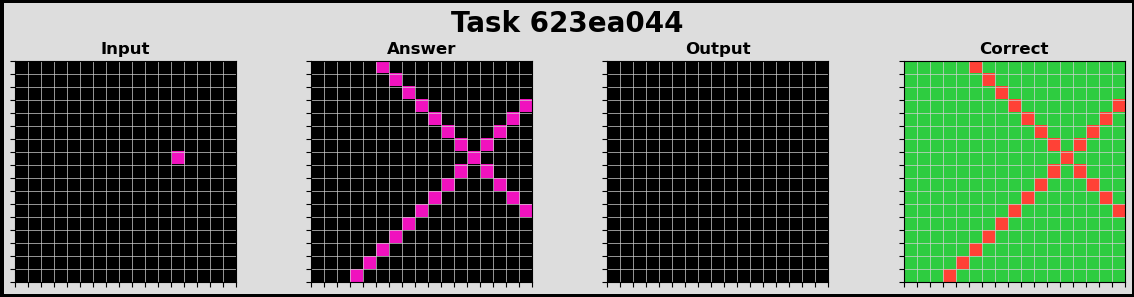

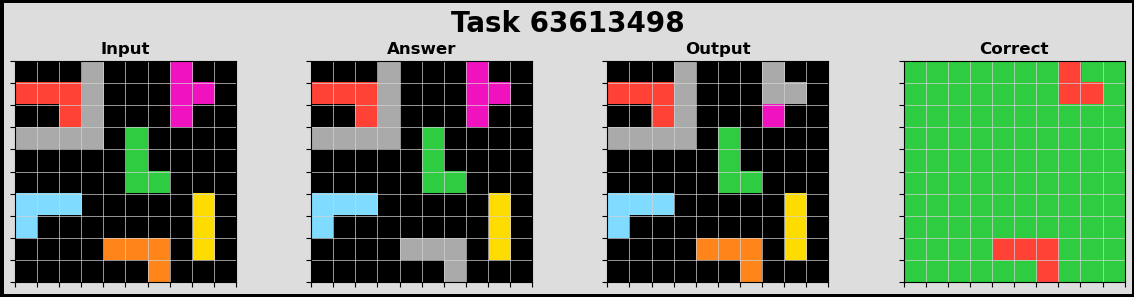

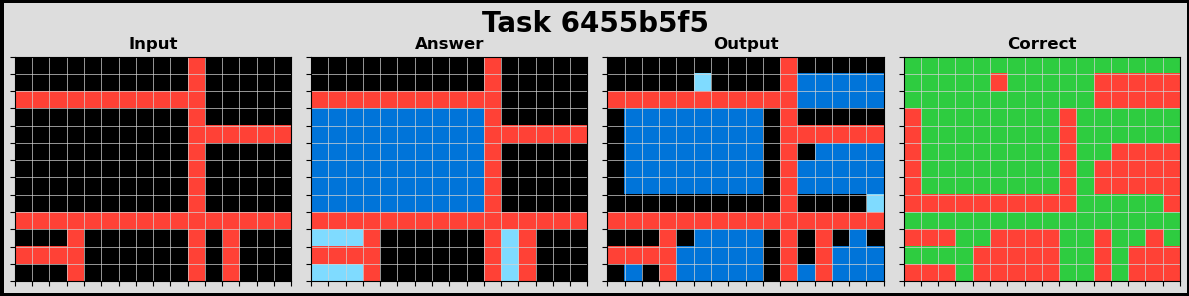

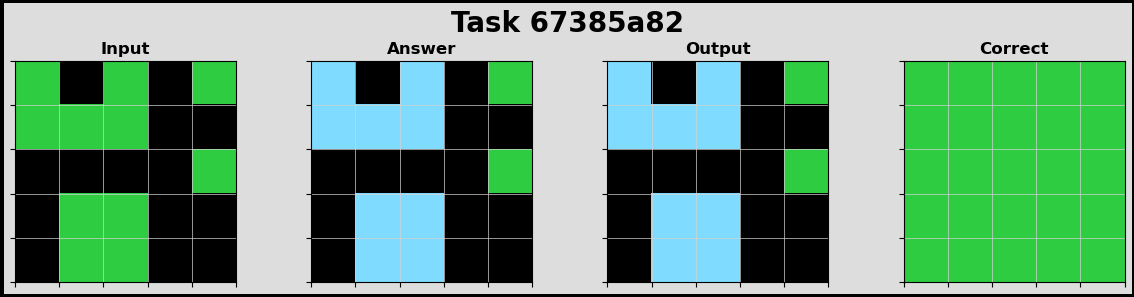

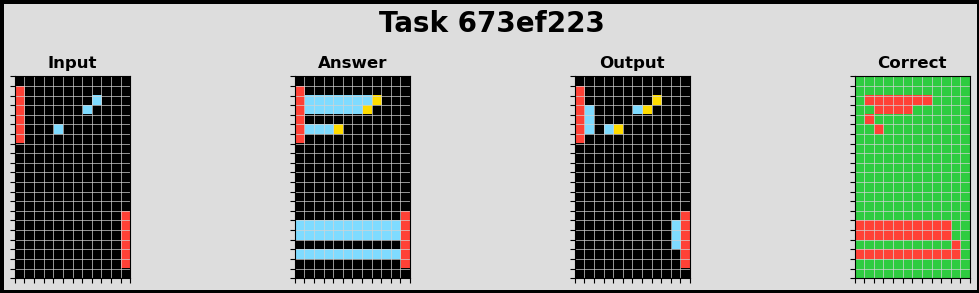

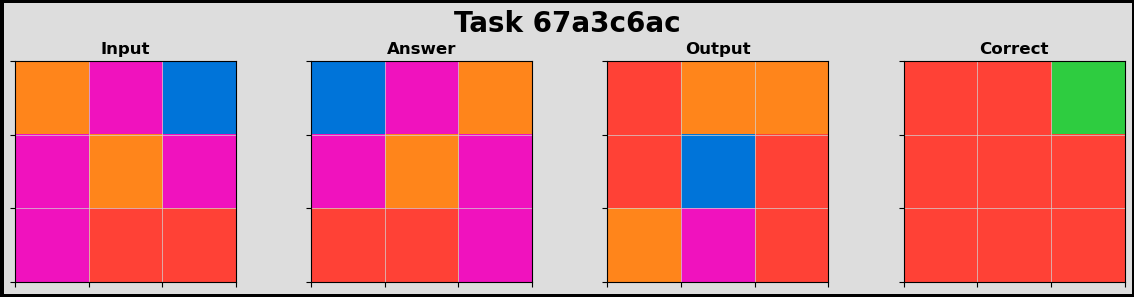

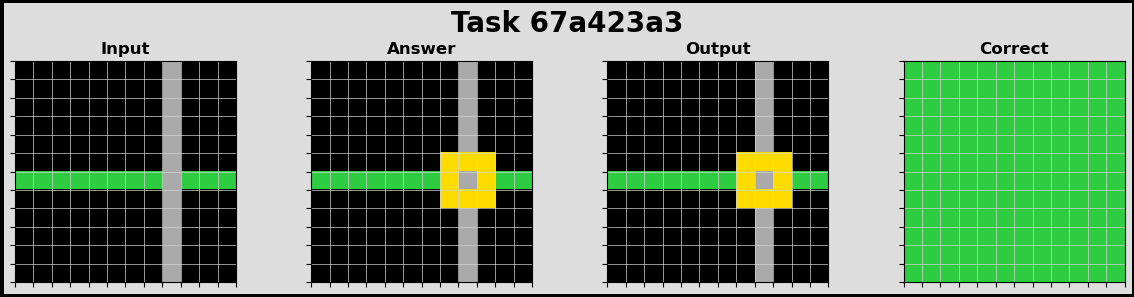

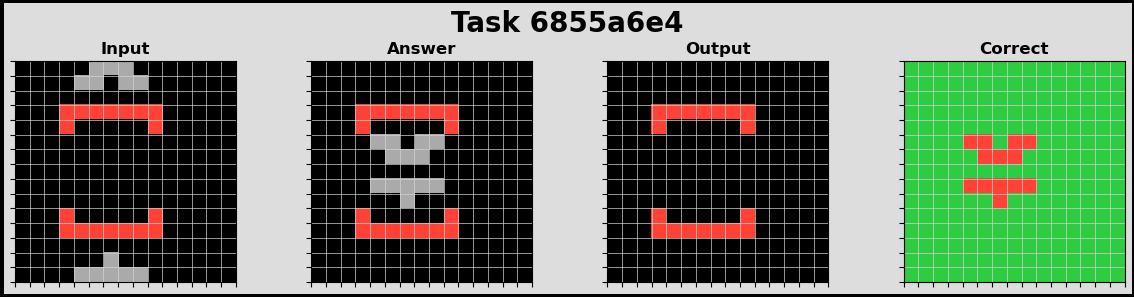

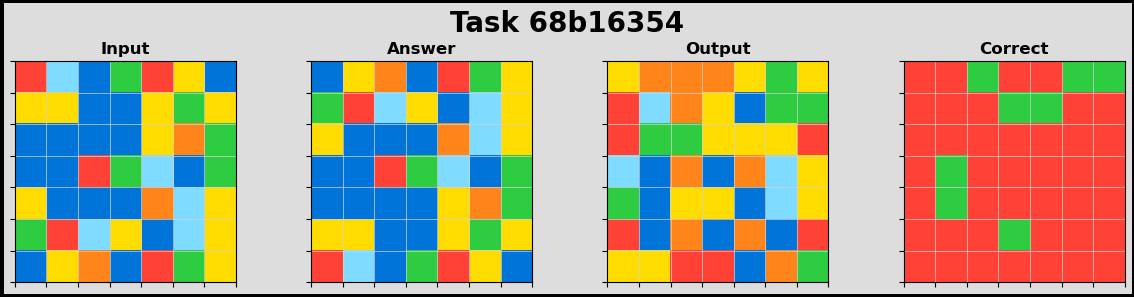

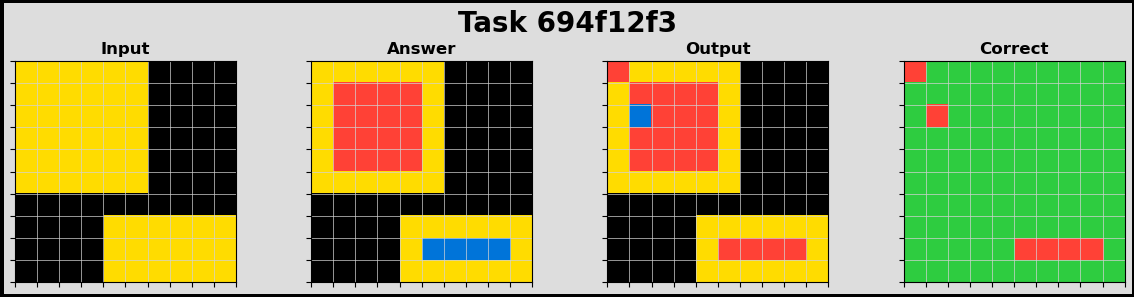

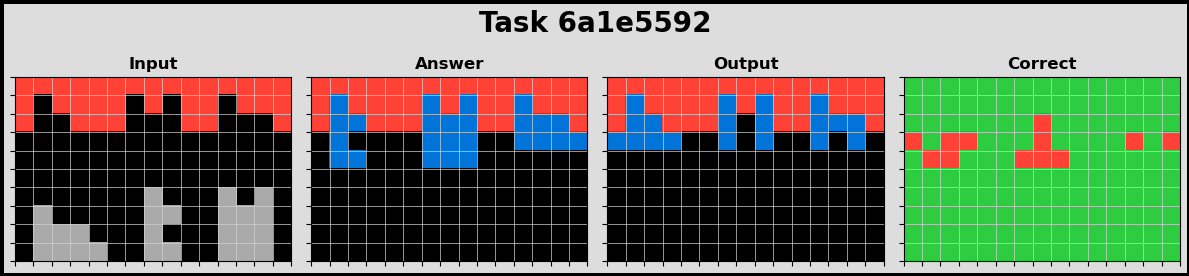

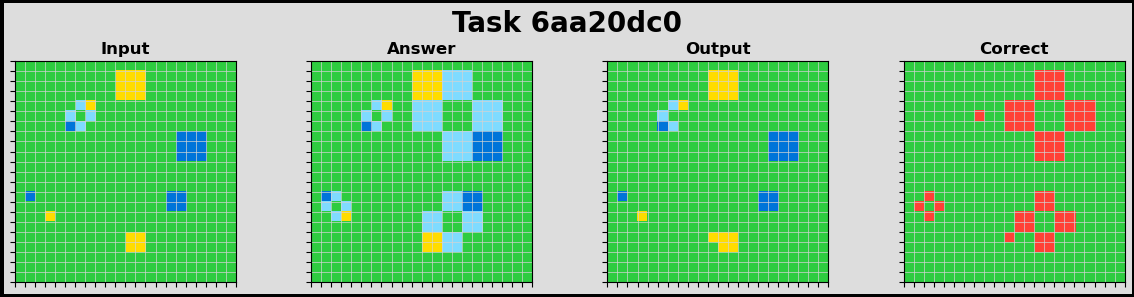

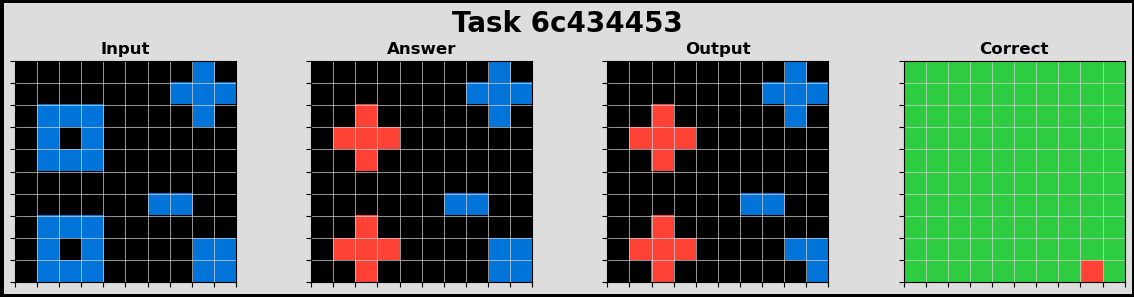

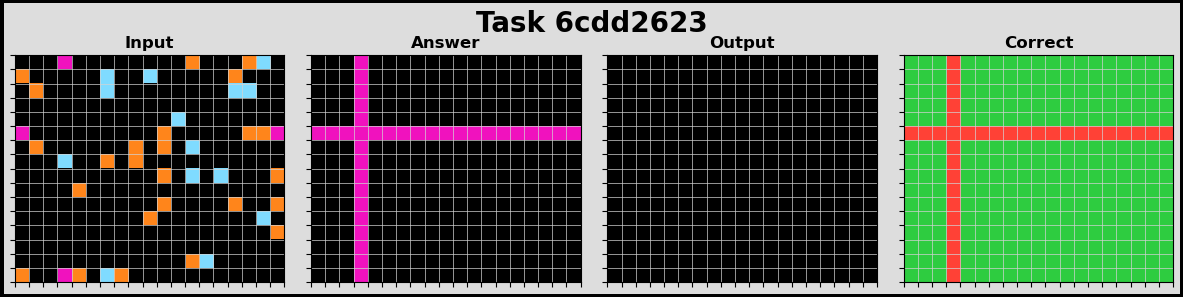

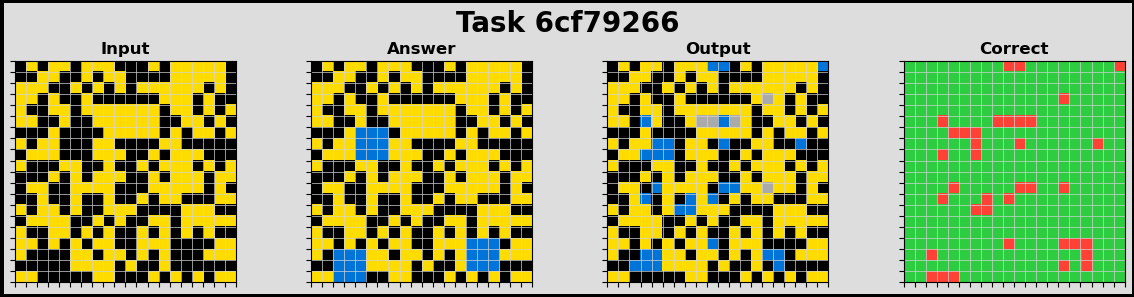

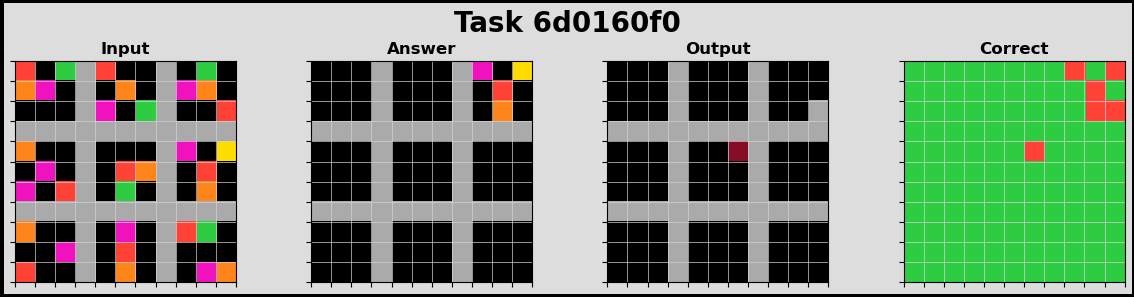

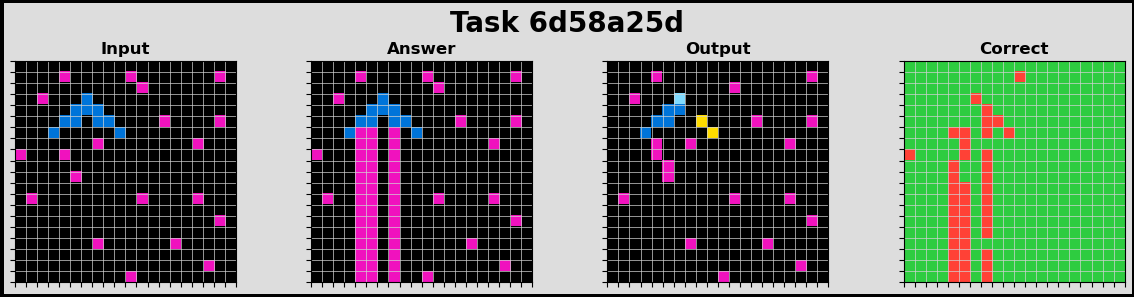

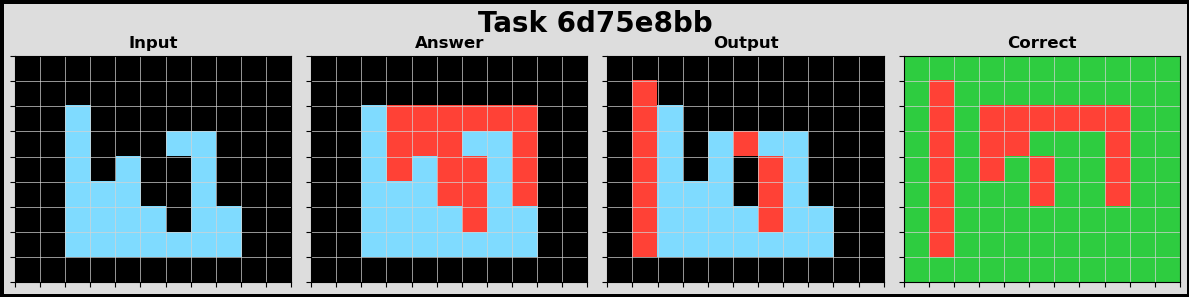

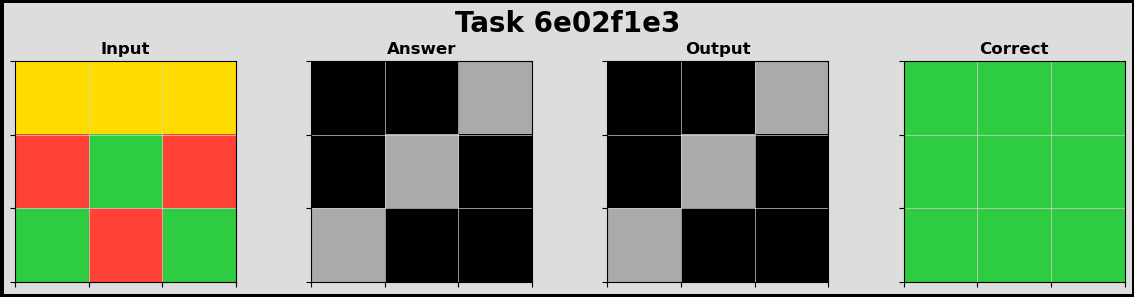

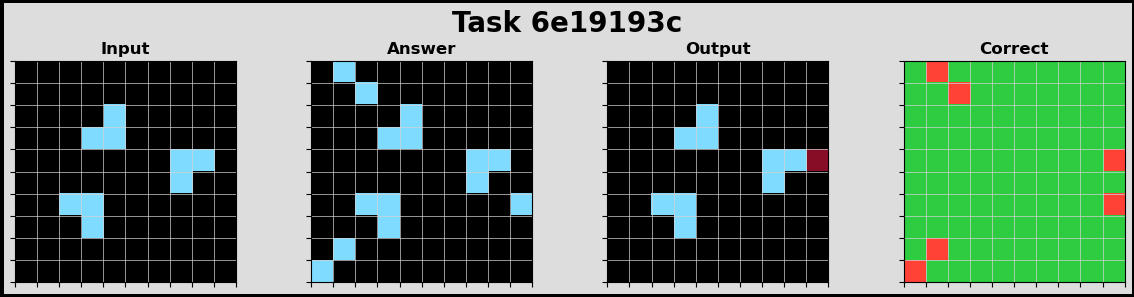

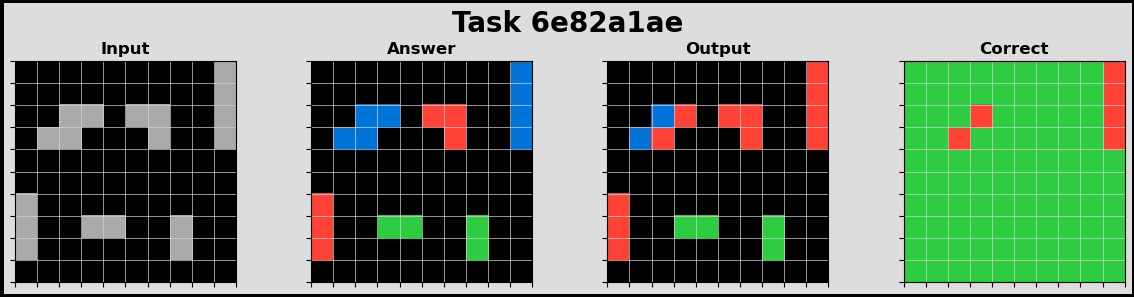

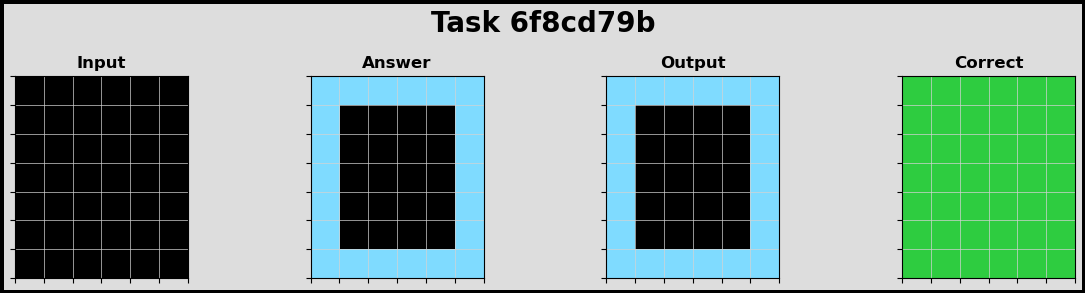

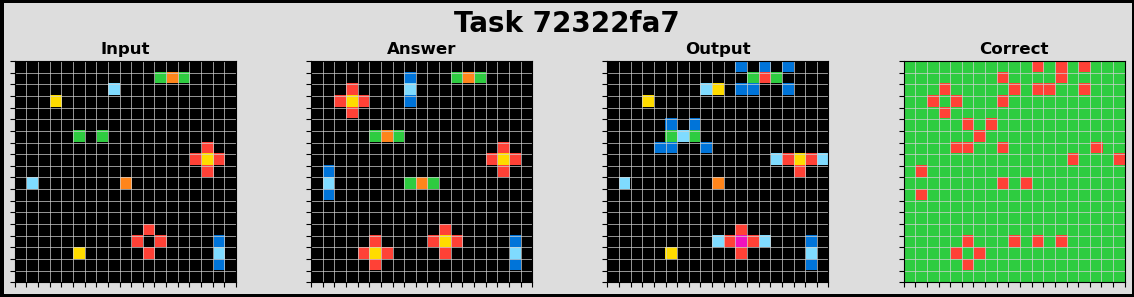

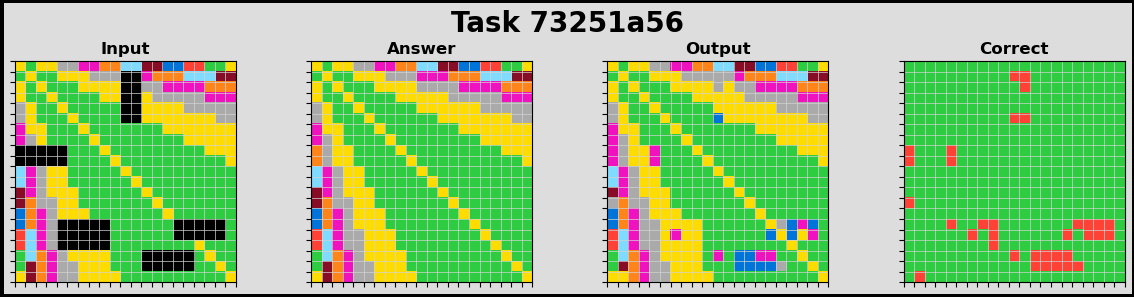

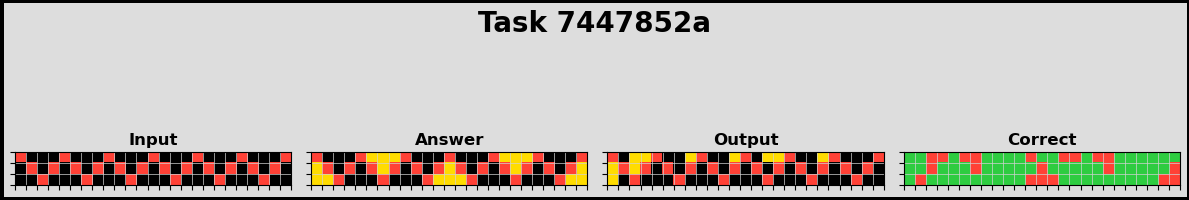

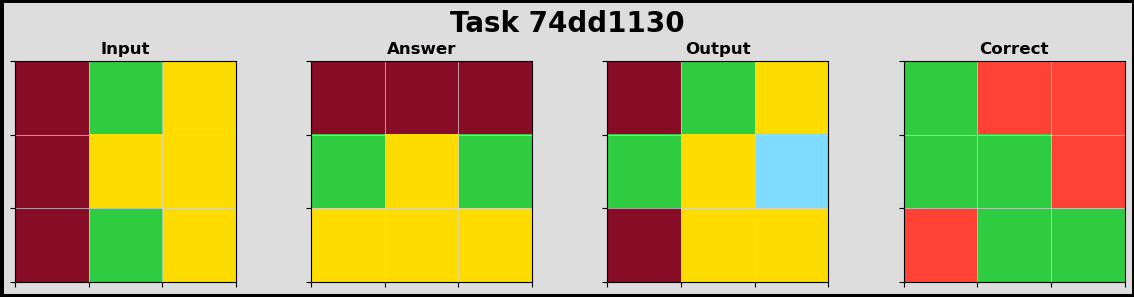

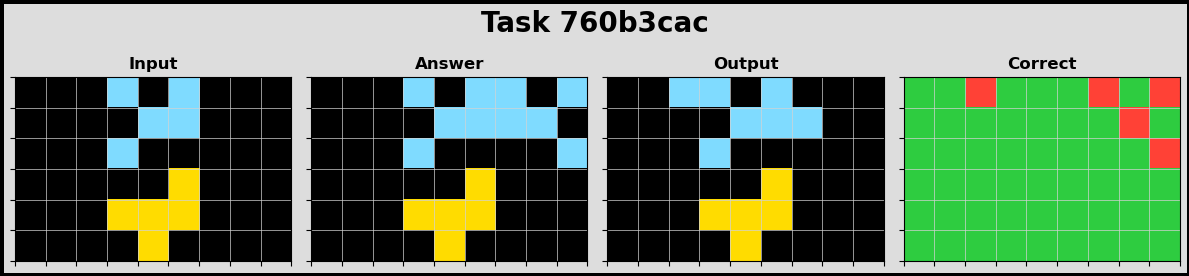

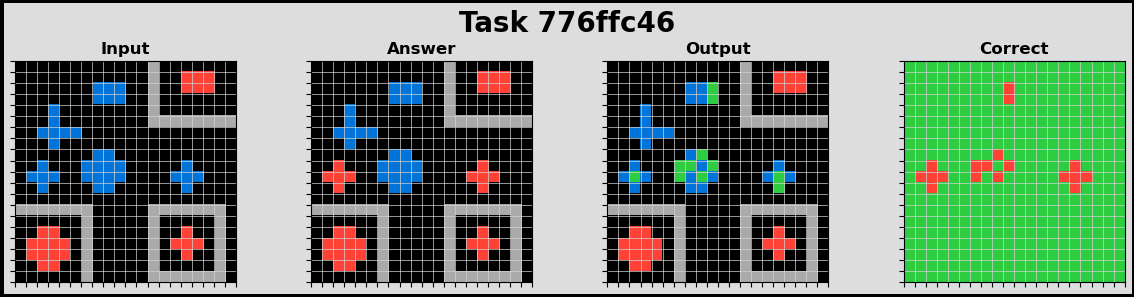

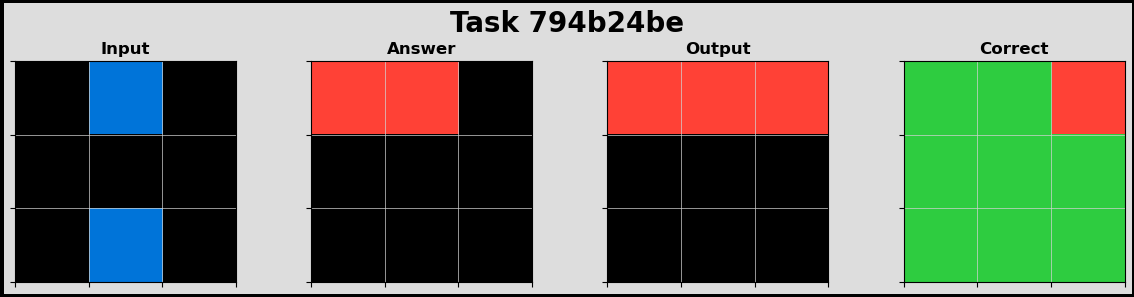

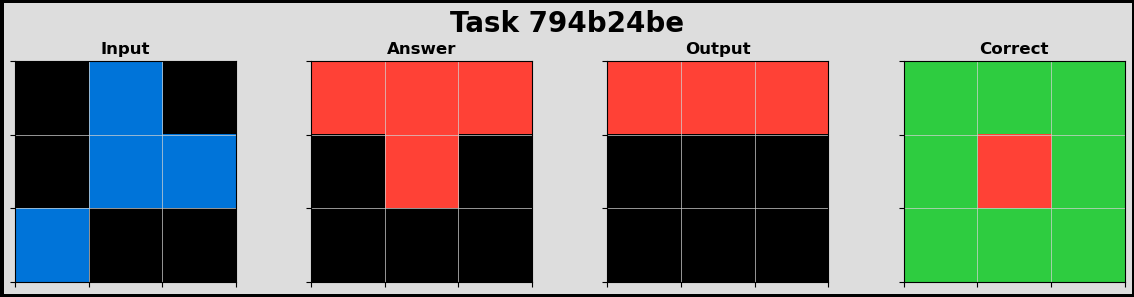

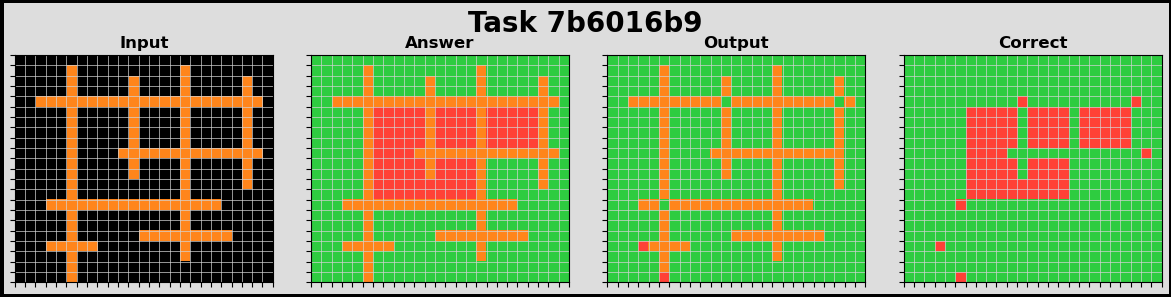

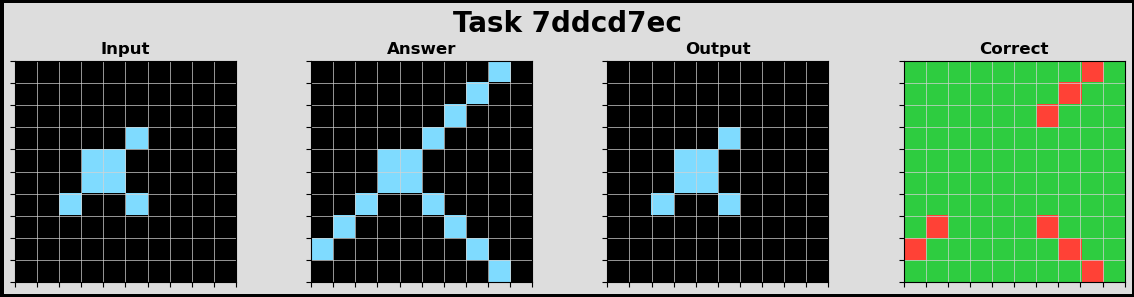

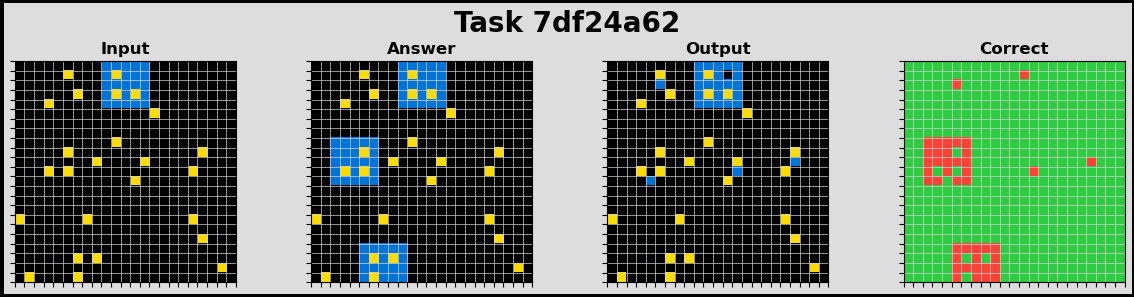

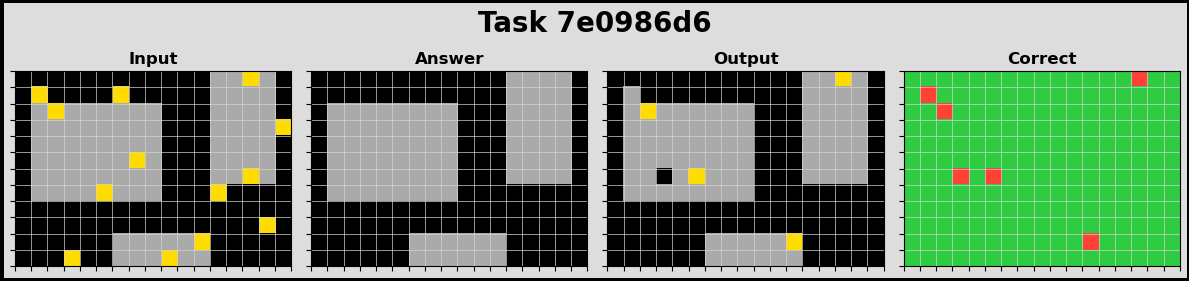

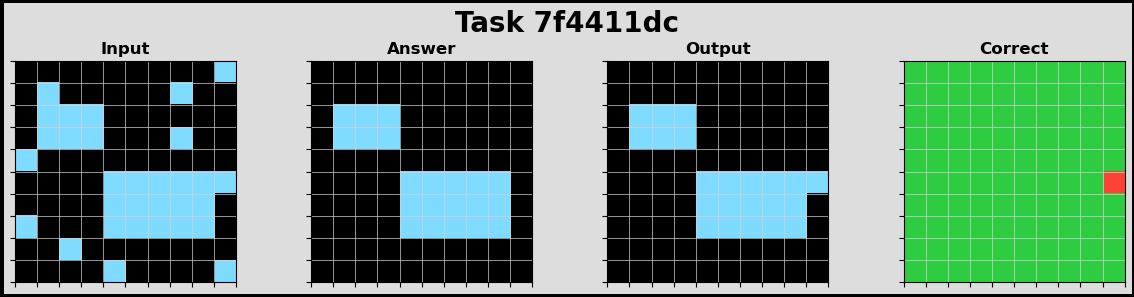

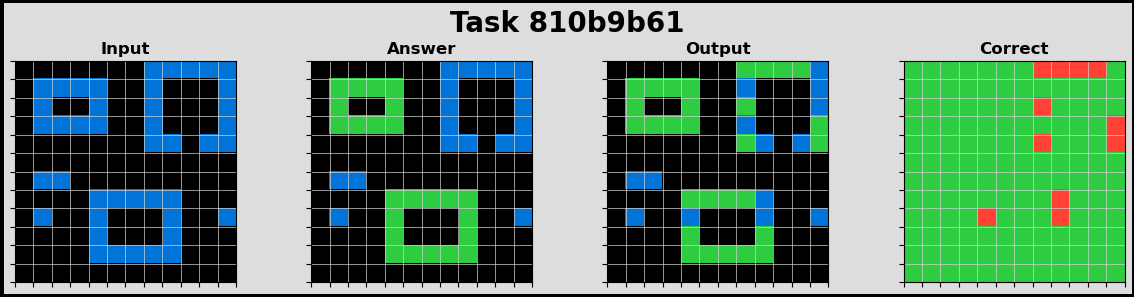

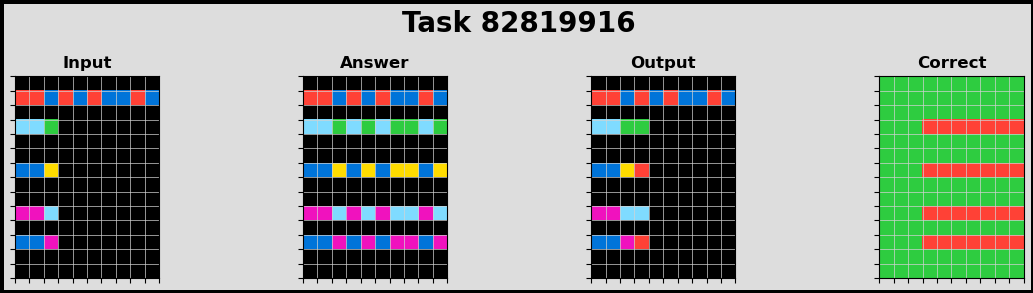

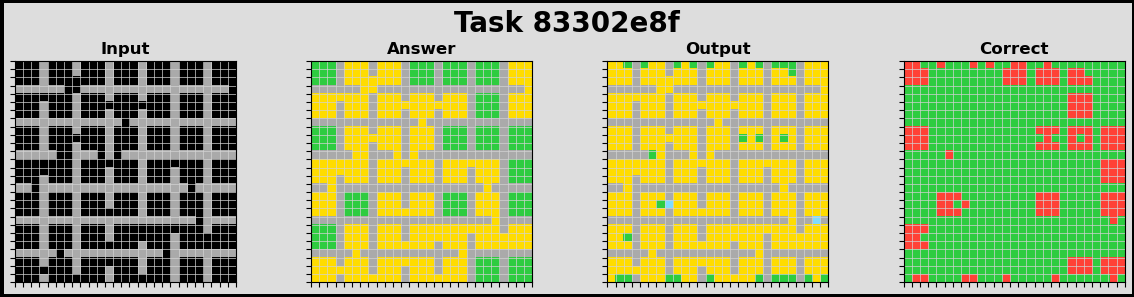

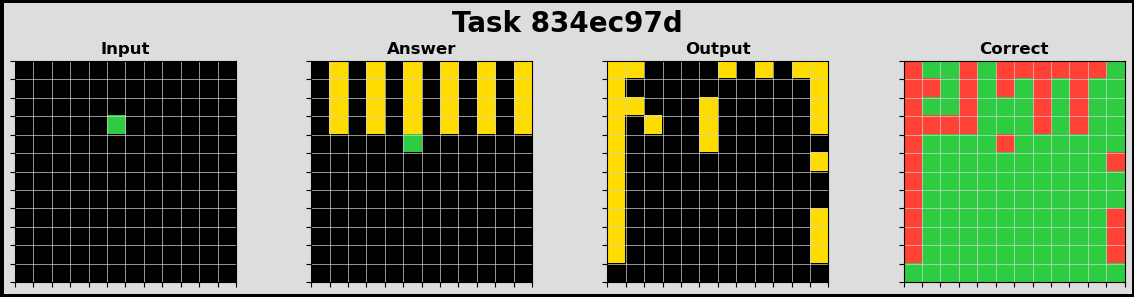

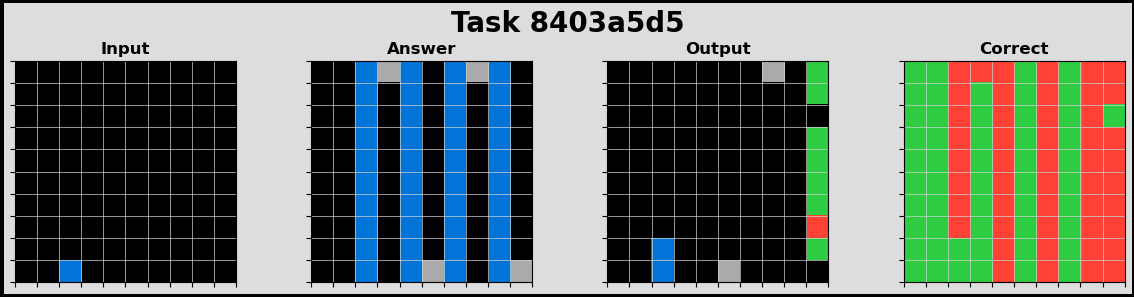

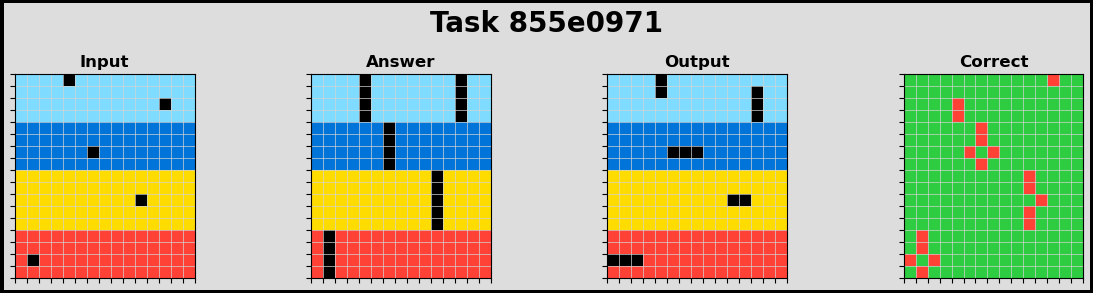

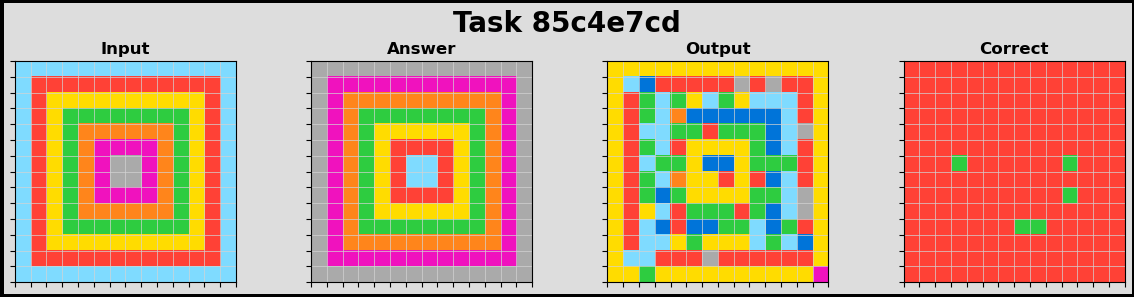

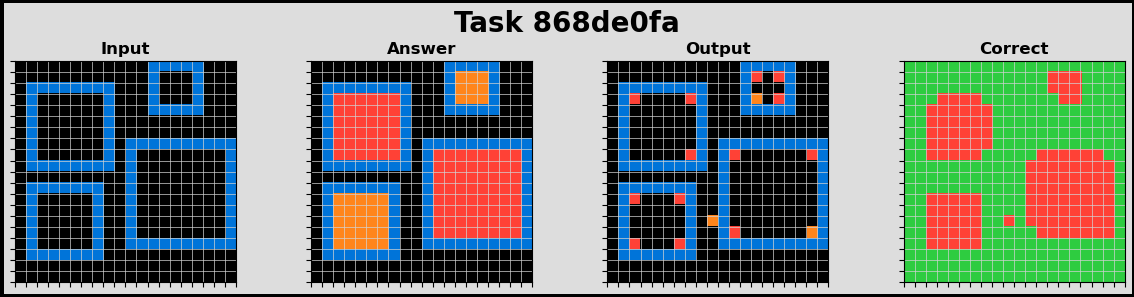

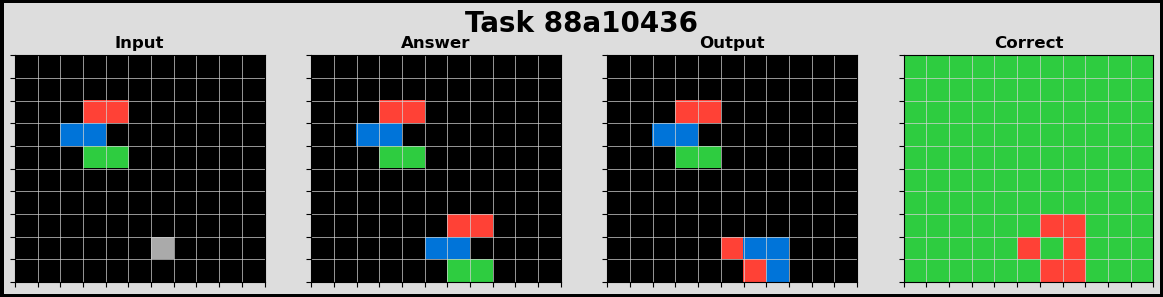

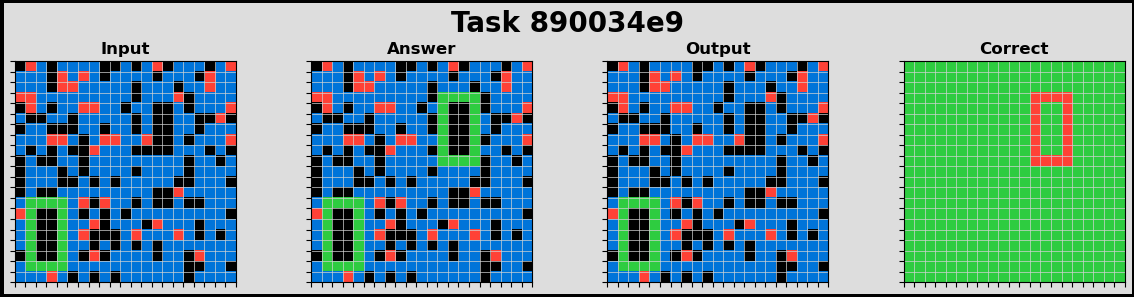

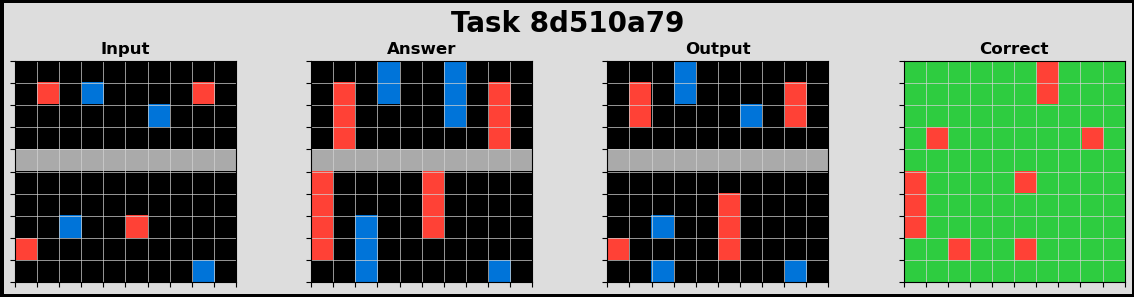

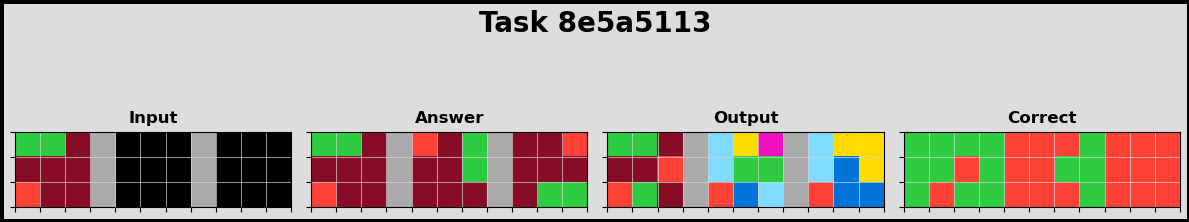

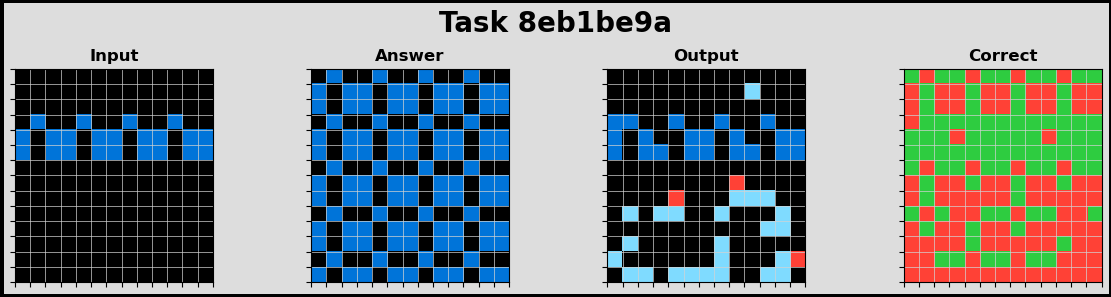

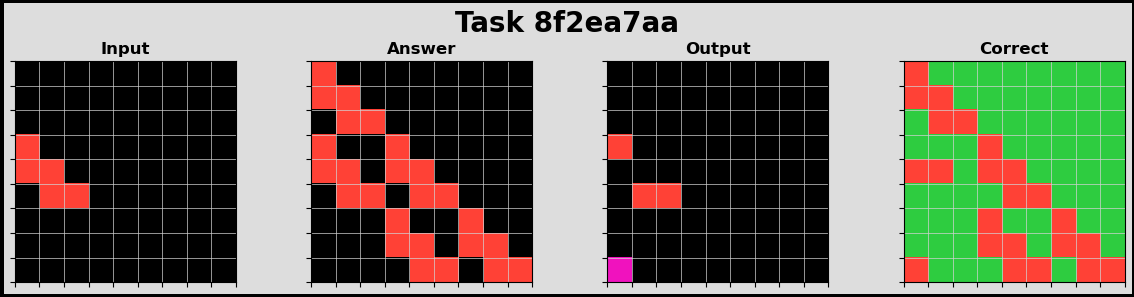

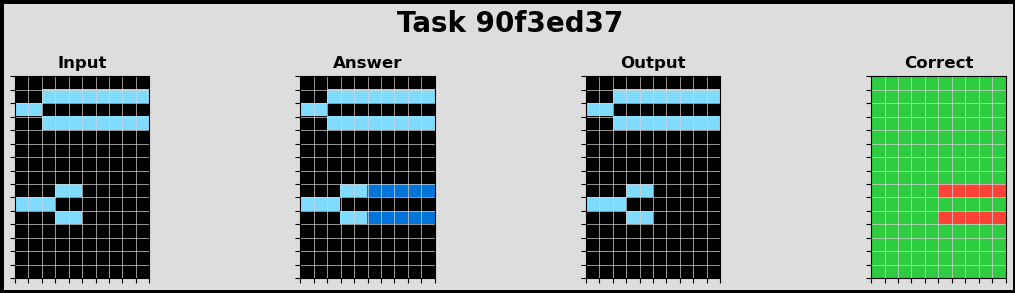

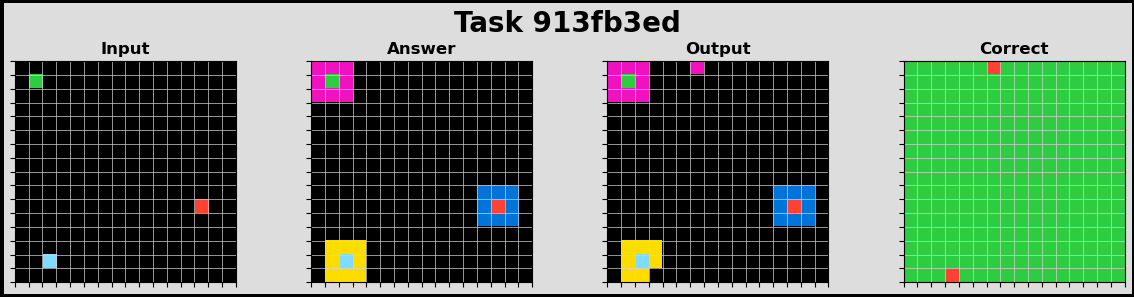

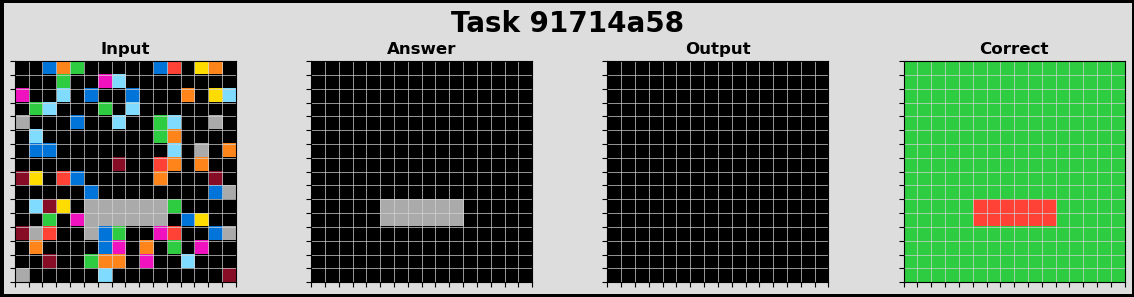

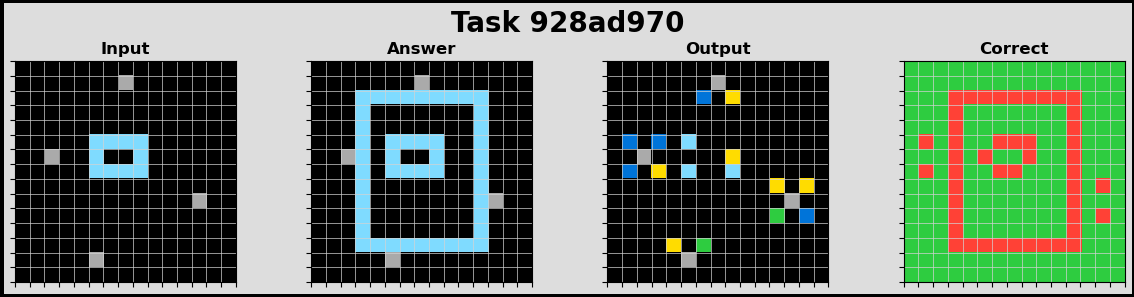

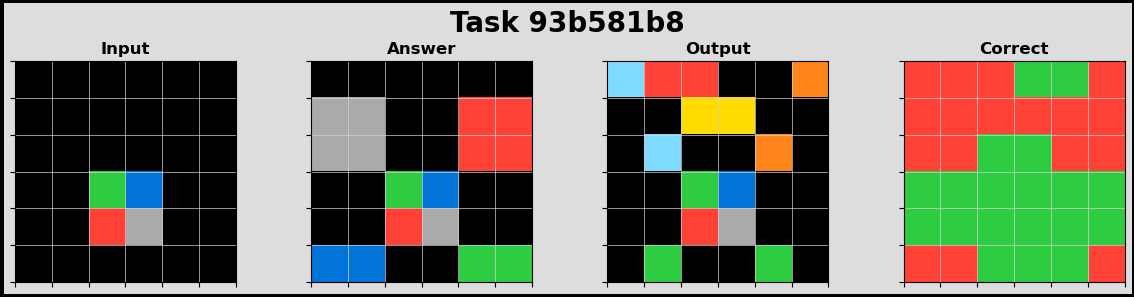

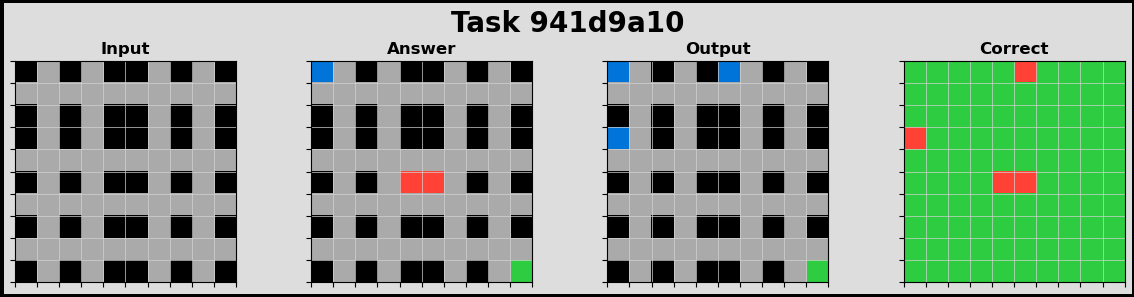

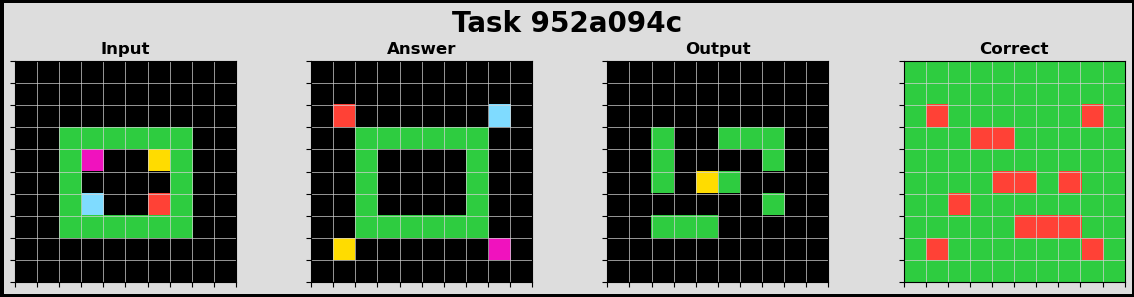

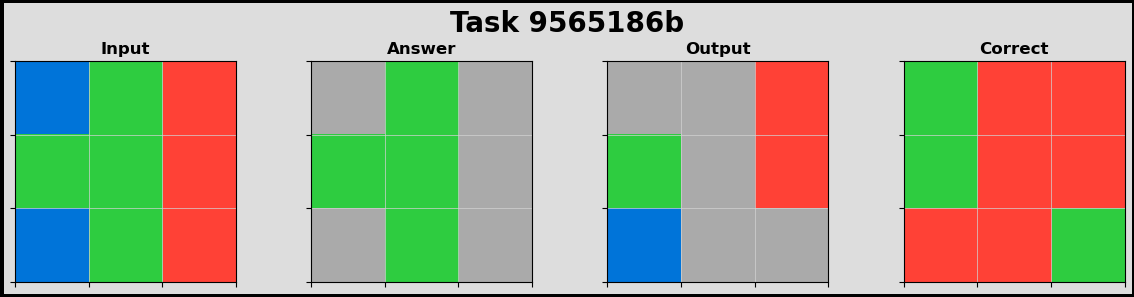

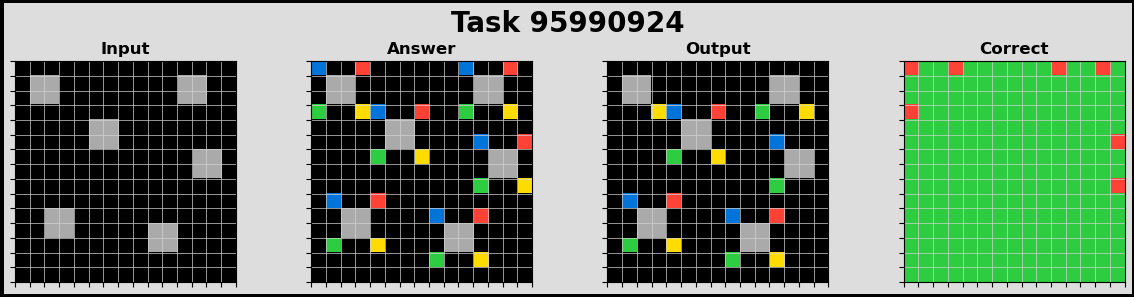

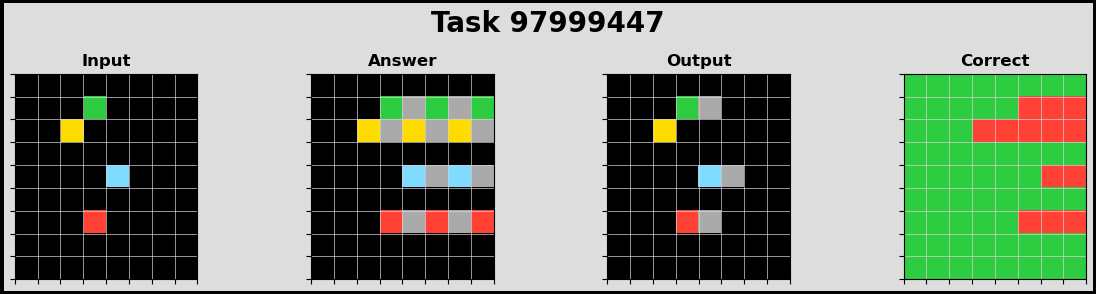

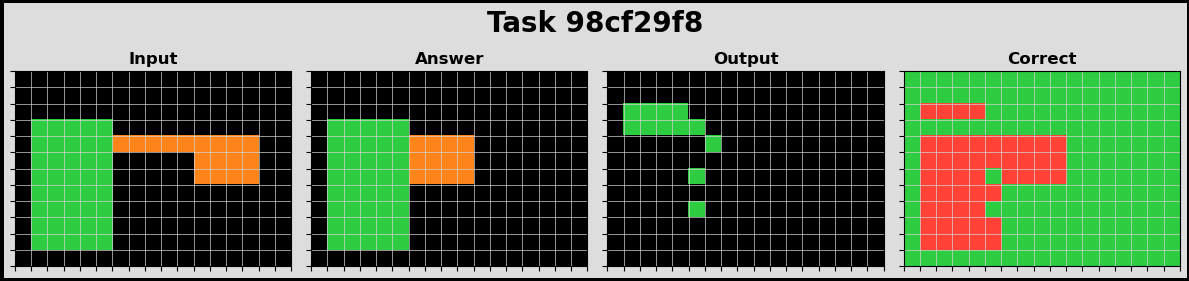

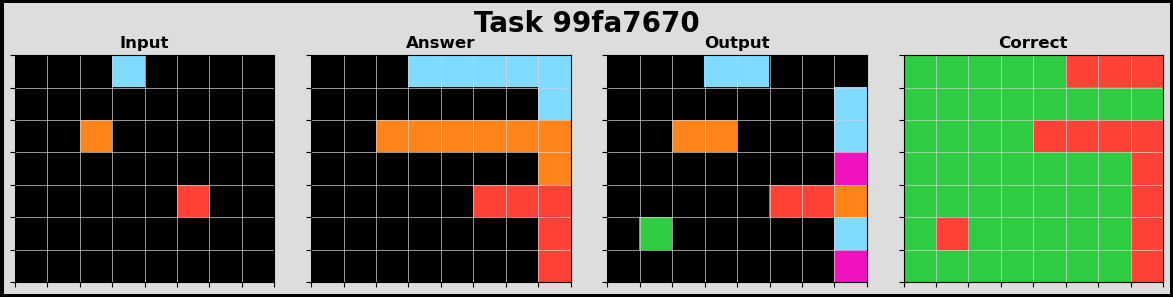

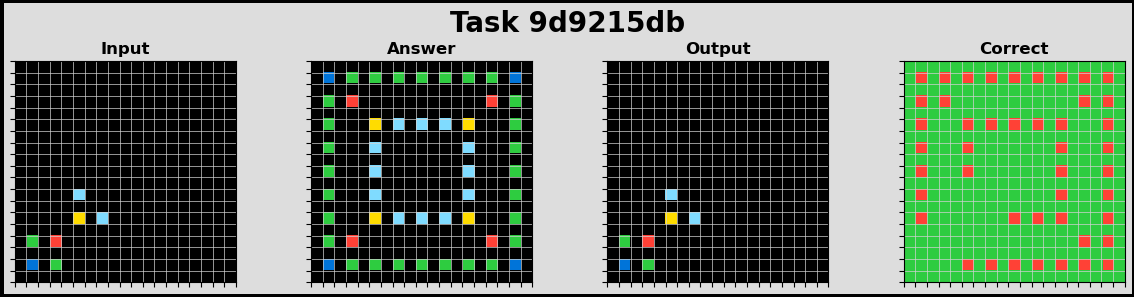

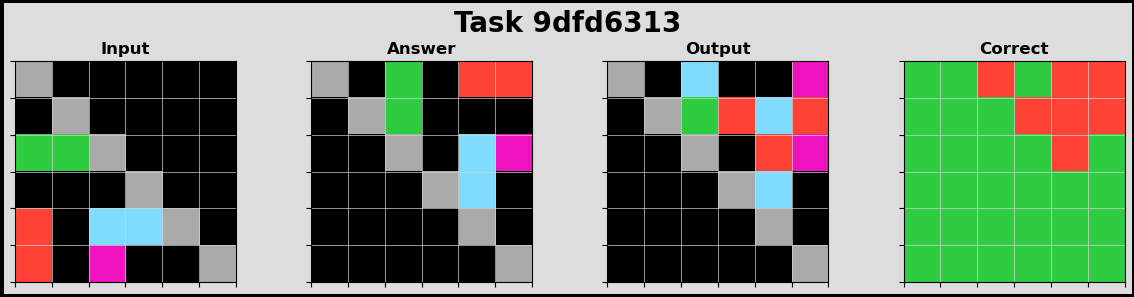

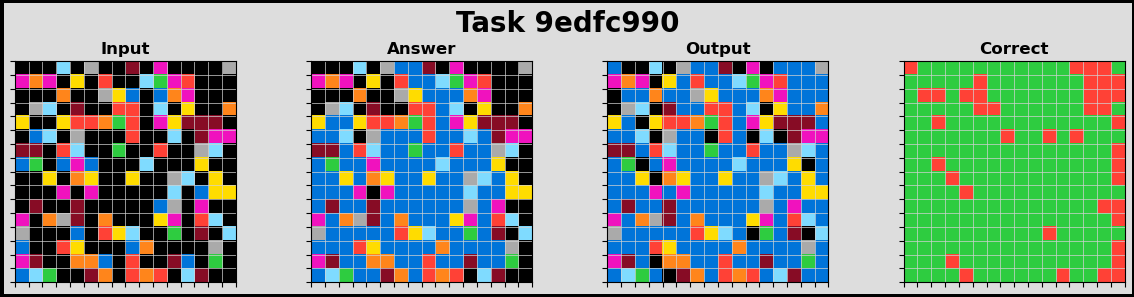

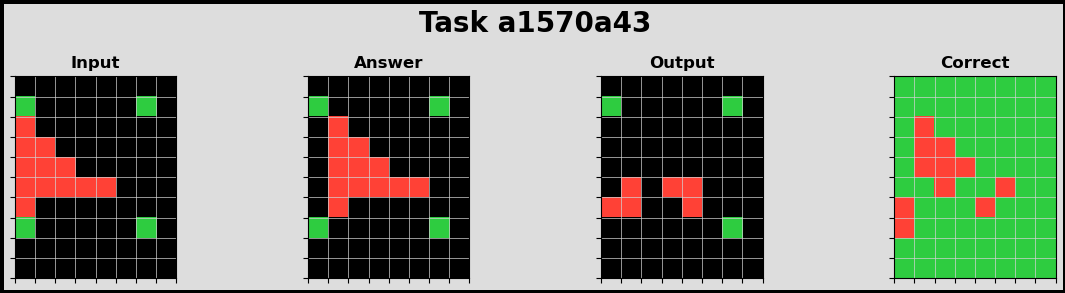

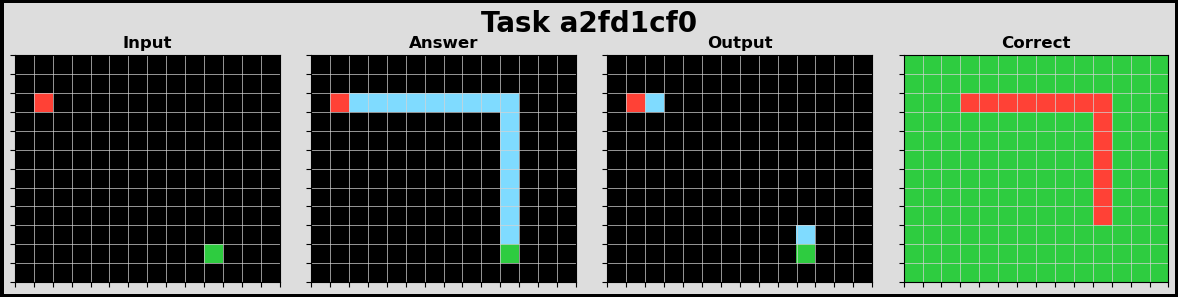

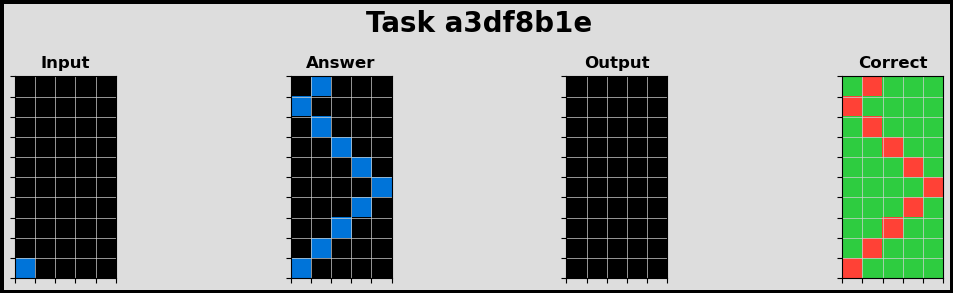

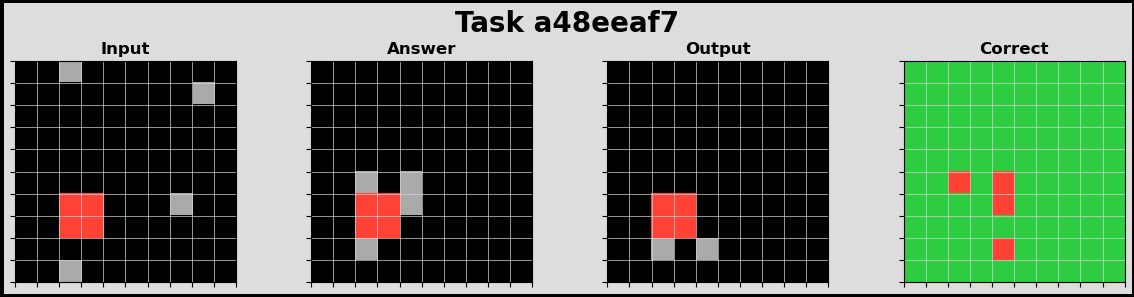

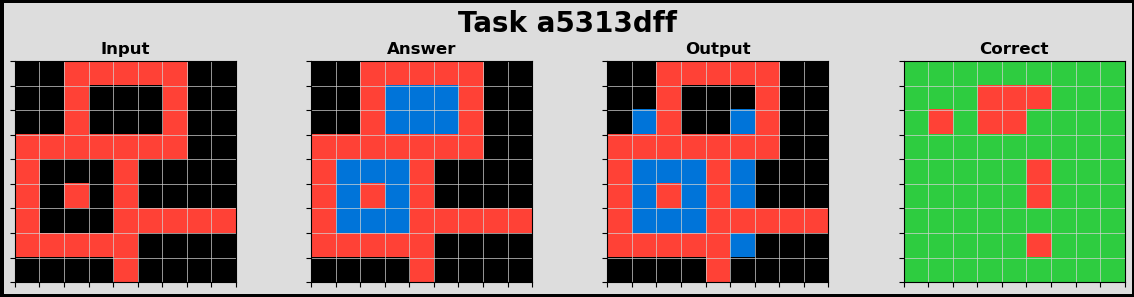

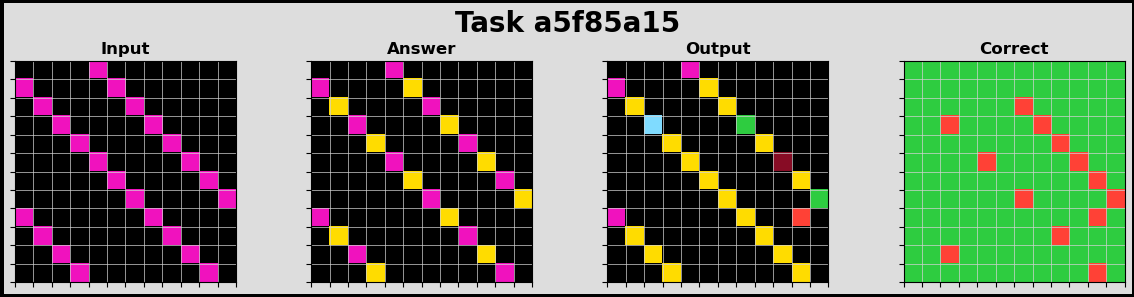

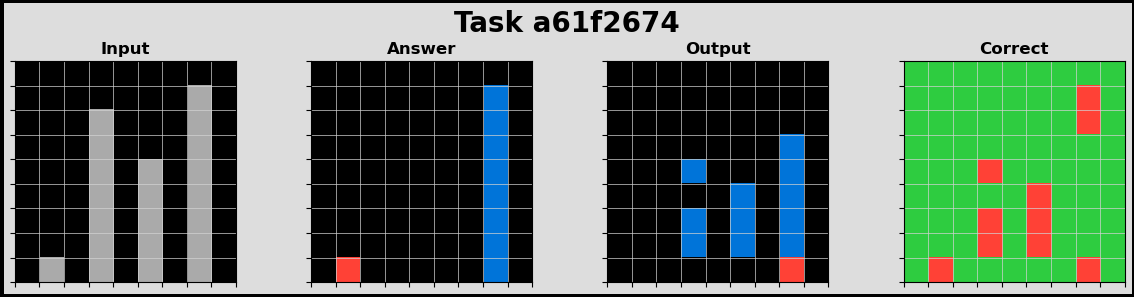

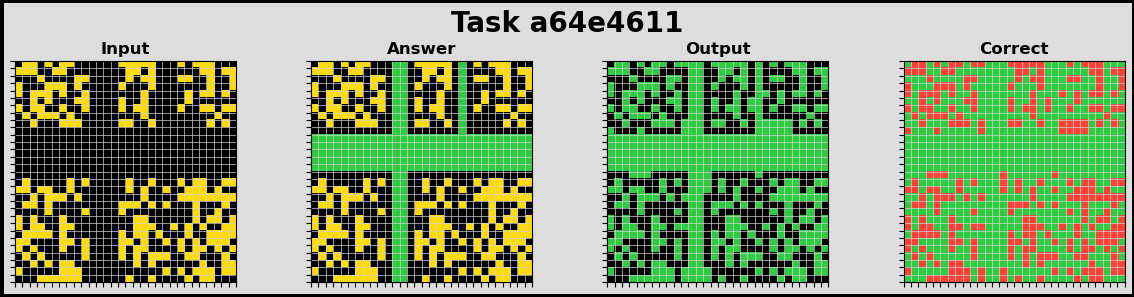

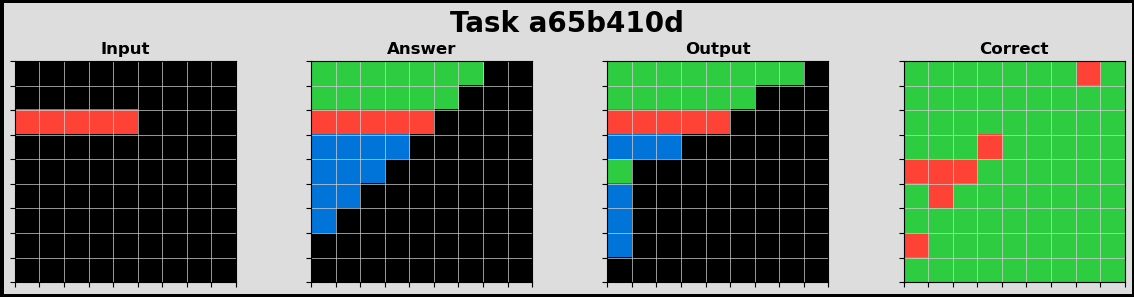

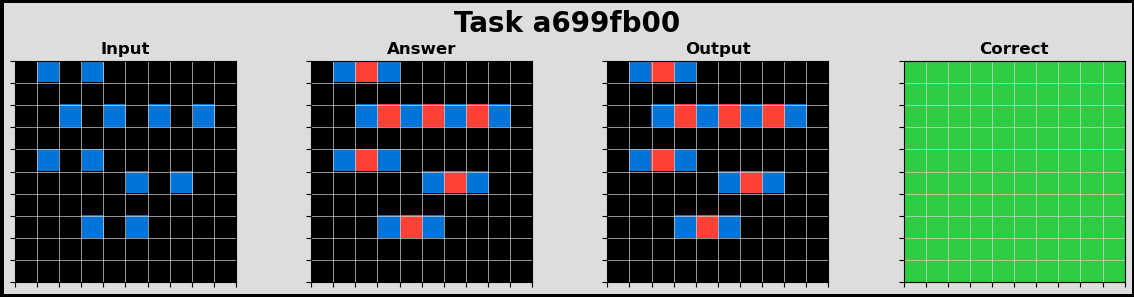

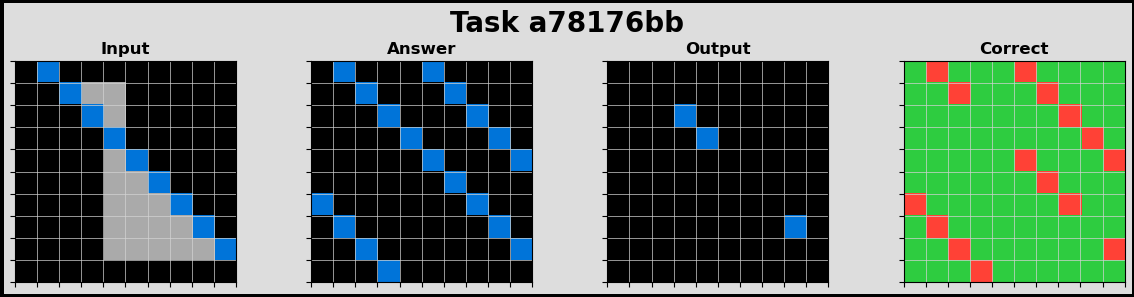

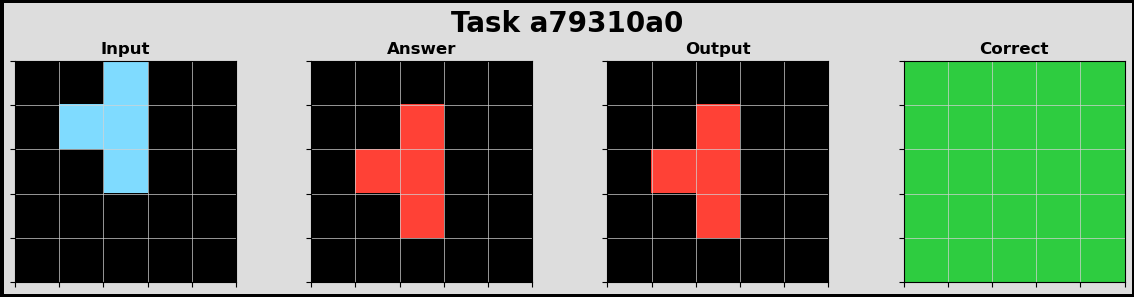

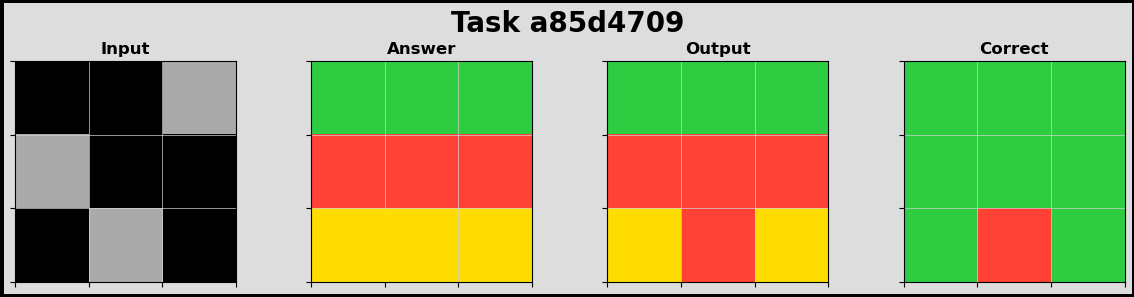

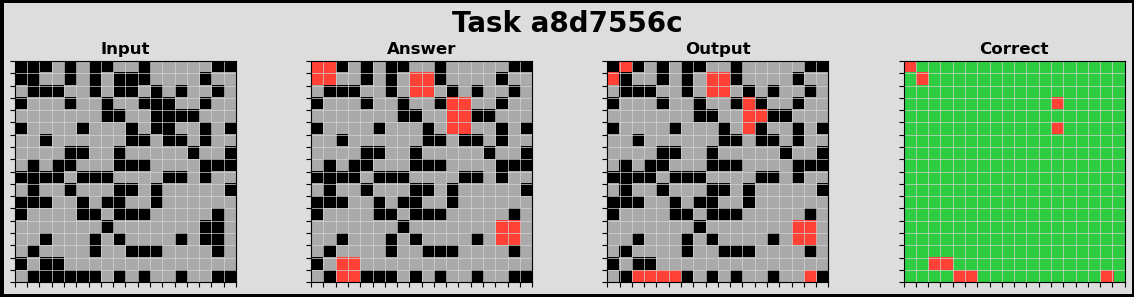

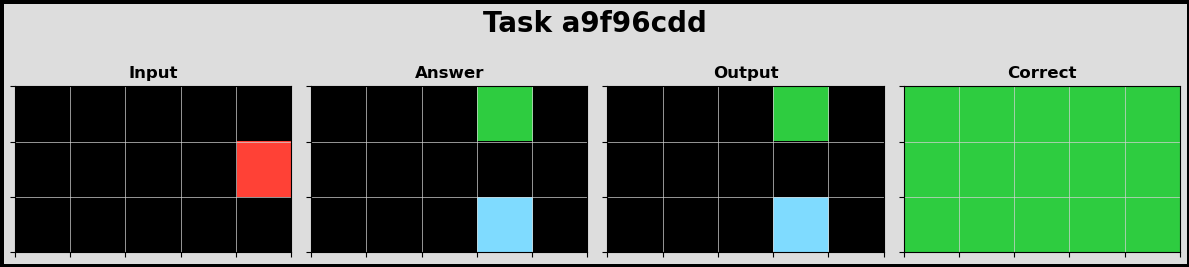

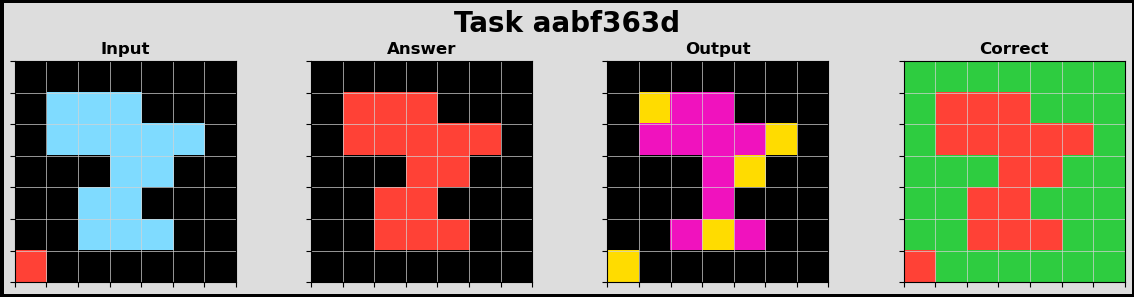

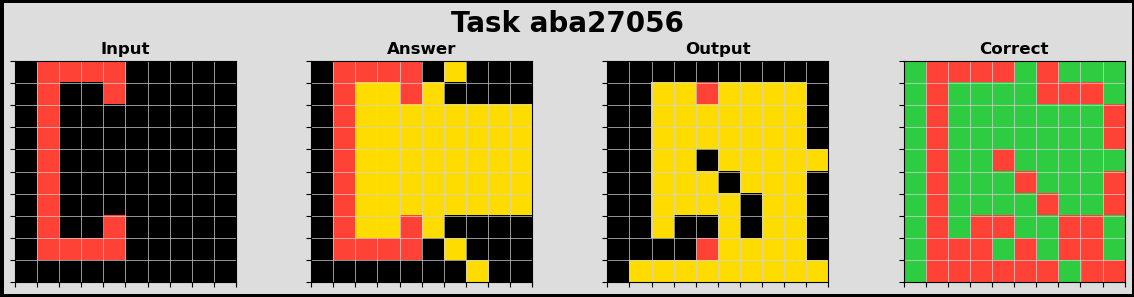

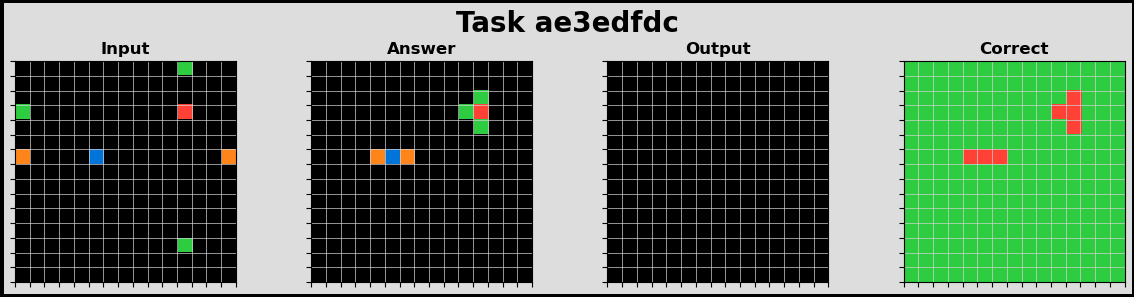

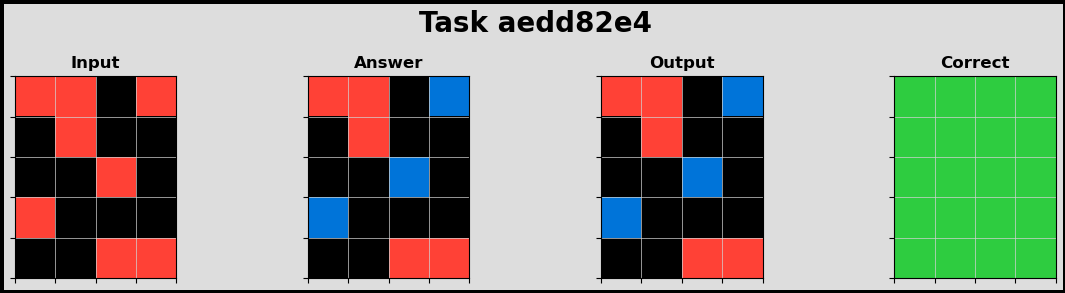

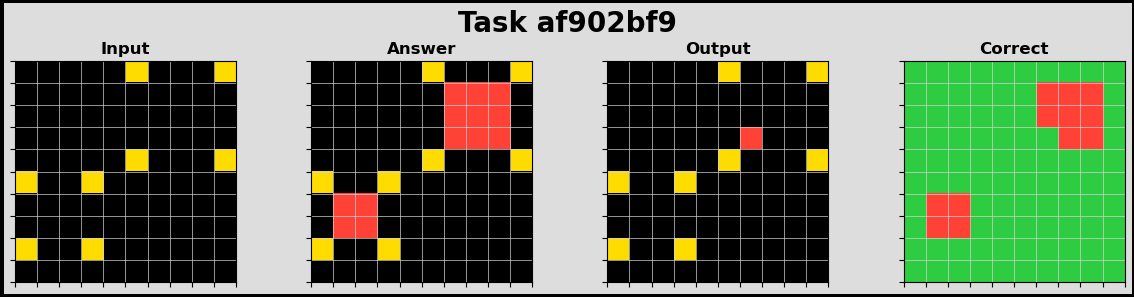

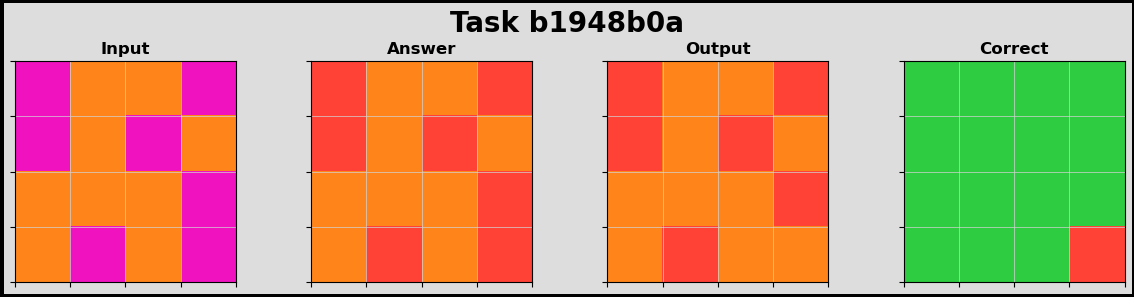

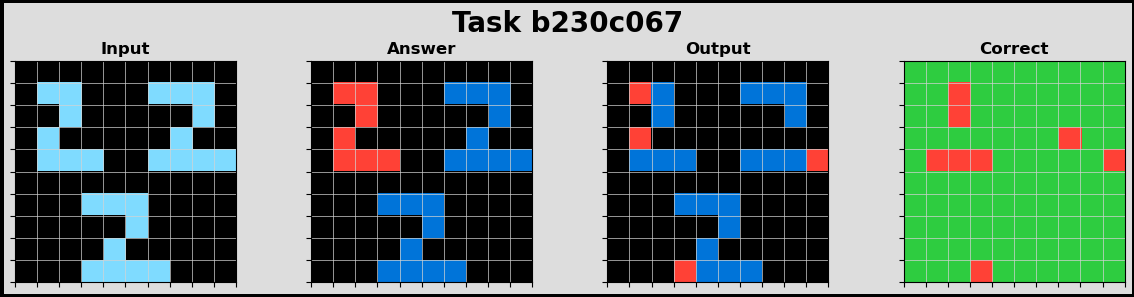

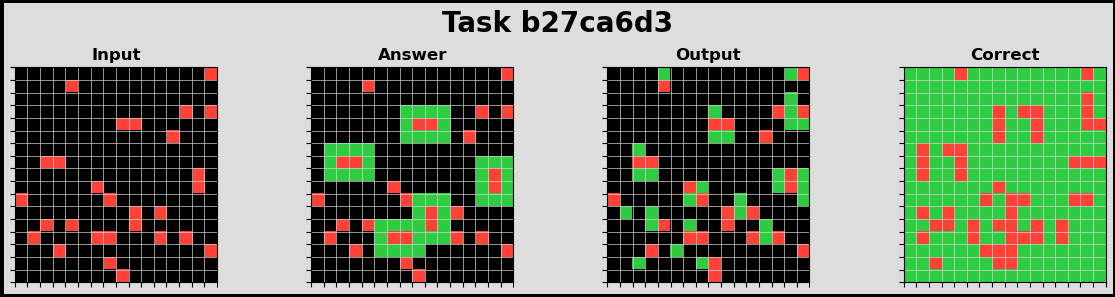

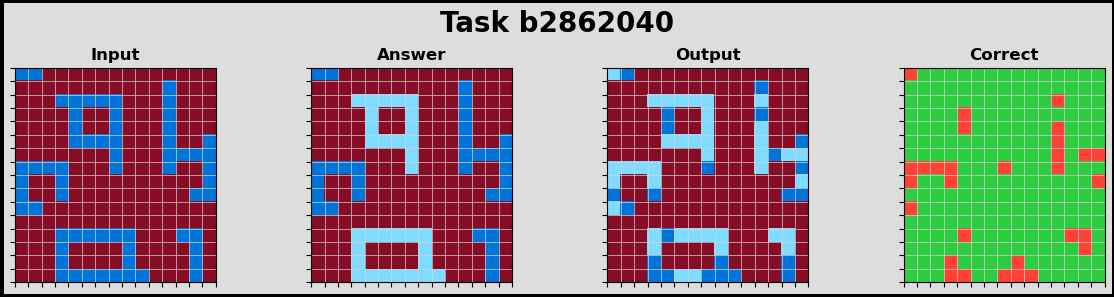

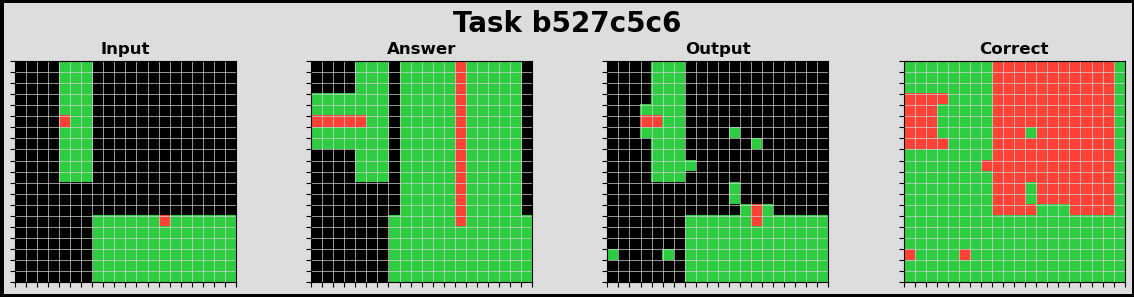

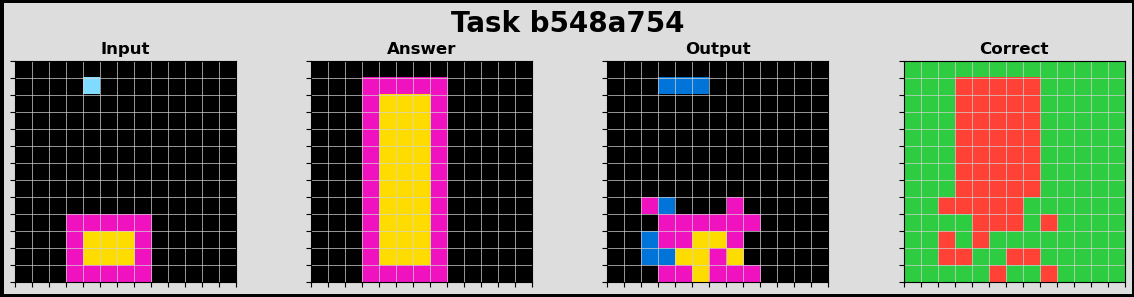

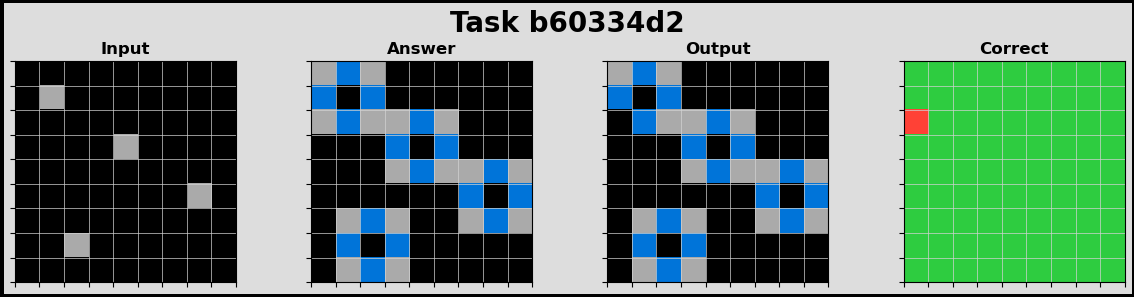

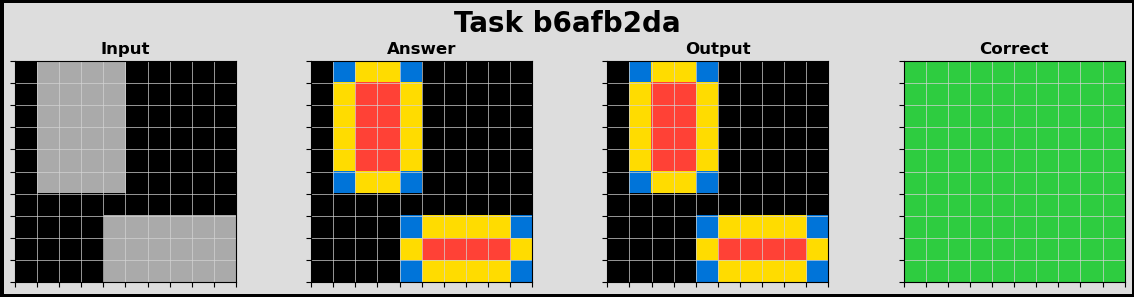

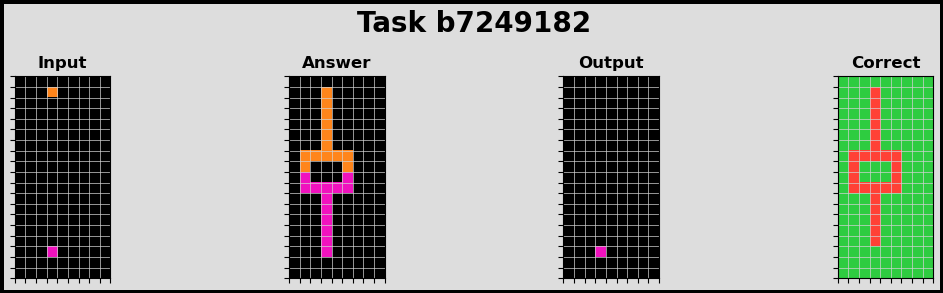

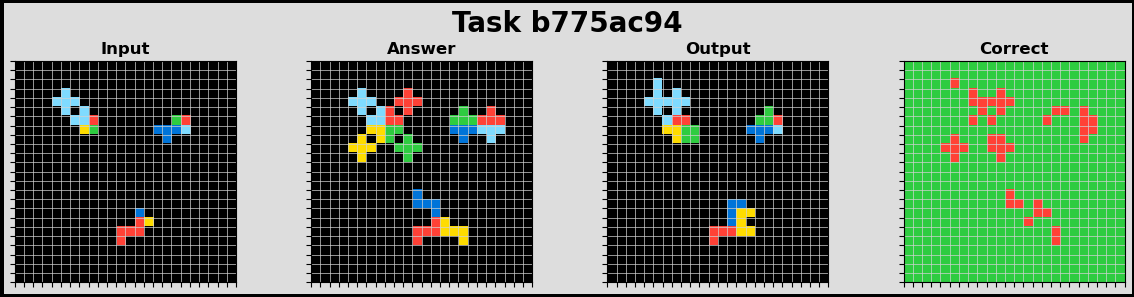

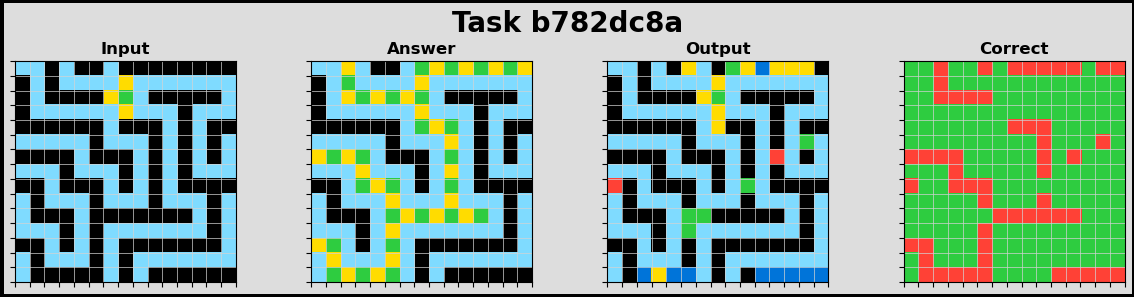

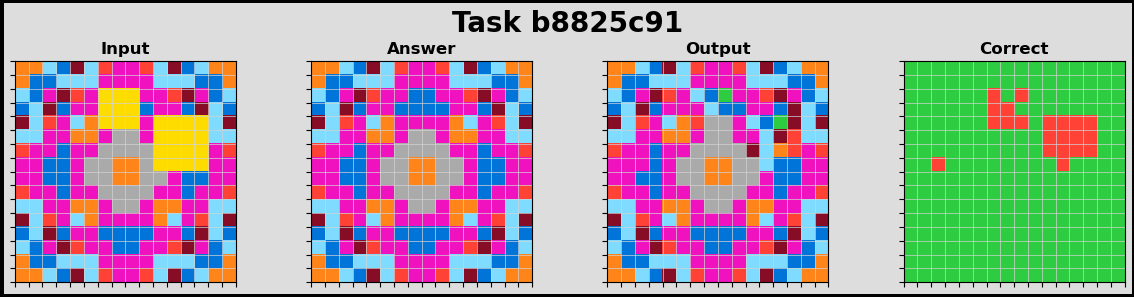

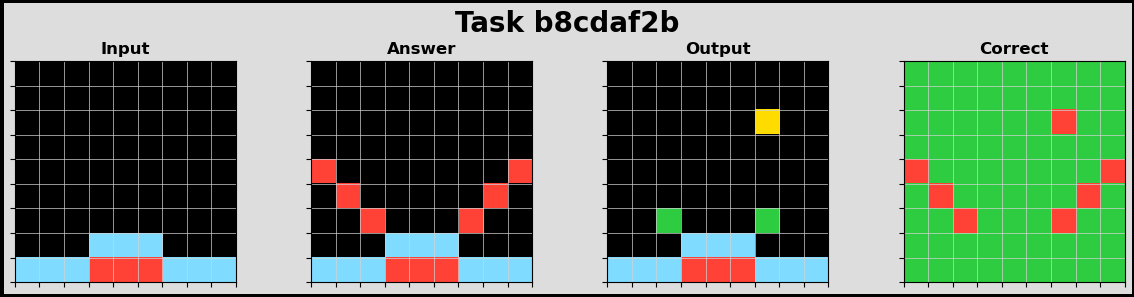

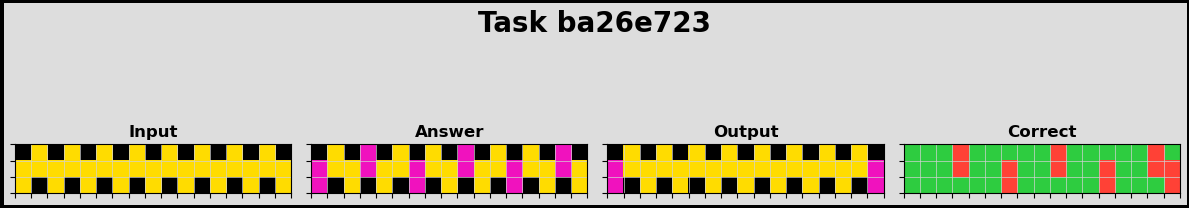

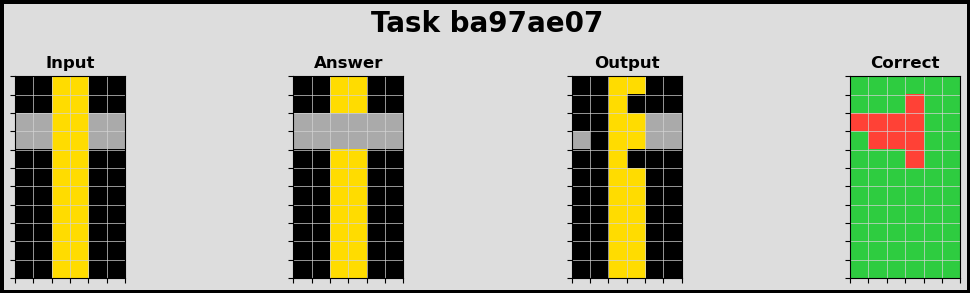

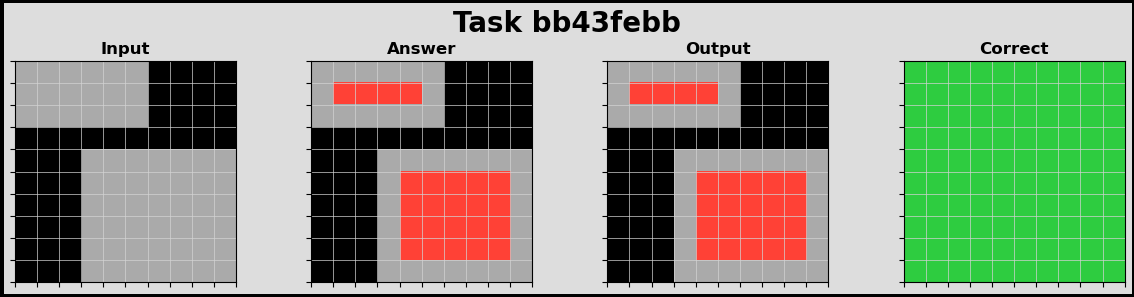

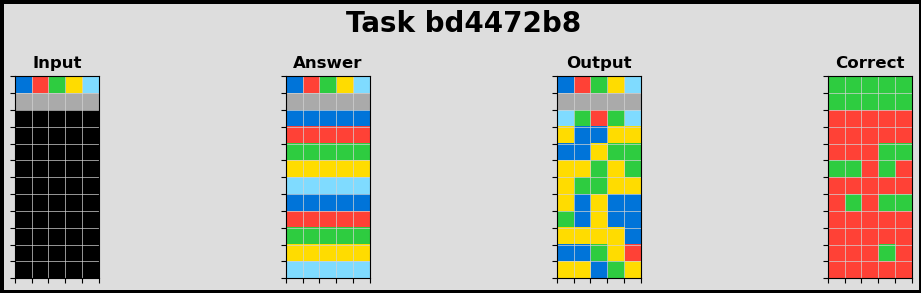

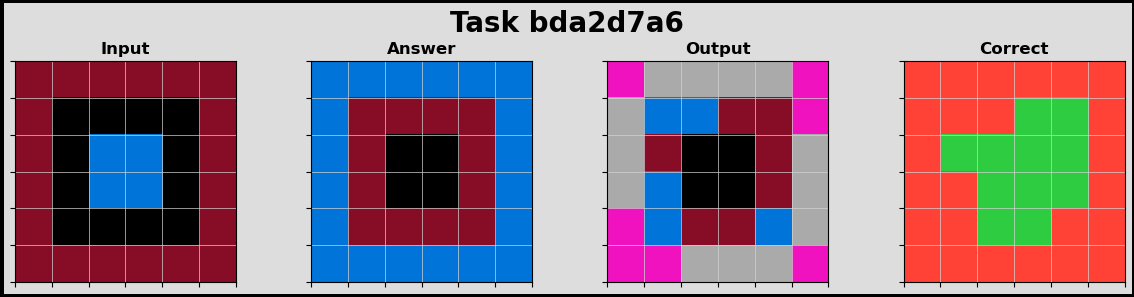

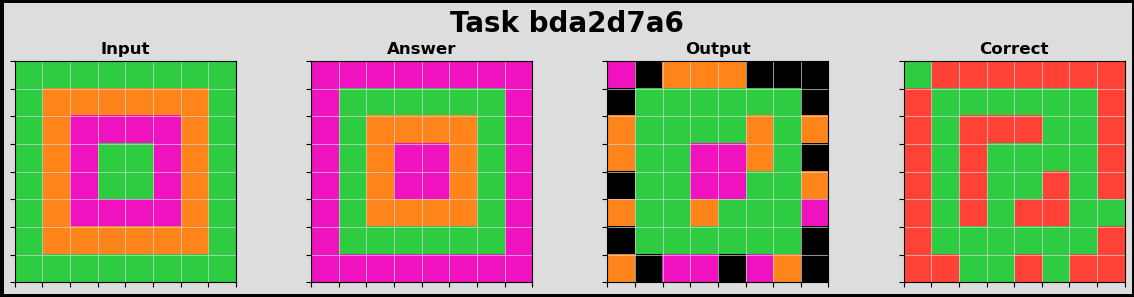

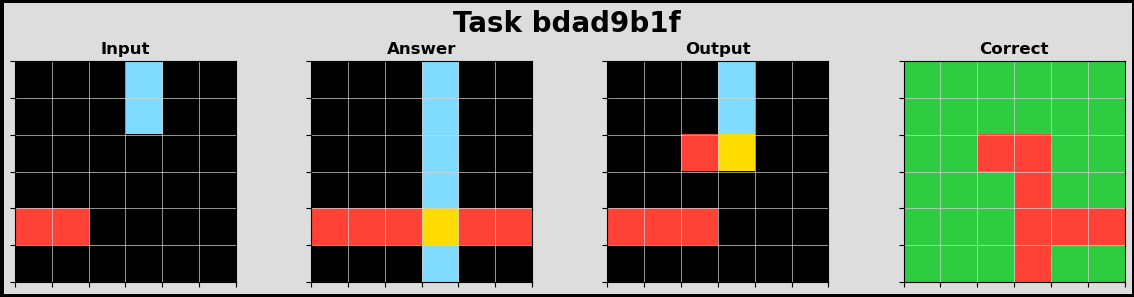

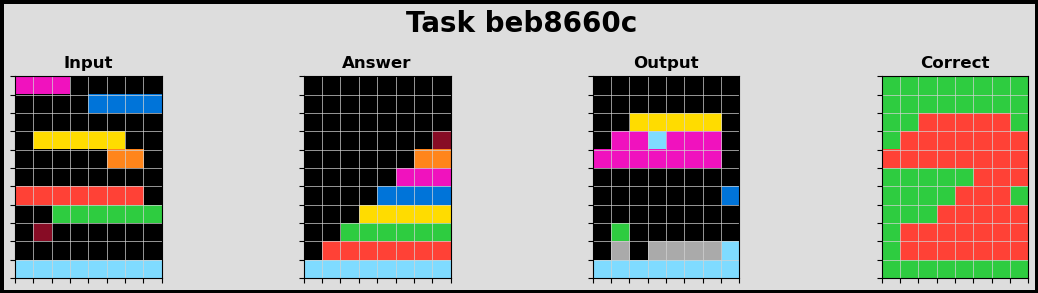

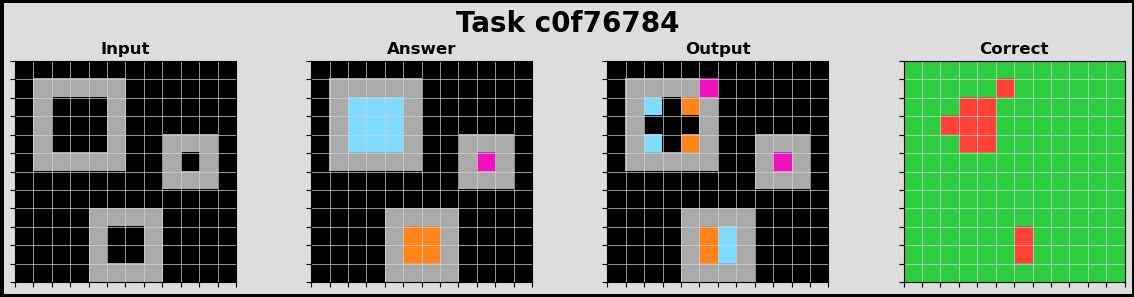

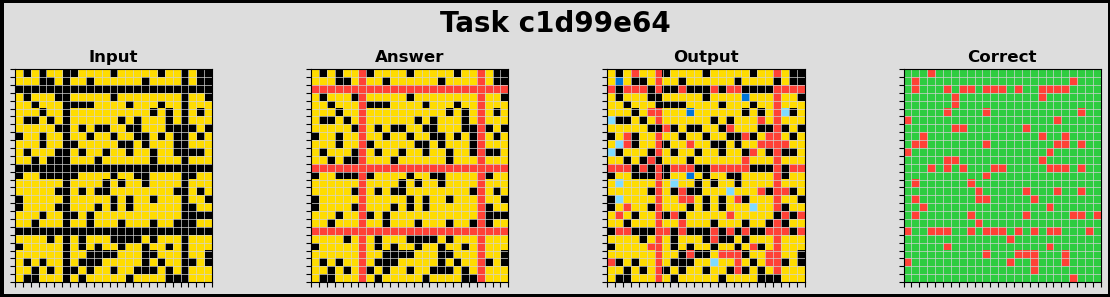

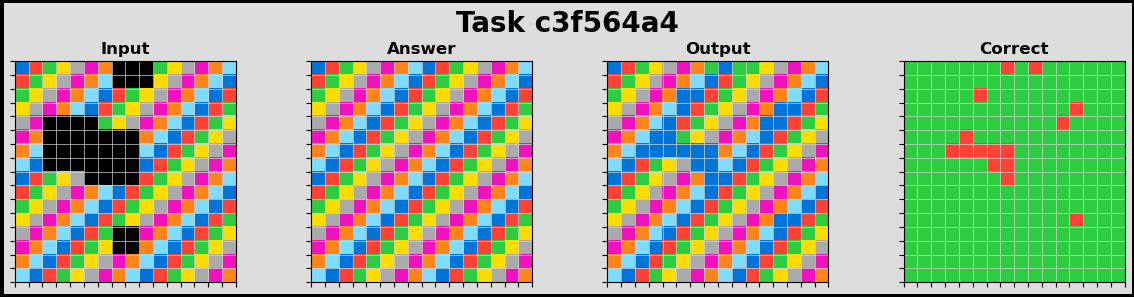

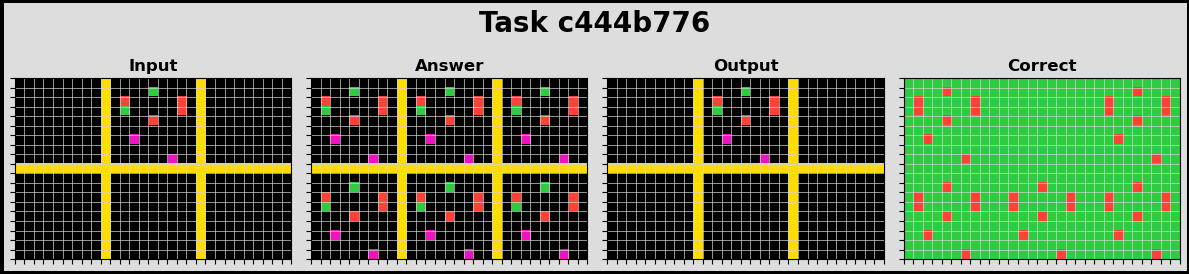

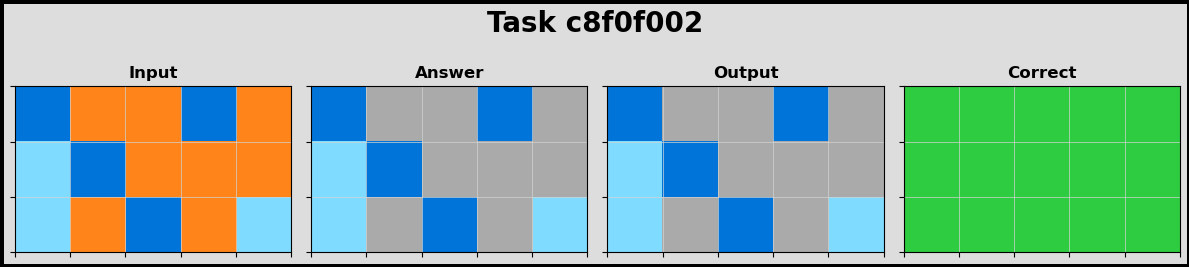

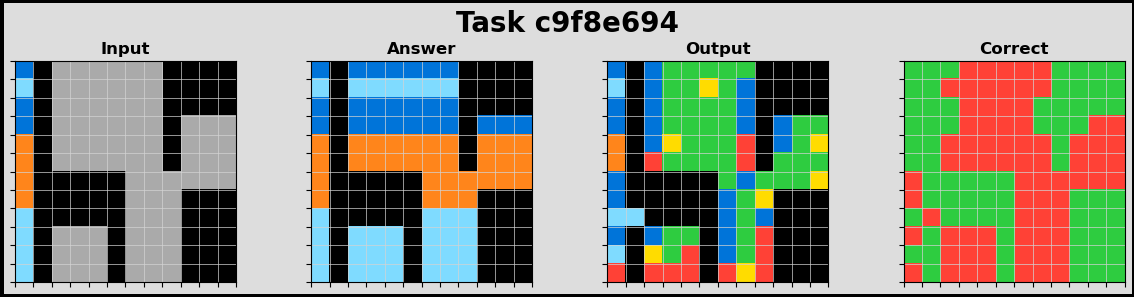

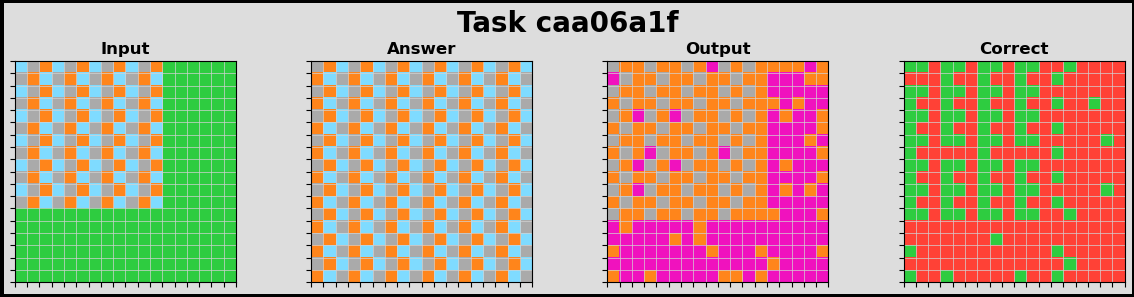

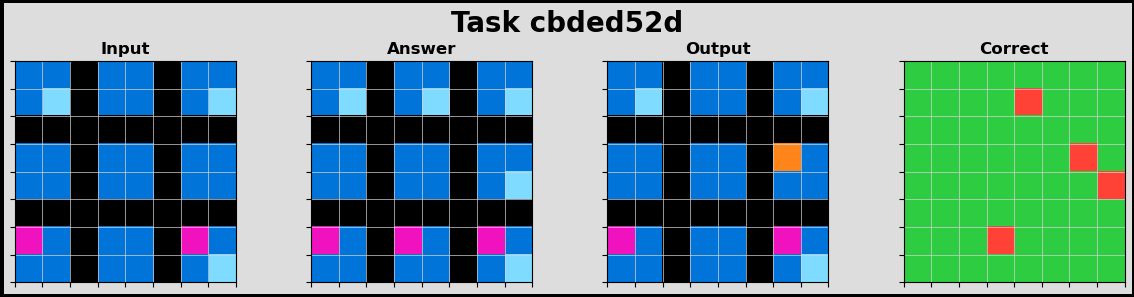

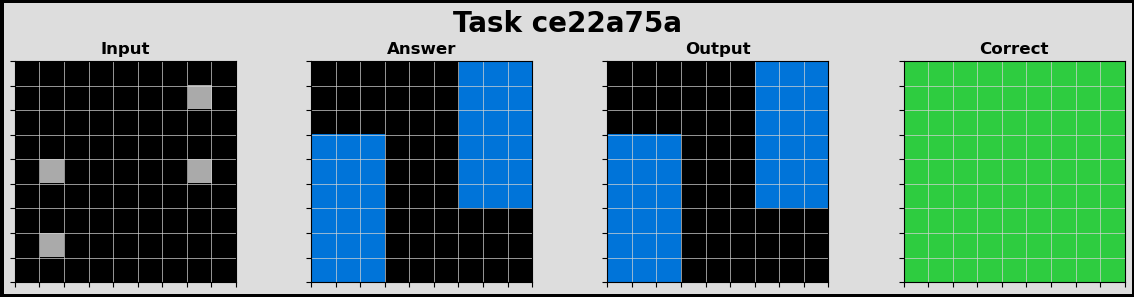

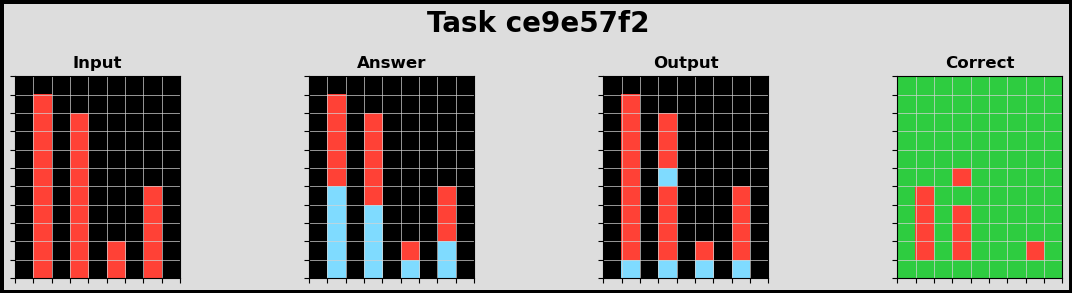

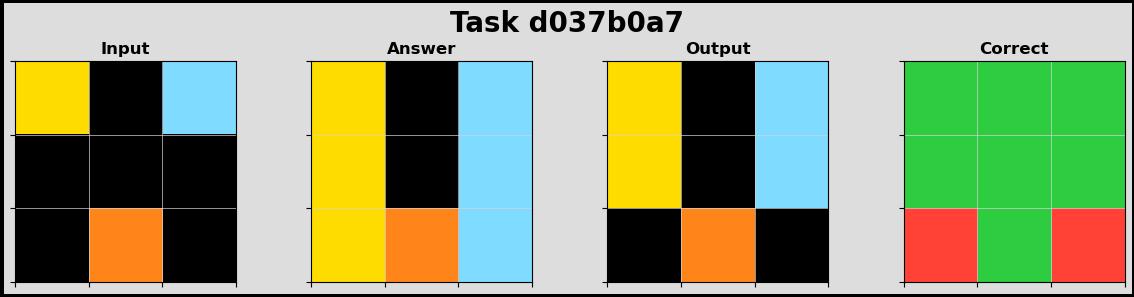

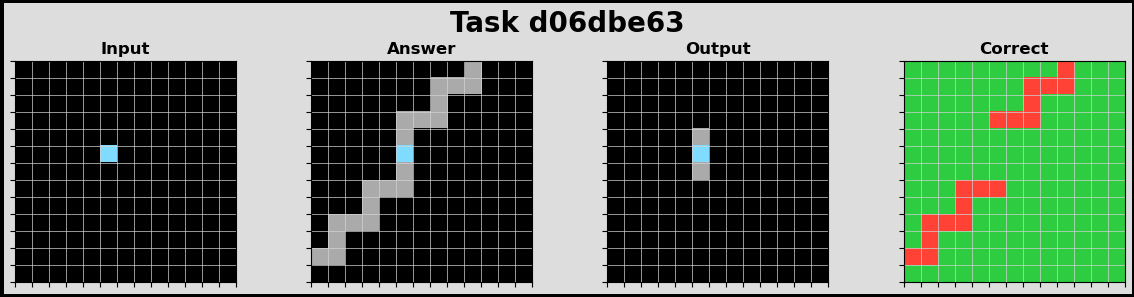

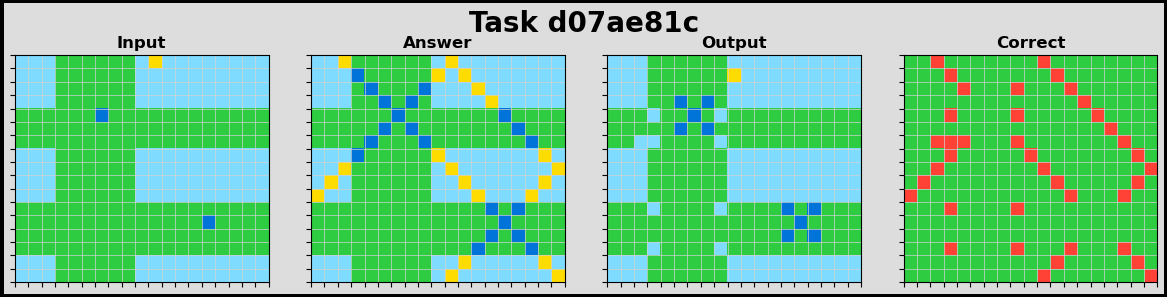

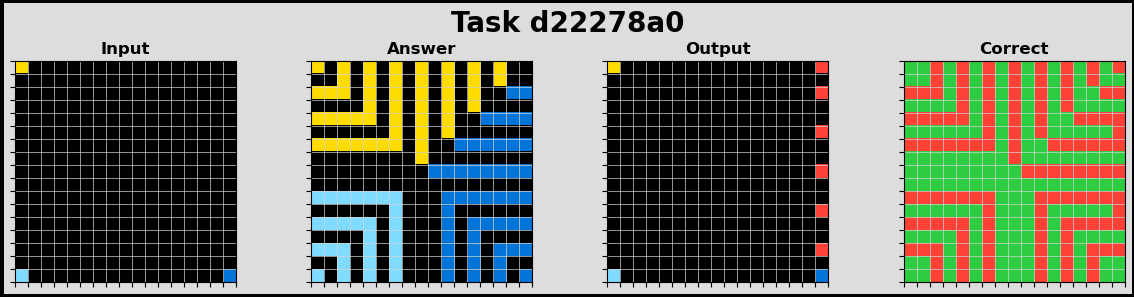

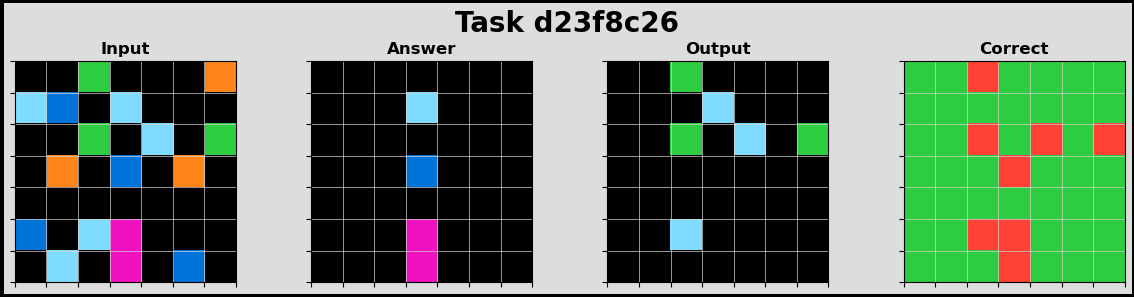

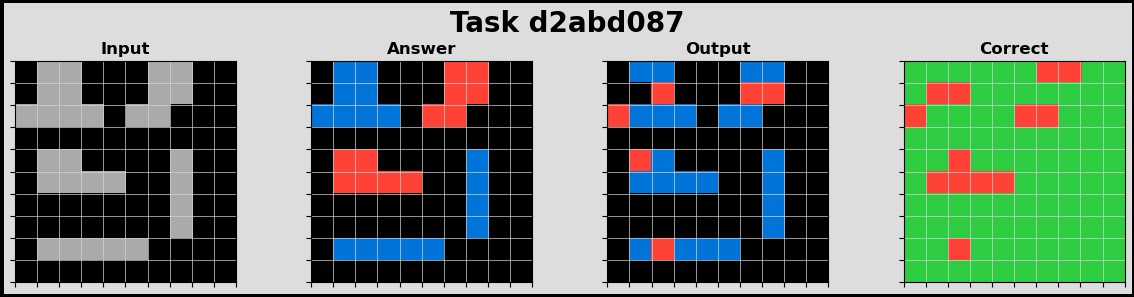

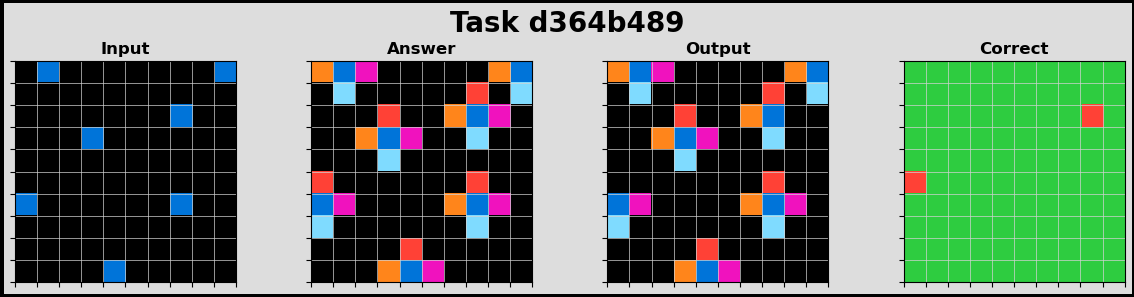

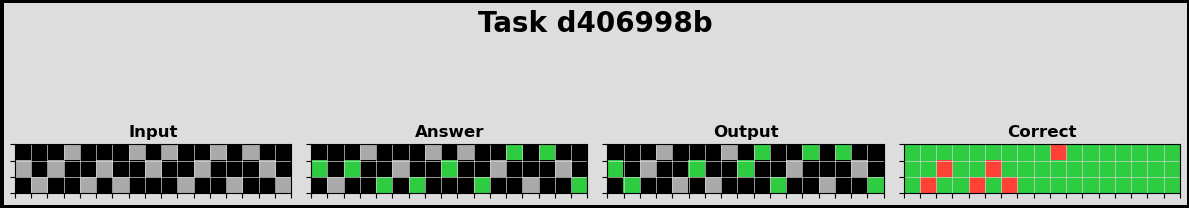

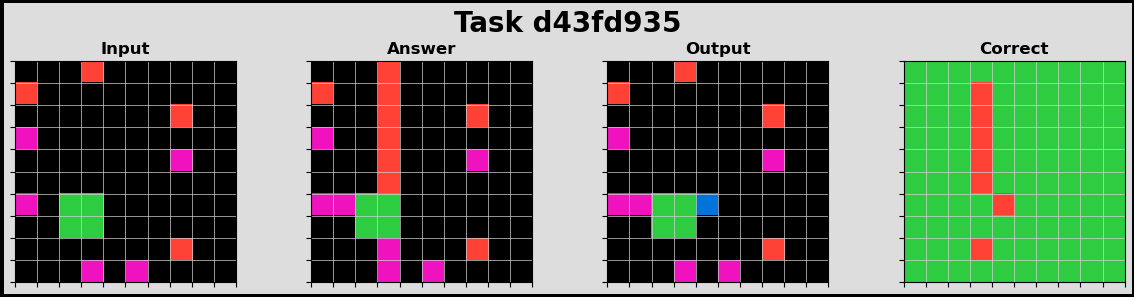

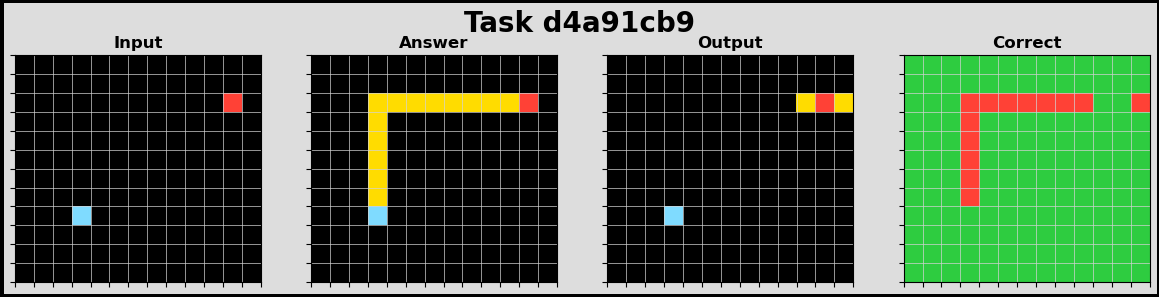

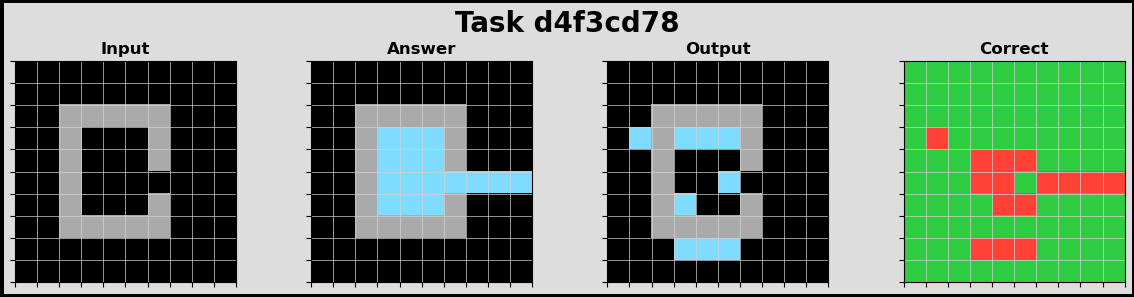

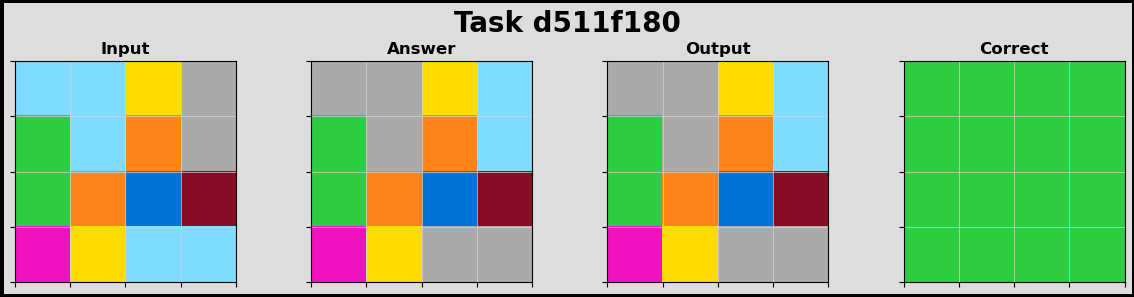

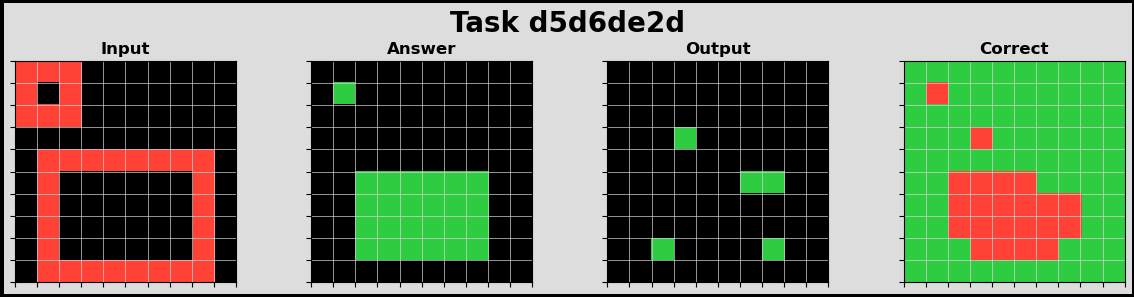

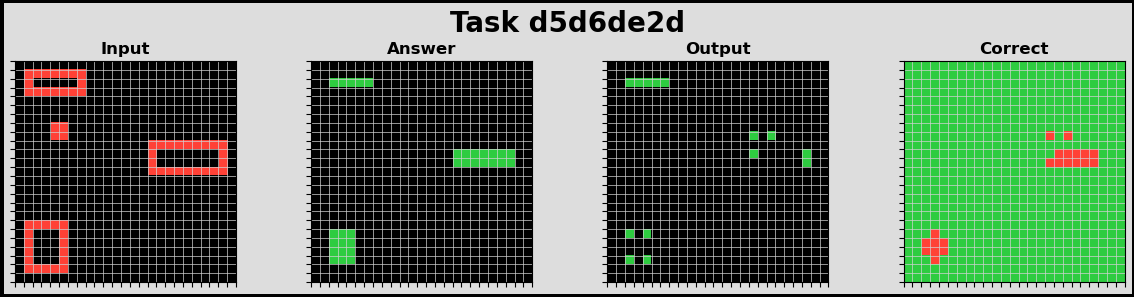

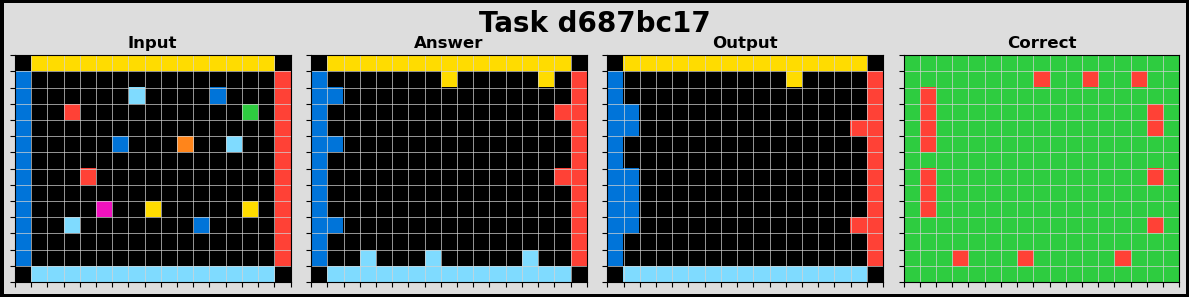

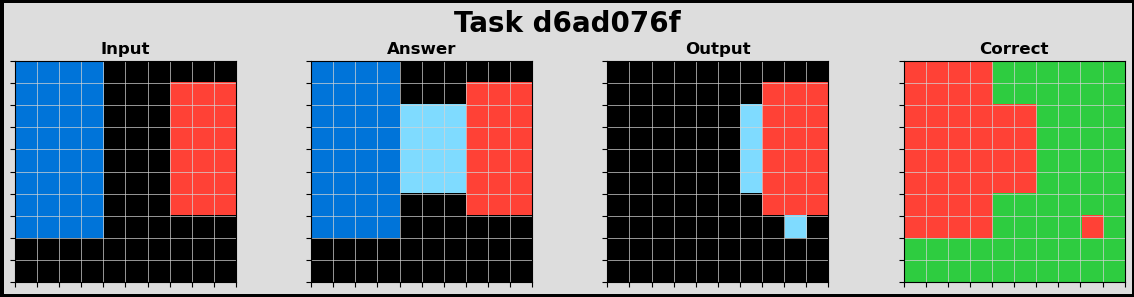

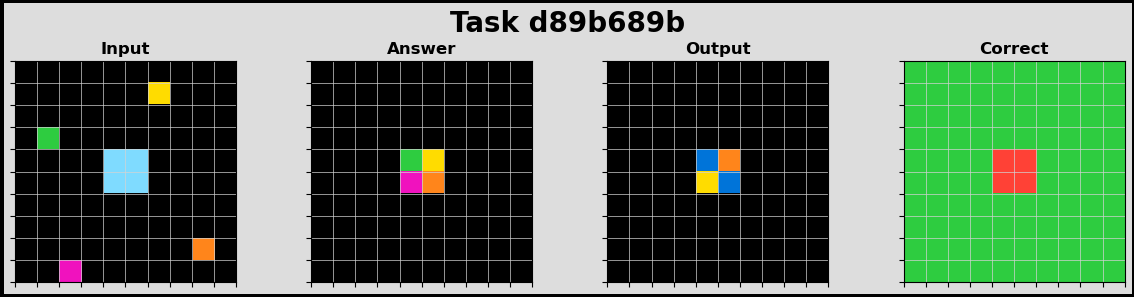

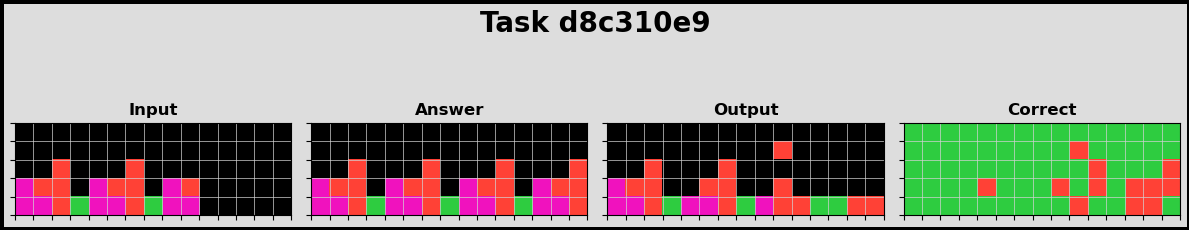

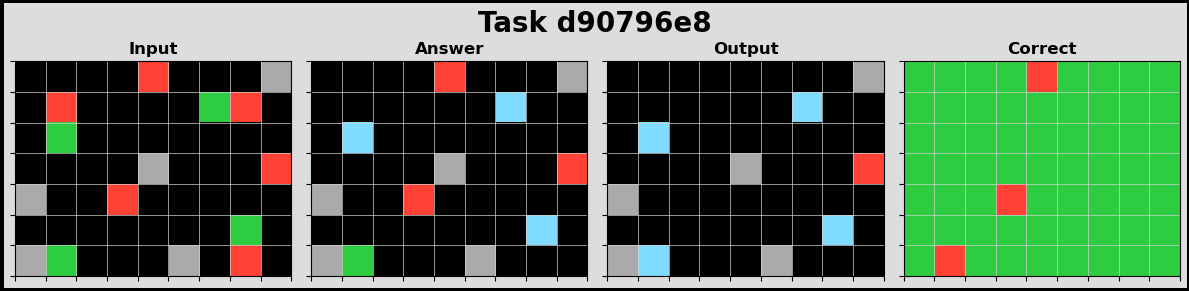

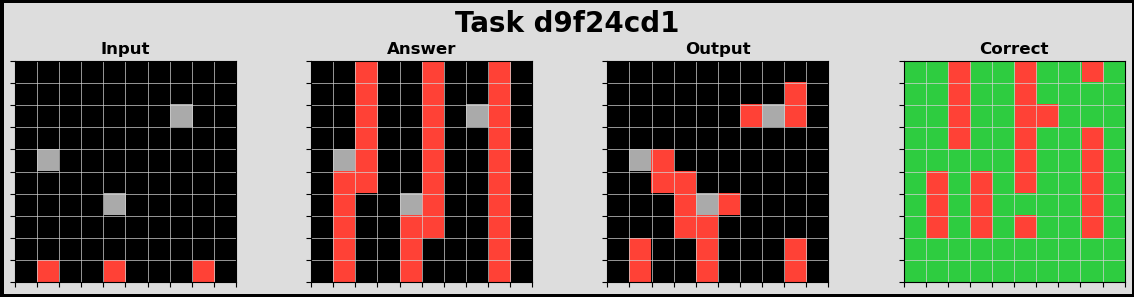

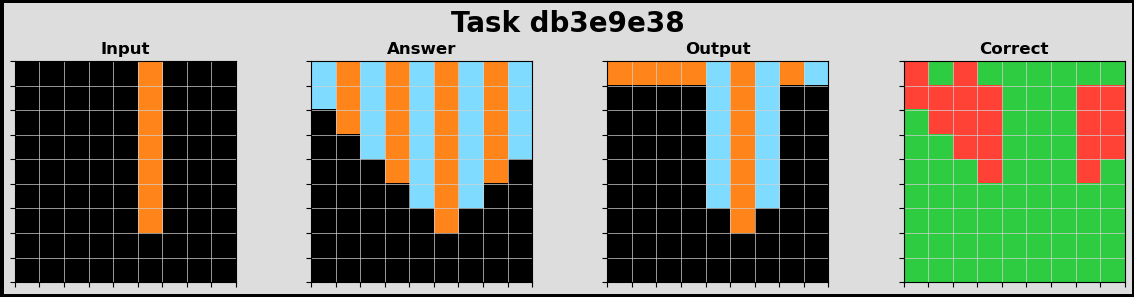

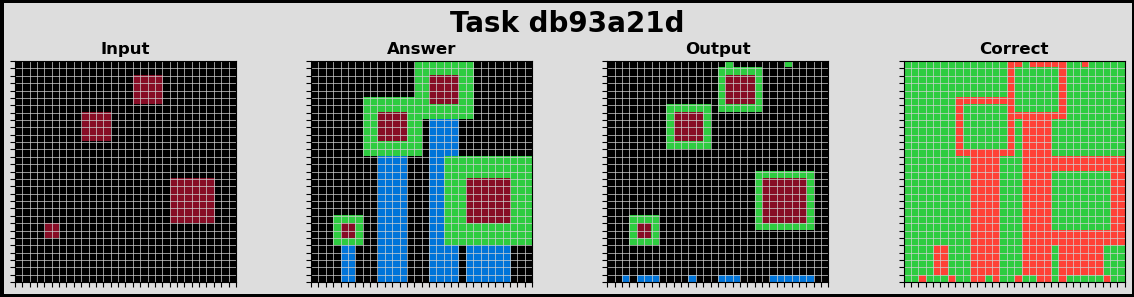

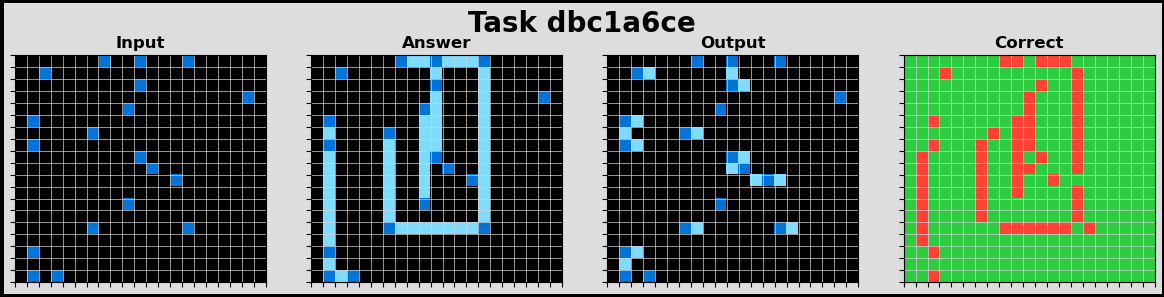

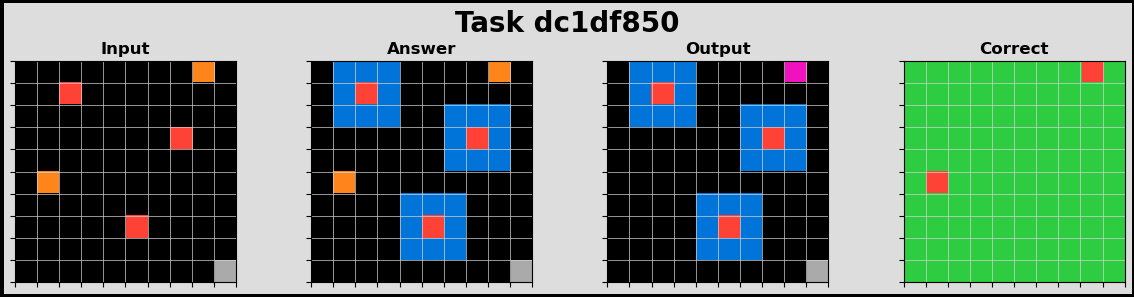

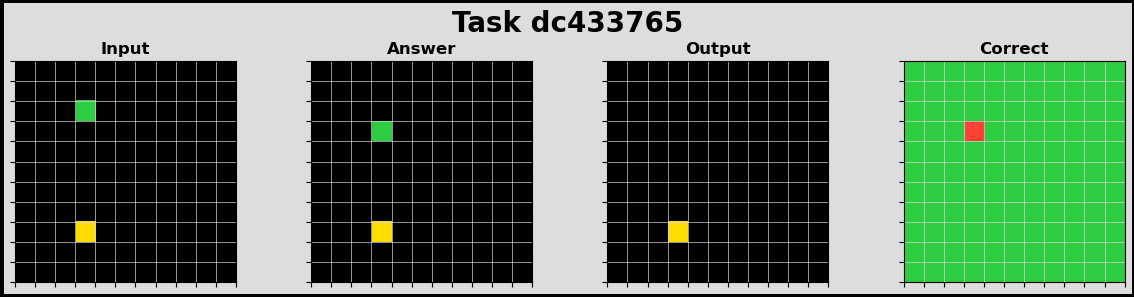

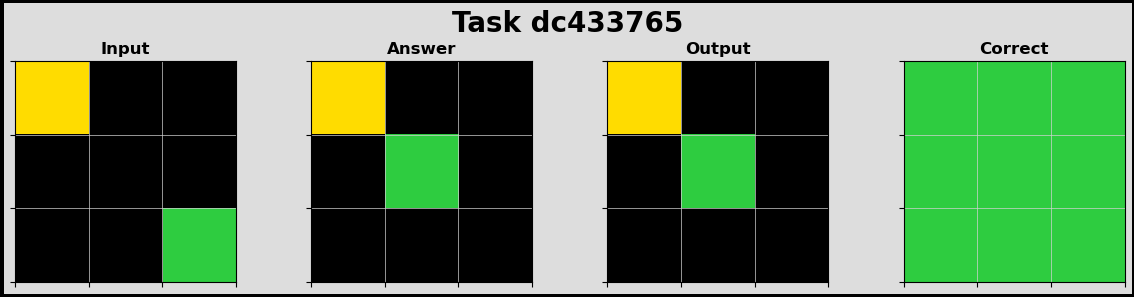

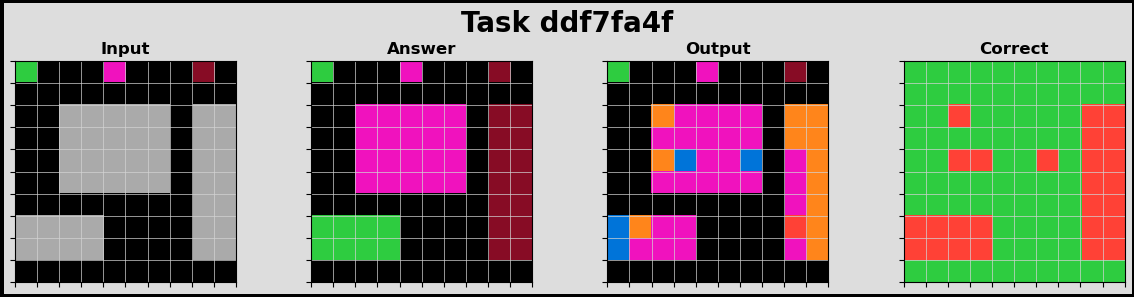

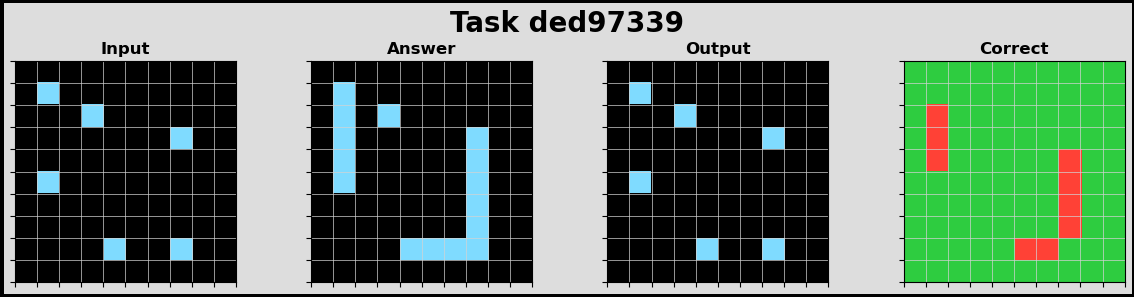

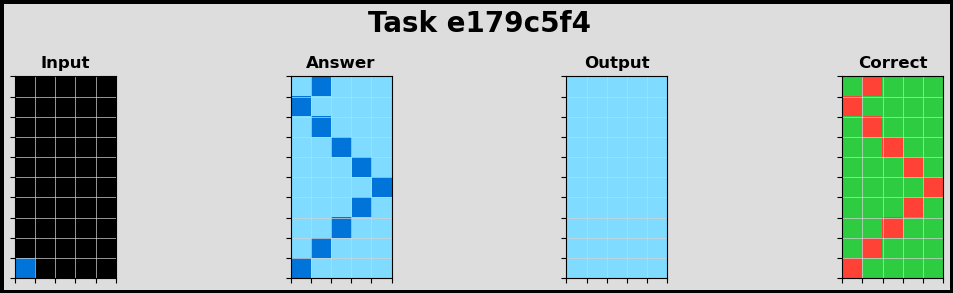

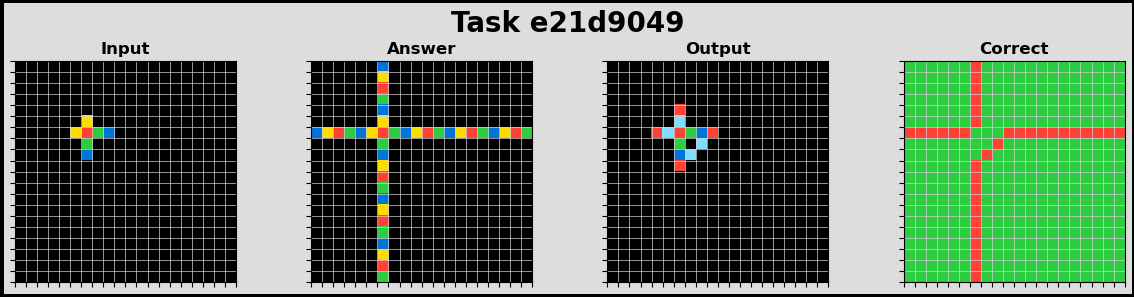

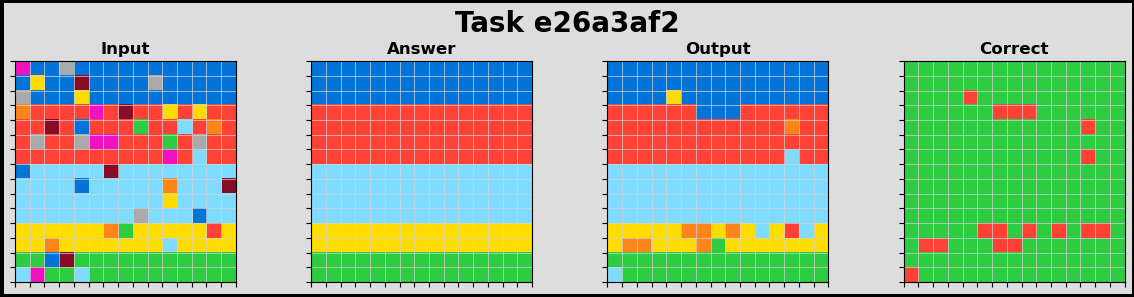

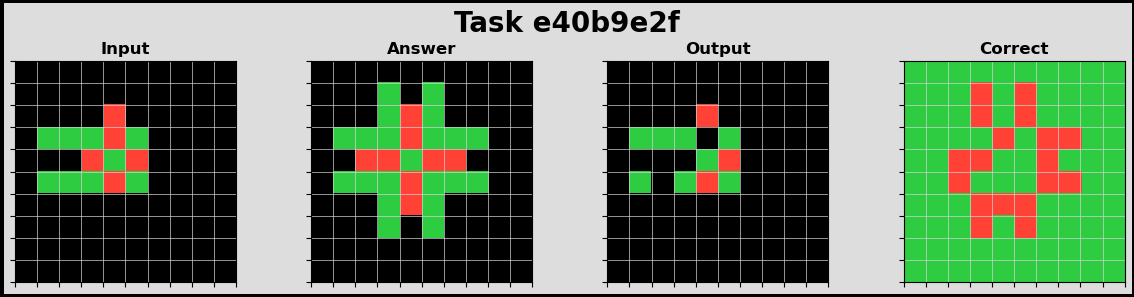

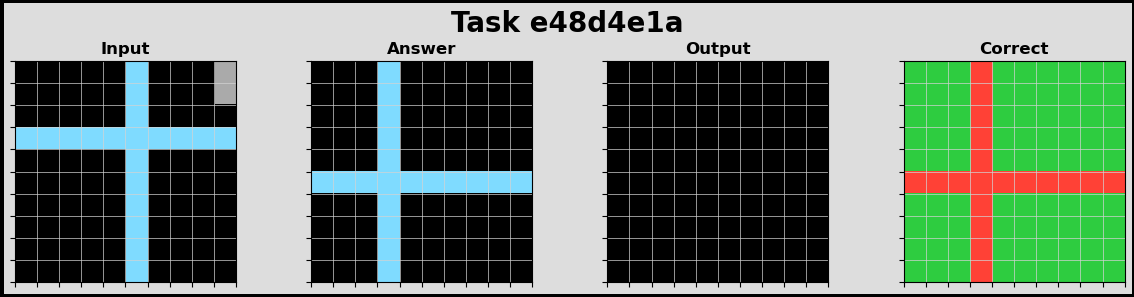

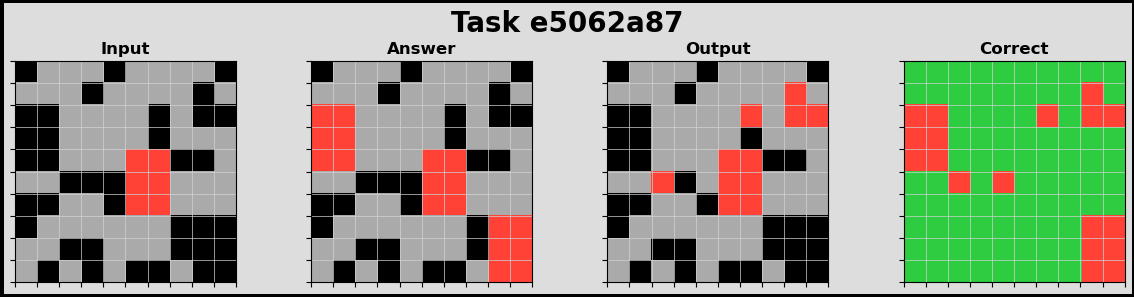

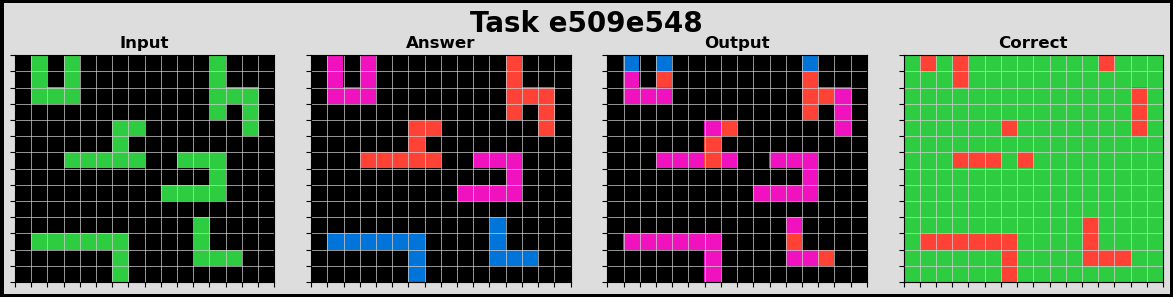

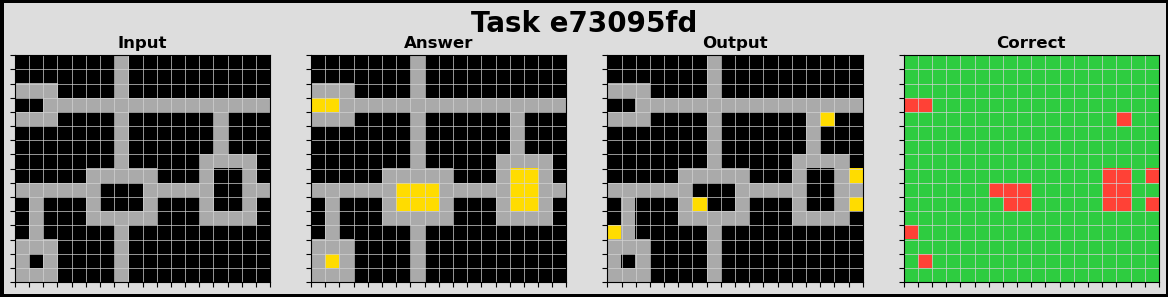

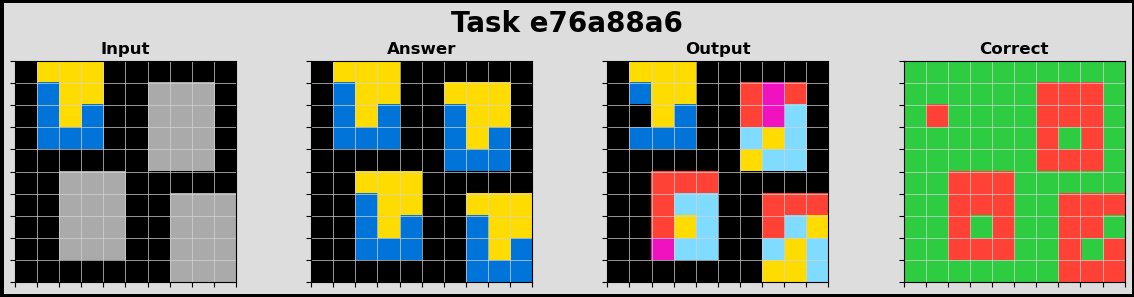

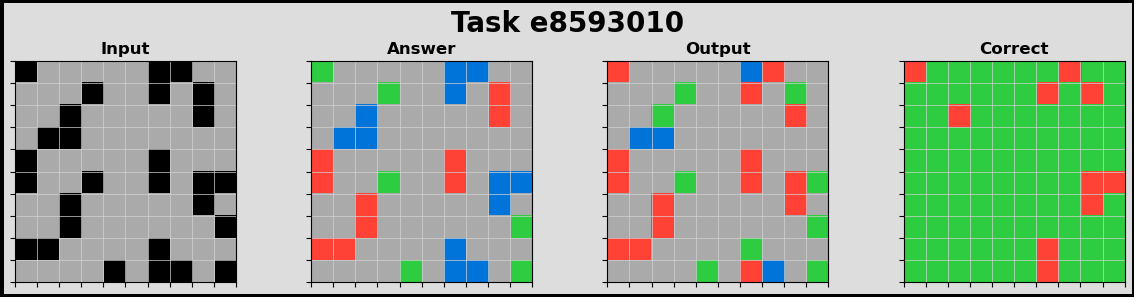

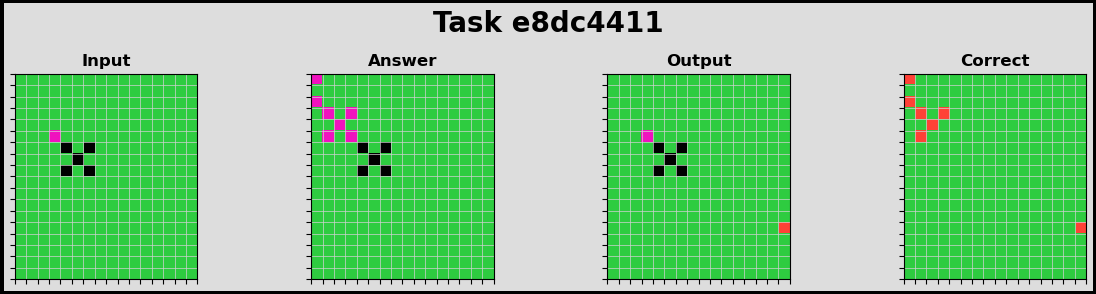

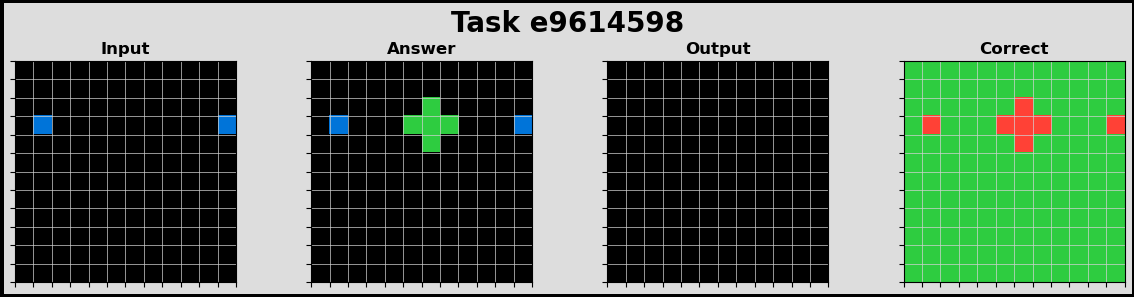

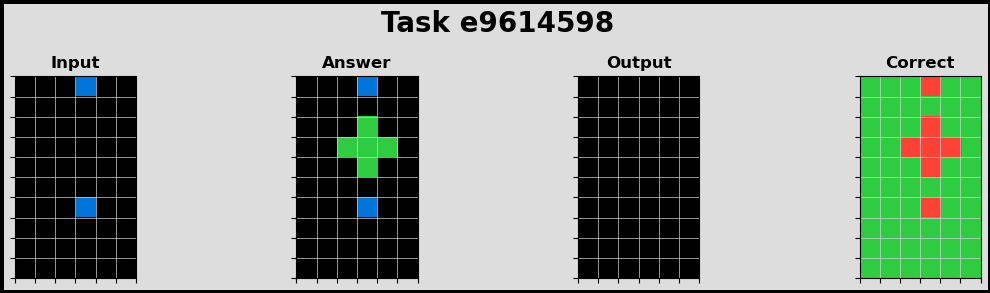

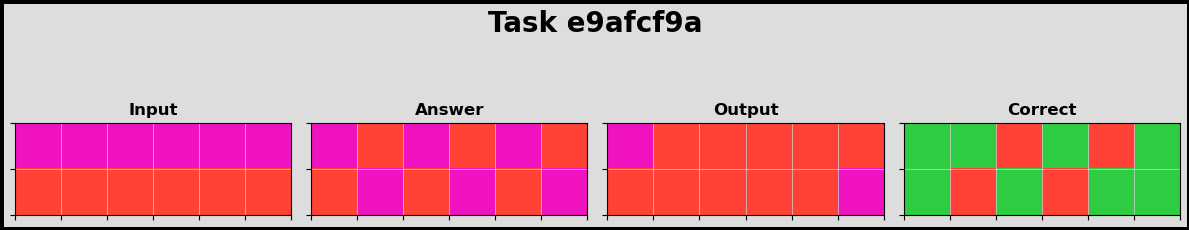

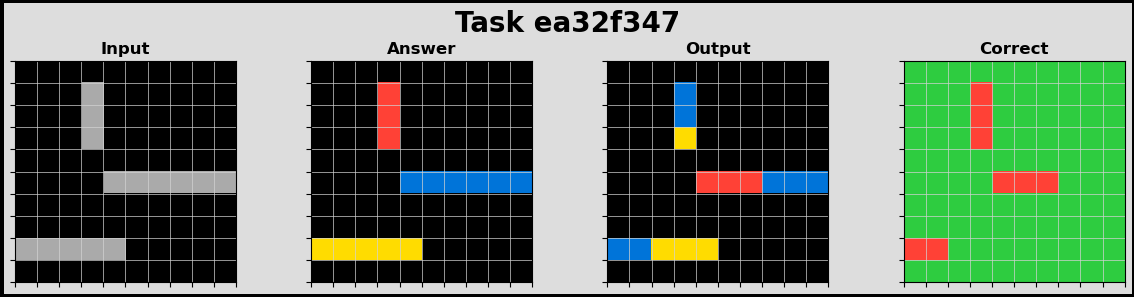

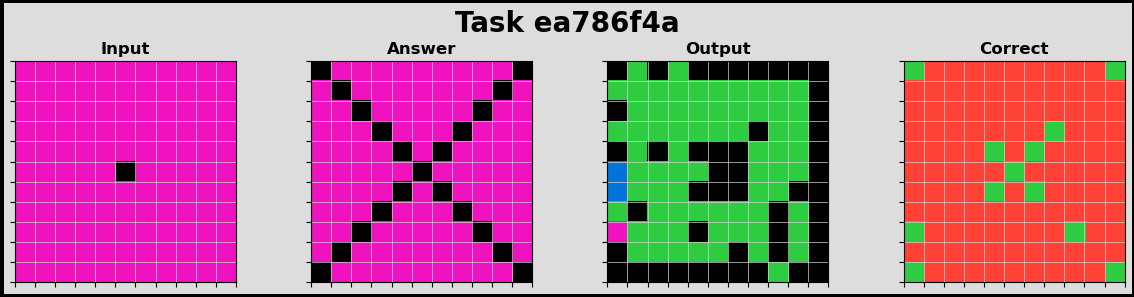

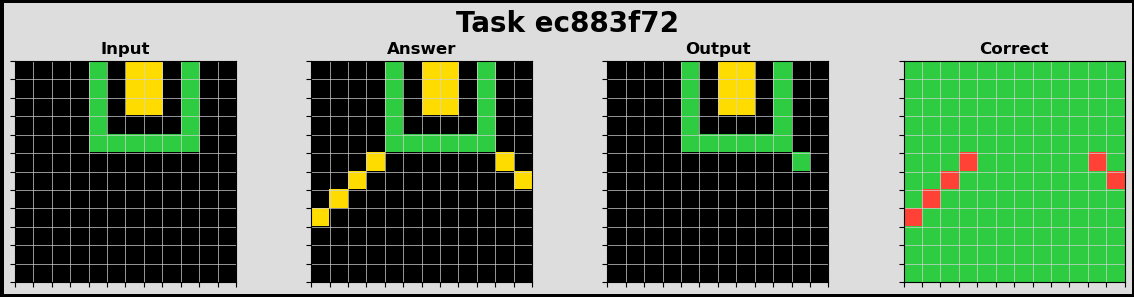

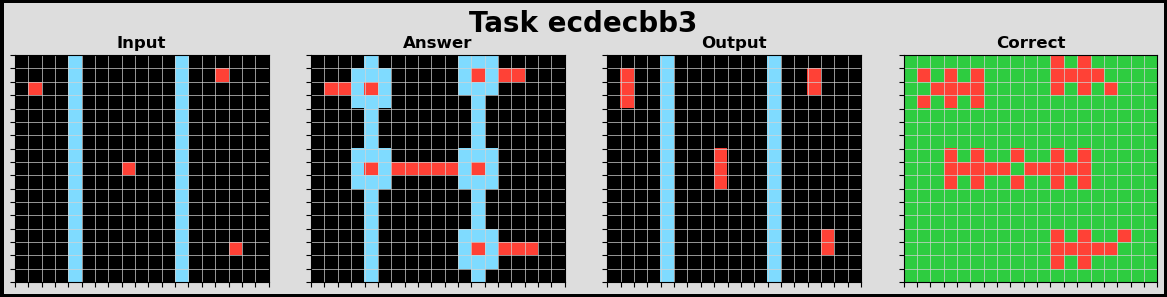

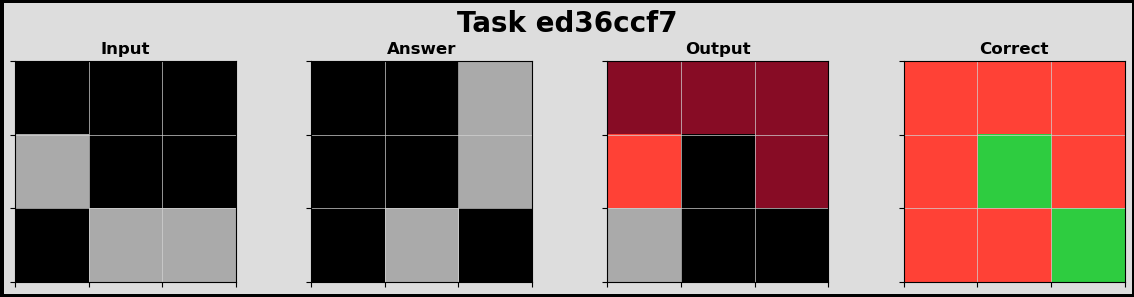

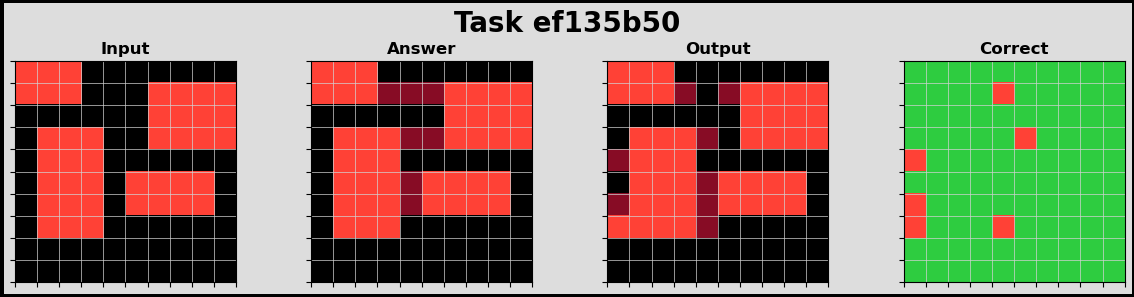

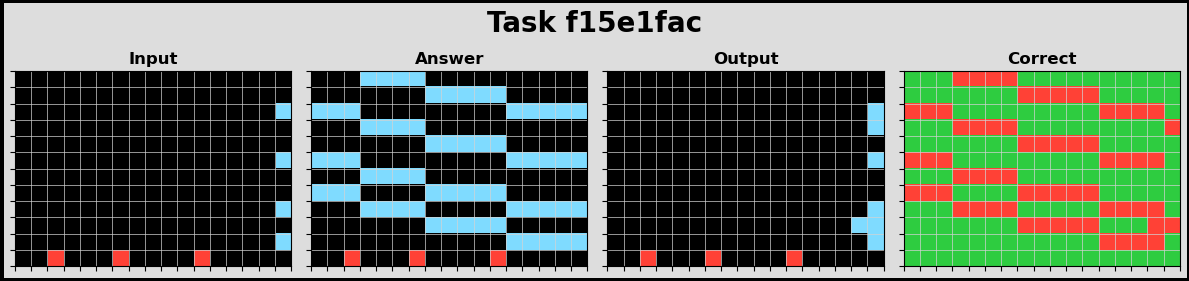

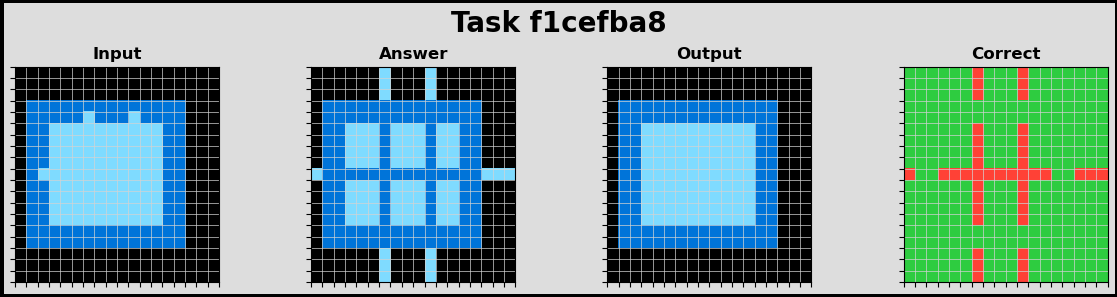

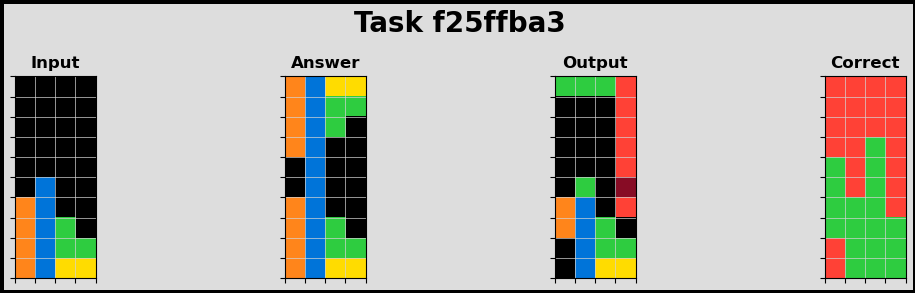

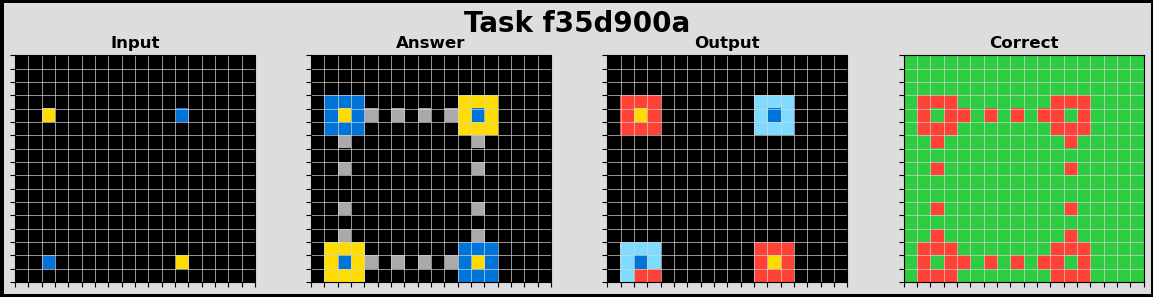

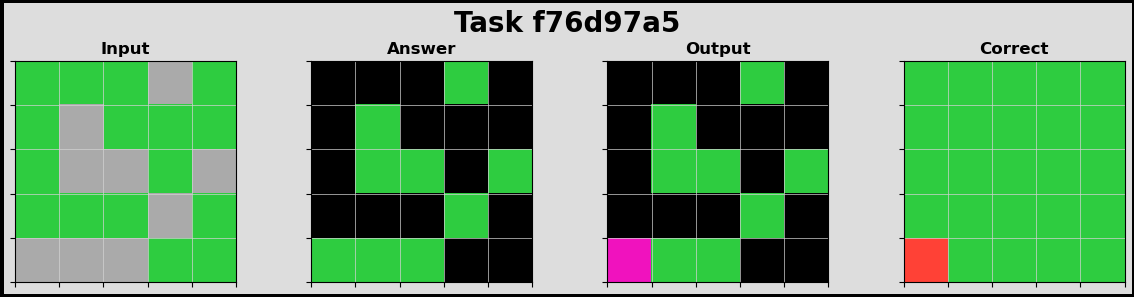

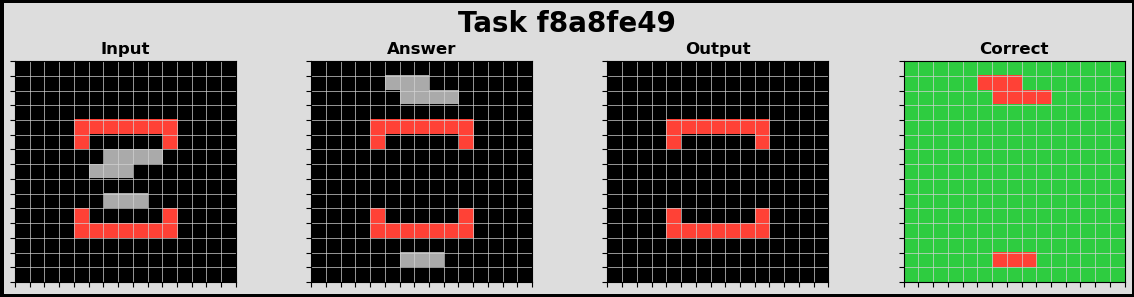

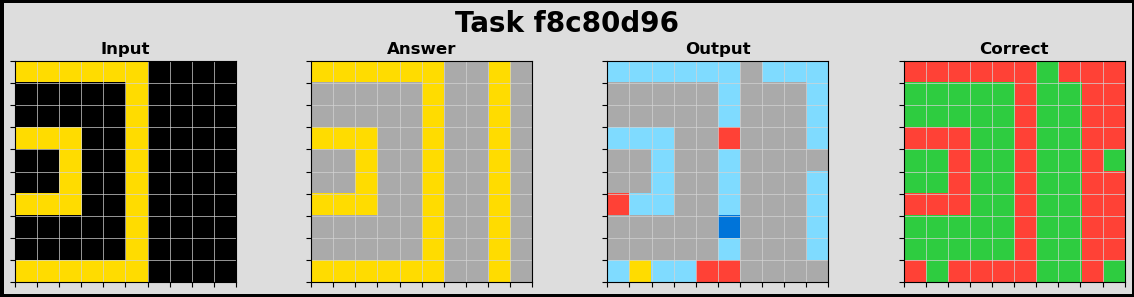

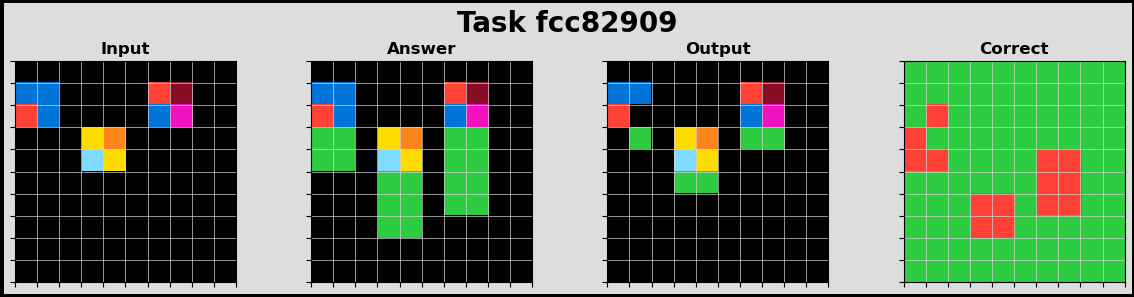

In [9]:
plot_xyt_from_json(file_path, plot_only_correct=False, top_k=1, total=400)